In [1]:
import stompy.model.delft.dflow_model as dfm
import numpy as np
import logging
import pandas as pd
import xarray as xr
from stompy.grid import multi_ugrid
from stompy import utils, memoize
import os
import six
import matplotlib.pyplot as plt
from matplotlib import colors

%matplotlib notebook

In [2]:
fig_dir="fig-scenarios-20220907"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [3]:
#def mod_str(self):
#    return f'<DFlowModel: {self.run_dir}>'
#dfm.DFlowModel.__repr__ = mod_str
#dfm.DFlowModel.__str__ = mod_str

In [4]:
import run_database
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
def load_or_none(rd):
    try:
        return dfm.DFlowModel.load(rd)
    except FileNotFoundError:
        return None
    
scen_names={0:'Base',1:'Low',2:'Medium',3:'High'}

In [5]:
events=[(np.datetime64('2016-08-11'),' Closure'),
        (np.datetime64('2016-11-01'),' Sm. Breach'),
        (np.datetime64('2016-12-11'),' Lg. Breach'),
        (np.datetime64('2017-02-07'),' Peak\n Flow'),
       ]
def label_events(ax):
    # Label events
    trans=ax.get_xaxis_transform()
    for t,name in events:
        ax.text(t,0.01,name,transform=ax.get_xaxis_transform(),va='bottom',clip_on=1)
        ax.plot([t,t],[0.,0.03],transform=trans,color='k',lw=0.75)

In [6]:
import common
six.moves.reload_module(common)
from common import prechain, his_cache

In [7]:
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
runs=all_runs[ 
    (all_runs.layers==100) 
    & (all_runs.period=='2016long')
    & (all_runs.flows=='impaired')
    & (all_runs.slr==0.0)
].copy()
runs['name']=runs.scen.map(scen_names)

six.moves.reload_module(dfm)
runs['model']=runs.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))
runs

run_dir  scen  layers  slr  \
0  data_2016long_3d_asbuilt_impaired_scen0_l100-v...     0     100  0.0   
1  data_2016long_3d_asbuilt_impaired_scen1_l100-v...     1     100  0.0   
2  data_2016long_3d_asbuilt_impaired_scen2_l100-v...     2     100  0.0   
3  data_2016long_3d_asbuilt_impaired_scen3_l100-v...     3     100  0.0   

     period    status     flows    name  \
0  2016long  complete  impaired    Base   
1  2016long  complete  impaired     Low   
2  2016long  complete  impaired  Medium   
3  2016long  complete  impaired    High   

                                               model  
0  <DFlowModel: data_2016long_3d_asbuilt_impaired...  
1  <DFlowModel: data_2016long_3d_asbuilt_impaired...  
2  <DFlowModel: data_2016long_3d_asbuilt_impaired...  
3  <DFlowModel: data_2016long_3d_asbuilt_impaired...

Stage
---

Preliminary 2D plots:

First step is to verify that the scenarios are working as planned.
 - time series of waterlevel at key locations
 
Second step is to go through the analyses in the scope:
 - which can be handled in 2D
 - do any require more output than is currently configured?
 


In [8]:
stage_stations=[ ['thalweg_pesc_0000','Ocean'],
                 ['nck','Lagoon'],
                 ['pch_up','Culverts (N)'],
                 ['npc','Ped. Bridge'],
                 ['nmp','North Marsh Panne'],
               ]

In [9]:
scen_styles={'Base':dict(color='tab:Blue'),
             'Low':dict(color='tab:Orange'),
             'Medium':dict(color='tab:Green',ls='--'),
             'High':dict(color='tab:Red')}
scen_styles['Base+SLR']=scen_styles['Base']
scen_styles['Low+SLR']=scen_styles['Low']
scen_styles['Medium+SLR']=scen_styles['Medium']
scen_styles['High+SLR']=scen_styles['High']




In [10]:
def fig_waterlevel_discharge_bystation_timeseries(runs,station,label):
    fig,axs=plt.subplots(2,1,figsize=(7.5,4),sharex=True)

    # Stage at stations:
    colors={}
    ax=axs[0]
    
    for _,rec in runs.iterrows():
        #his=rec['model'].his_dataset(chain=True,prechain=prechain) # use preloaded
        wse=his_cache(rec['model'],stations=station,variable='waterlevel')
        l=ax.plot(wse.time,
                  wse,
                  label=rec['name'],
                  lw=1.5,alpha=0.6)
        colors[rec['name']]=l[0].get_color()

    if 1: # show mouth thalweg, too
        for _,rec in runs.iterrows():
            # HERE: have to add support for additional coordinates to his_cache.
            his=rec['model'].his_dataset() # use preloaded
            ax.plot(his.time,
                    his.general_structure_crest_level.sel(general_structures='mouth'),
                    label='__nolabel__',
                    ls='--',color=colors[rec['name']],
                    lw=1.5,alpha=0.6)
        
    ax.legend(loc='upper left',bbox_to_anchor=[1.03,1])
    ax.set_ylabel('Stage (m)')
    ax.text(0.03,0.97,label,transform=ax.transAxes,ha='left',va='top')

    ax=axs[1]
    for _,rec in runs.iterrows():
        his=rec['model'].his_dataset(chain=True,prechain=prechain)
        if 'pch_gate' in his.general_structures:
            ax.plot(his.time,
                    his.general_structure_discharge.sel(general_structures='pch_gate'),
                    label=rec['name'],
                    lw=1.5,alpha=0.6)
        elif 'gategens' in his.dims and 'pch_gate' in his.gategens:
            ax.plot(his.time,
                    his.gategen_discharge.sel(gategens='pch_gate'),
                    label=rec['name'],
                    lw=1.5,alpha=0.6)
        elif 'pch_gate' in his.weirgens:
            ax.plot(his.time,
                    his.weirgen_discharge.sel(weirgens='pch_gate'),
                    label=rec['name'],
                    lw=1.5,alpha=0.6)                
        
    ax.legend(loc='upper left',bbox_to_anchor=[1.03,1])
    ax.set_ylabel('Flow (m3/s)')
    
    fig.subplots_adjust(right=0.80,left=0.1,top=0.98)
    fig.autofmt_xdate()
    return fig

In [11]:
if 0: # not using these right now
    for station,label in stage_stations:
        fig=fig_waterlevel_discharge_bystation_timeseries(runs,station,label)
        fig.savefig(os.path.join(fig_dir,f'stage_Q-timeseries-2016-stn_{station}.png'),
                    dpi=150)

In [12]:
           
# Similar plots, but each panel is one station.
def fig_waterlevel_bystation_timeseries(runs,station,label,as_depth=False,chain=True,min_depth=0.0):
    fig,ax=plt.subplots(1,1,figsize=(7.5,4))

    datas=[] # double plural
    
    for _,rec in runs.iterrows():
        data = his_cache(rec['model'],stations=station,
                         variable='waterlevel',chain=chain)
        scen=rec['name']
        if scen=='Base':
            zorder=3 # smaller tidal range, so plot on top.
        else:
            zorder=2
            
        if as_depth or min_depth>0.0:
            z_bed=his_cache(rec['model'],stations=station,variable='bedlevel',
                            chain=chain)
            depth=data-z_bed
            if as_depth:
                data=depth
            if min_depth>0.0:
                data=data.load().copy() # make dask happy, don't contaminate cache.
                data[depth<min_depth]=np.nan
                
        ax.plot(data.time, data,
                label=scen,
                lw=1.2,alpha=1,zorder=zorder,**scen_styles[scen])
        datas.append(data)

    ax.legend(loc='upper center',bbox_to_anchor=[0.45,1.12],ncol=len(runs),
              frameon=0)
    label_events(ax)

    t_min=min([data.time.values[0] for data in datas])
    t_max=max([data.time.values[-1] for data in datas])
    ax.axis(xmin=t_min,xmax=t_max)

    if as_depth:
        ax.set_ylabel('Depth (m)')
    else:
        ax.set_ylabel('Stage (m)')
        
    ax.text(0.03,0.97,label,transform=ax.transAxes,ha='left',va='top')
    fig.autofmt_xdate()
    fig.subplots_adjust(right=0.98,left=0.1,top=0.92, bottom=0.14)
    return fig

<IPython.core.display.Javascript object>


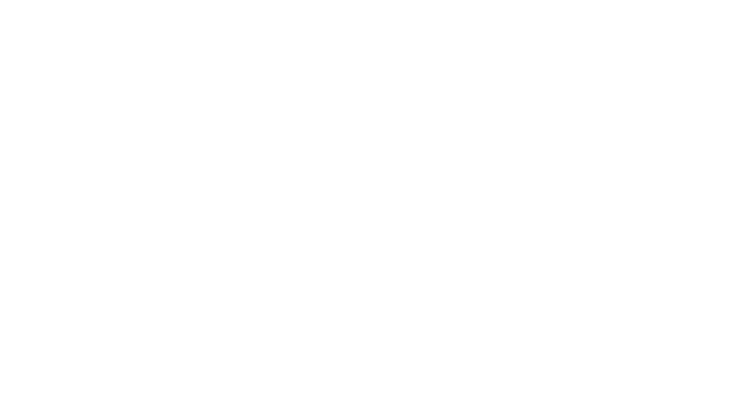

<IPython.core.display.Javascript object>


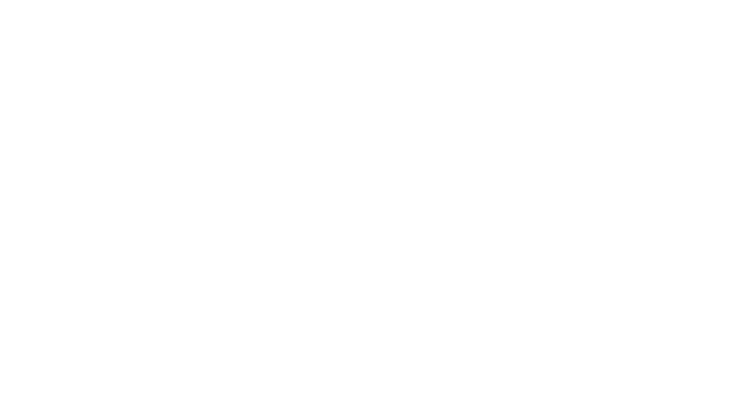

<IPython.core.display.Javascript object>


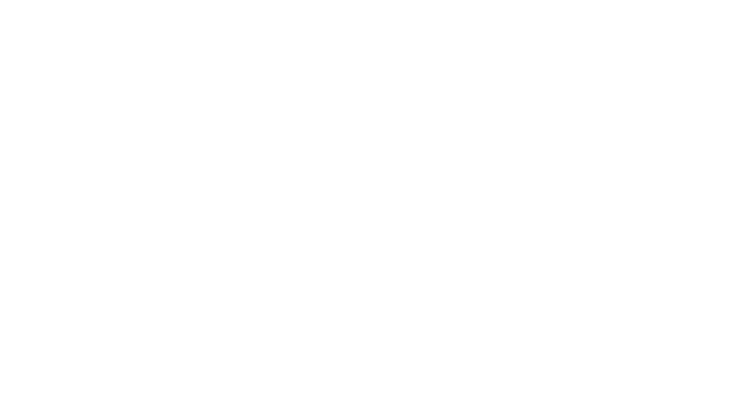

<IPython.core.display.Javascript object>


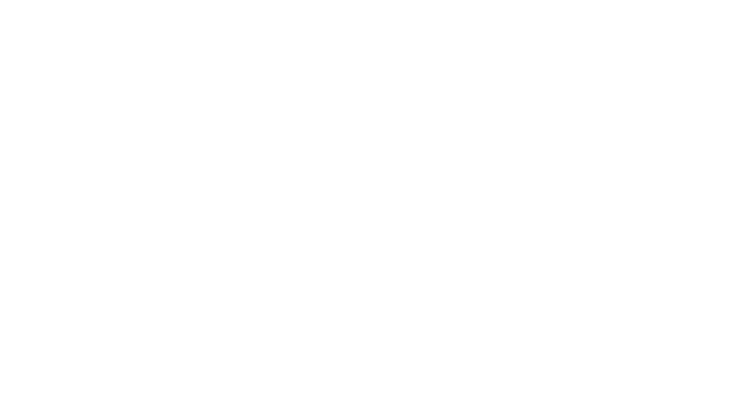

<IPython.core.display.Javascript object>


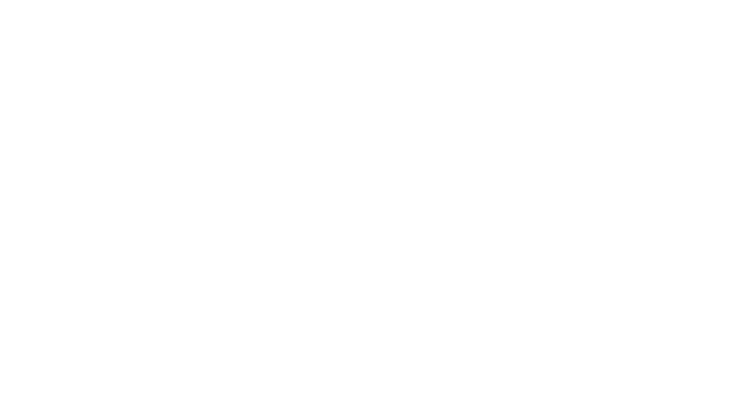

<IPython.core.display.Javascript object>


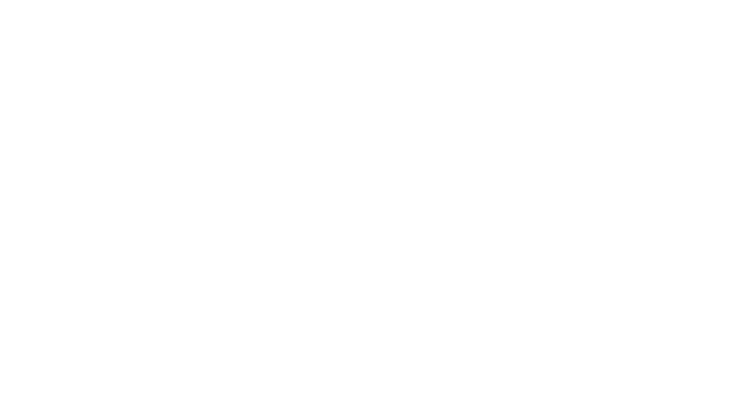

<IPython.core.display.Javascript object>


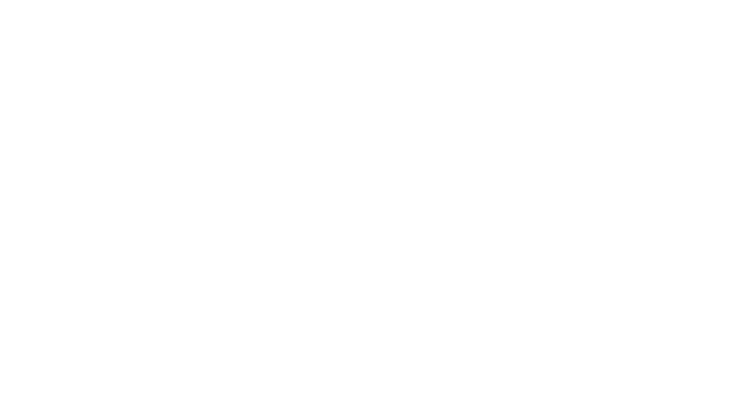

<IPython.core.display.Javascript object>


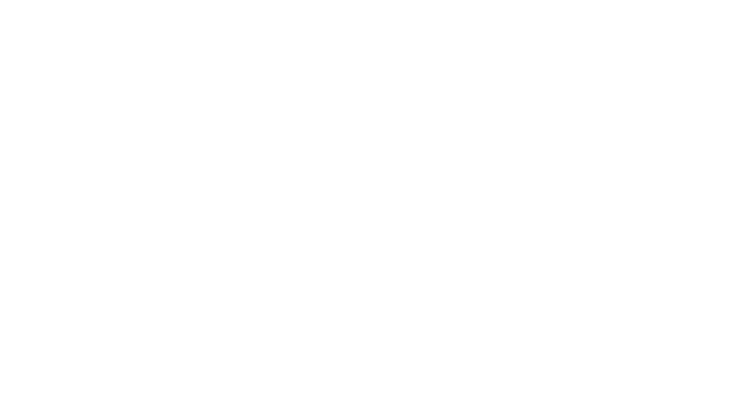

<IPython.core.display.Javascript object>


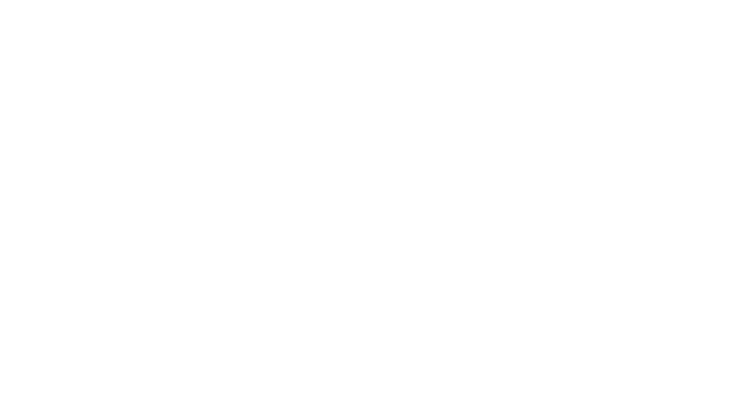

<IPython.core.display.Javascript object>


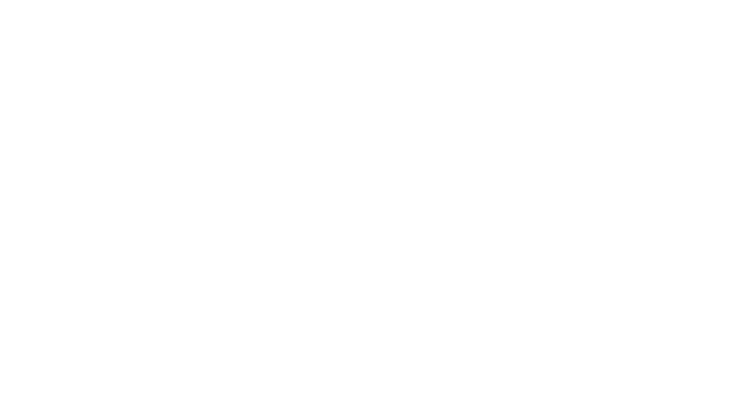

In [13]:
for station,label in stage_stations:
    fig=fig_waterlevel_bystation_timeseries(runs,station,label,min_depth=0.025)
    fig.savefig(os.path.join(fig_dir,f'stage-timeseries-2016-stn_{station}.png'),
                dpi=150)
    fig2=fig_waterlevel_bystation_timeseries(runs,station,label,as_depth=True,min_depth=0.025)
    fig2.savefig(os.path.join(fig_dir,f'depth-timeseries-2016-stn_{station}.png'),
                 dpi=150)

In [14]:
def fig_waterlevel_timeseries(rec, as_depth=False, chain=True):
    fig,ax=plt.subplots(1,1,figsize=(7.5,4))

    # will use pre-loaded his dataset, so let the caller choose whether
    # to chain or not.
    
    for station,name in stage_stations:
        data = his_cache(rec['model'],stations=station,variable='waterlevel',chain=chain)
        if as_depth:
            z_bed=his_cache(rec['model'],stations=station,variable='bedlevel',chain=chain)
            data=data-z_bed        
        ax.plot(data.time,data,lw=1.2,label=name)

    ax.legend(loc='upper center',bbox_to_anchor=[0.45,1.12],ncol=len(stage_stations),
              frameon=0)
    if as_depth:
        ax.set_ylabel('Depth (m)')
    else:
        ax.set_ylabel('Stage (m)')
    ax.text(0.03,0.97,rec['name'],transform=ax.transAxes,ha='left',va='top')
        
    label_events(ax)
    
    ax.axis(xmin=data.time.values[0],xmax=data.time.values[-1])
    fig.autofmt_xdate()
    fig.subplots_adjust(right=0.98,left=0.1,top=0.92, bottom=0.14)
    return fig

<IPython.core.display.Javascript object>


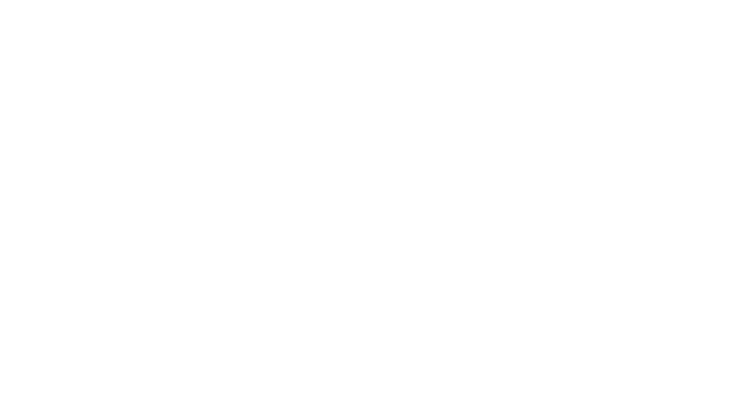

<IPython.core.display.Javascript object>


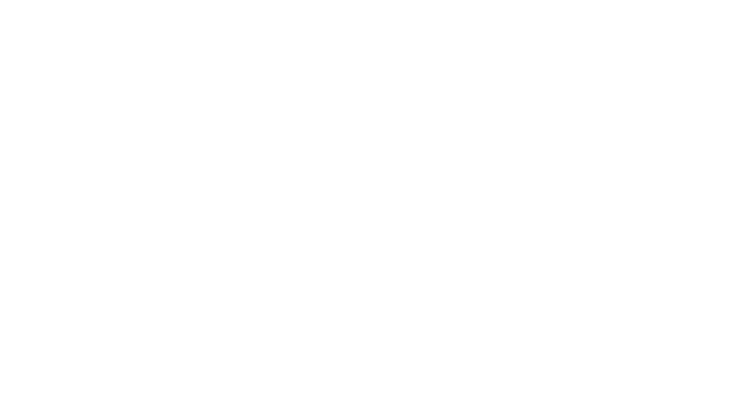

<IPython.core.display.Javascript object>


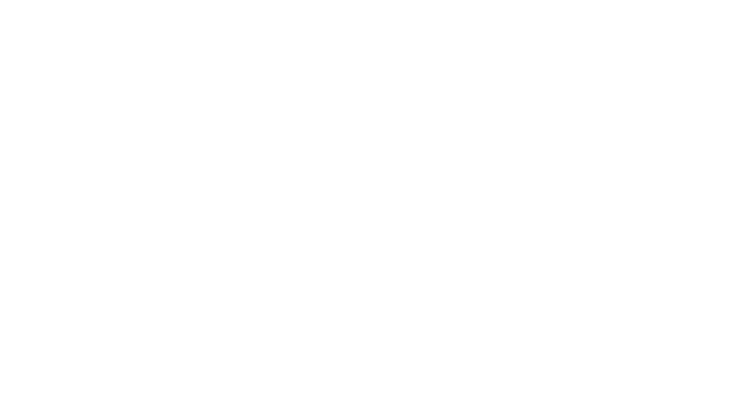

<IPython.core.display.Javascript object>


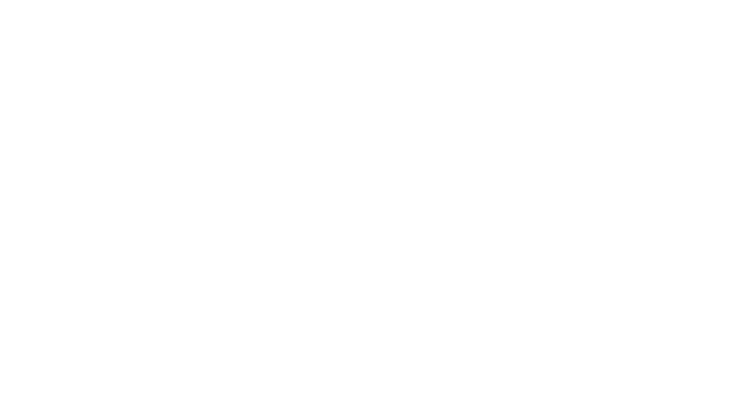

<IPython.core.display.Javascript object>


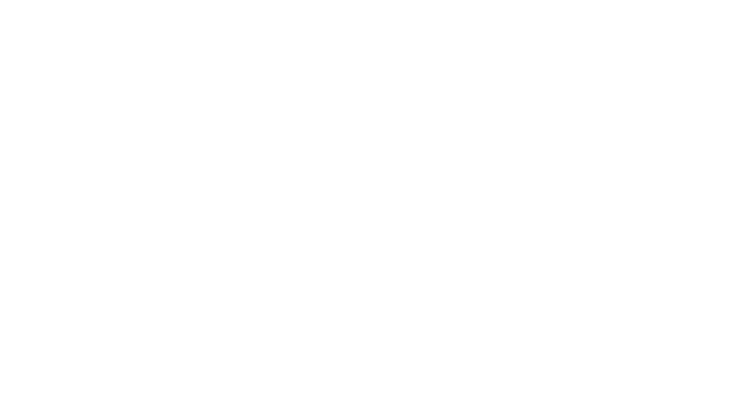

<IPython.core.display.Javascript object>


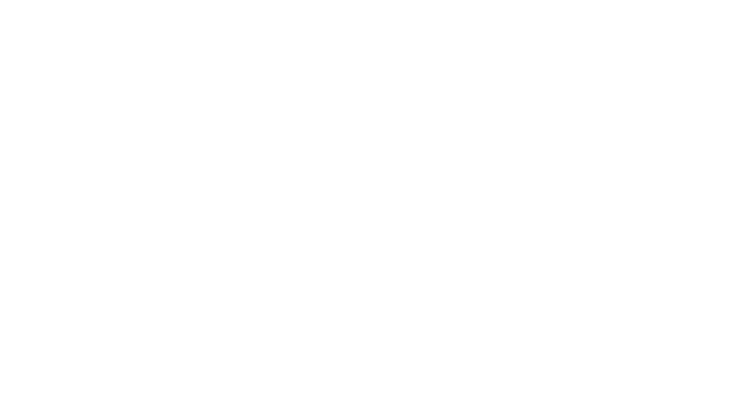

<IPython.core.display.Javascript object>


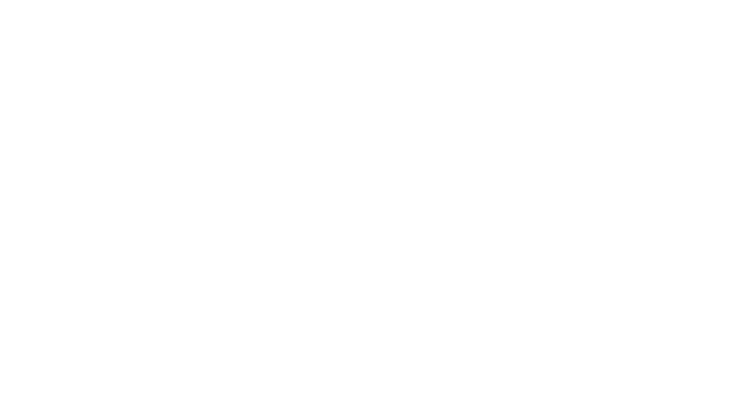

<IPython.core.display.Javascript object>


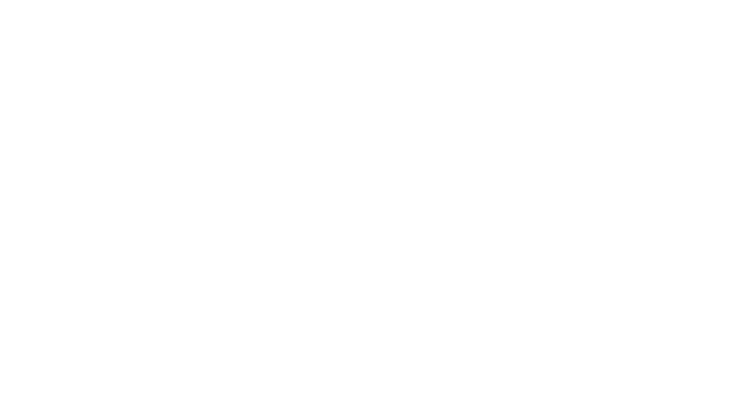

In [15]:
for _,rec in runs.iterrows():
    fig=fig_waterlevel_timeseries(rec) 
    fig.savefig(os.path.join(fig_dir,f"stage-timeseries-2016-{rec['name']}.png"),
                dpi=150)
    fig2=fig_waterlevel_timeseries(rec,as_depth=True) 
    fig2.savefig(os.path.join(fig_dir,f"depth-timeseries-2016-{rec['name']}.png"),
                 dpi=150)

In [16]:
plt.close('all')

Tidal Analysis
--

Bed stress

For bed stress, probably best to choose a day and re-run with half-hour output. Choose
2016-08-03 to 2016-08-05. Restarts are every 10 days, with one falling on 2016-08-04.

Tidal prism



In [17]:
# Start with 2D runs
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
if 1:
    tidal_runs=all_runs[ (all_runs.layers==100) & (all_runs.period=='2016tidal')
                        &(all_runs.slr==0.0)].copy()
    tidal_runs['name']=tidal_runs.scen.map({0:'Base',1:'Low',2:'Medium',3:'High'})
else:
    # some of these have a -v001, but does not include the tidal re-run
    tidal_runs=pd.DataFrame([
        dict(name='Base',run_dir='data_2016_2d_asbuilt_impaired/flowfmrtidal.mdu'),
        dict(name='Low', run_dir='data_2016_2d_asbuilt_impaired_scen1/flowfmrtidal.mdu'),
        dict(name='Medium',run_dir='data_2016_2d_asbuilt_impaired_scen2/flowfmrtidal.mdu'),
        dict(name='High',run_dir='data_2016_2d_asbuilt_impaired_scen3/flowfmrtidal.mdu')
    ])
tidal_runs

run_dir  scen  layers  slr  \
20  data_2016long_3d_asbuilt_impaired_scen0_l100-v...     0     100  0.0   
21  data_2016long_3d_asbuilt_impaired_scen1_l100-v...     1     100  0.0   
22  data_2016long_3d_asbuilt_impaired_scen2_l100-v...     2     100  0.0   
23  data_2016long_3d_asbuilt_impaired_scen3_l100-v...     3     100  0.0   

       period     status     flows    name  
20  2016tidal  completed  impaired    Base  
21  2016tidal  completed  impaired     Low  
22  2016tidal  completed  impaired  Medium  
23  2016tidal  completed  impaired    High

In [18]:
tidal_runs['model']=tidal_runs.run_dir.apply(load_or_none)

In [20]:
if 0:
    for station,label in stage_stations:
        fig_waterlevel_discharge_bystation_timeseries(tidal_runs,station,label)
        fig.savefig(os.path.join(fig_dir,f'tidal36h-stage_Q-timeseries-2016-stn{station}.png'),
                    dpi=150)

<IPython.core.display.Javascript object>


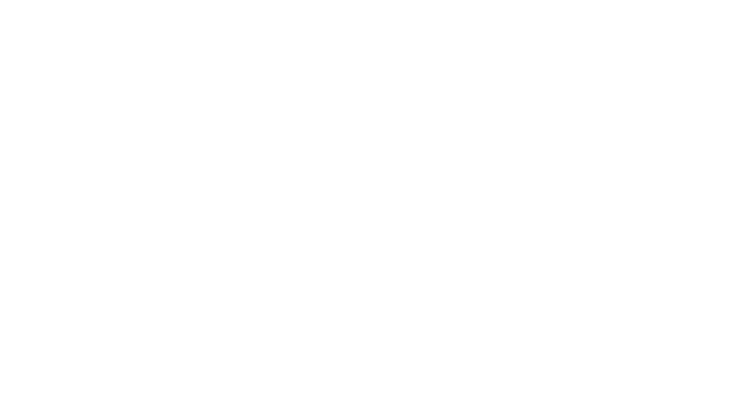

<IPython.core.display.Javascript object>


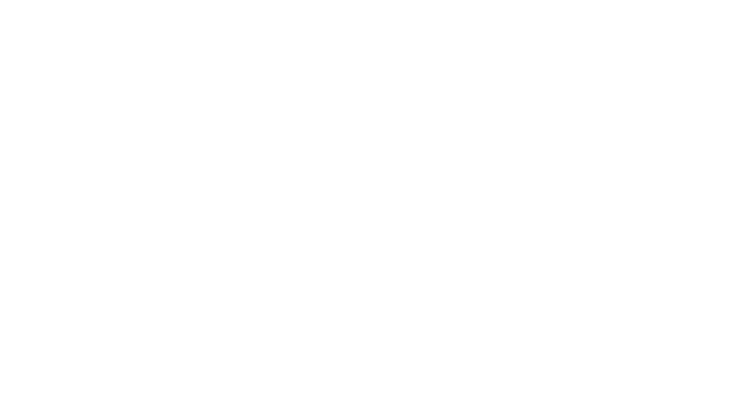

<IPython.core.display.Javascript object>


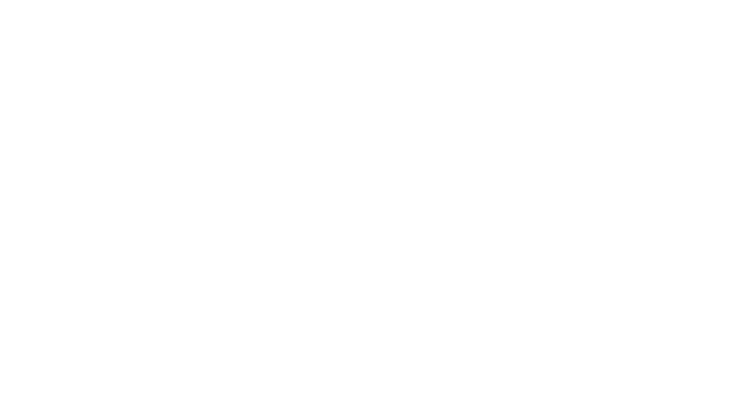

<IPython.core.display.Javascript object>


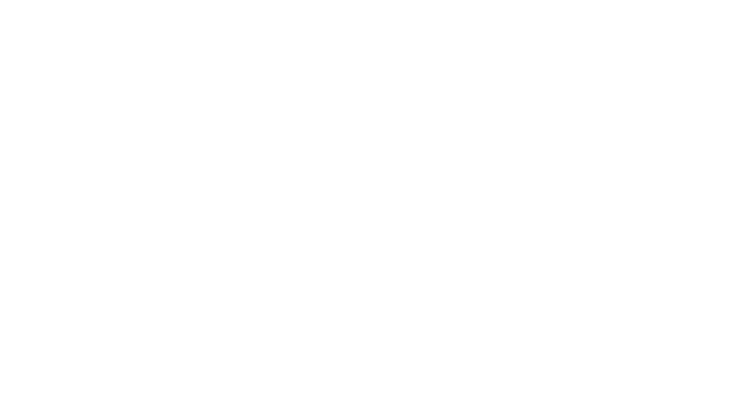

<IPython.core.display.Javascript object>


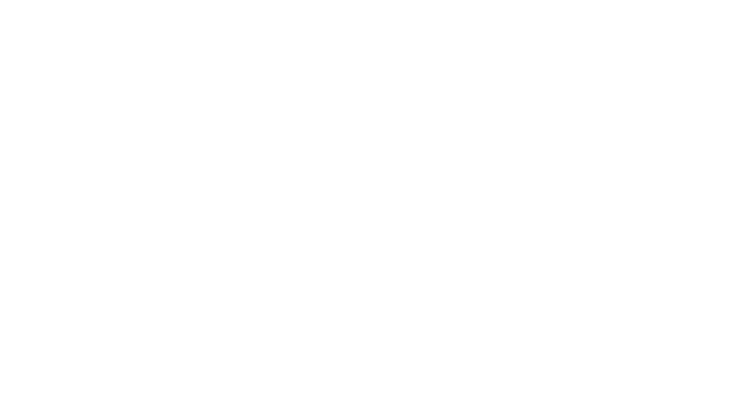

In [21]:
for station,label in stage_stations:
    fig=fig_waterlevel_bystation_timeseries(tidal_runs,station,label,chain=False)
    fig.savefig(os.path.join(fig_dir,f'tidal36h-stage-timeseries-2016-stn{station}.png'),
                dpi=150)

<IPython.core.display.Javascript object>


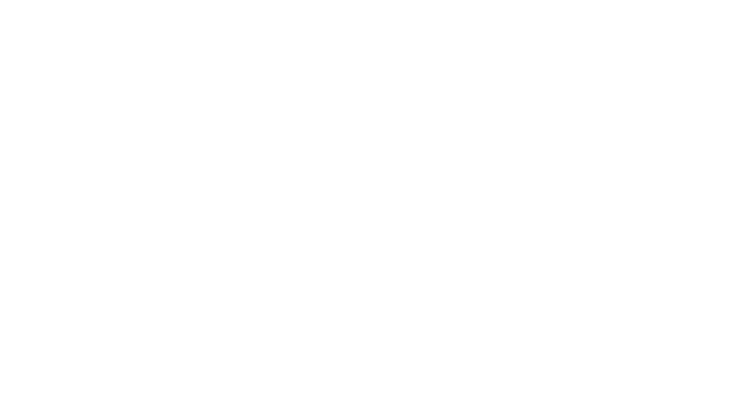

<IPython.core.display.Javascript object>


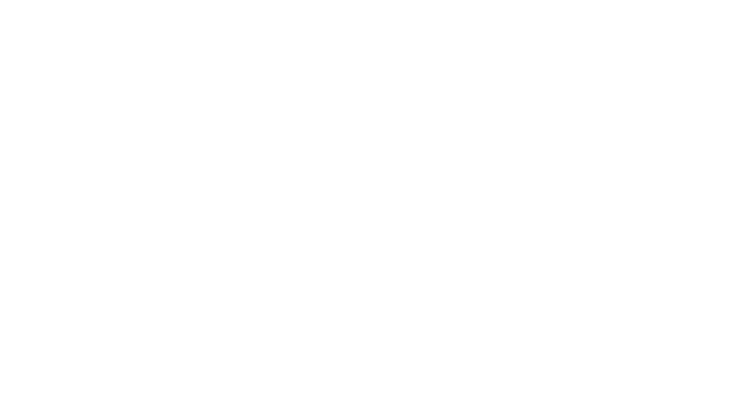

<IPython.core.display.Javascript object>


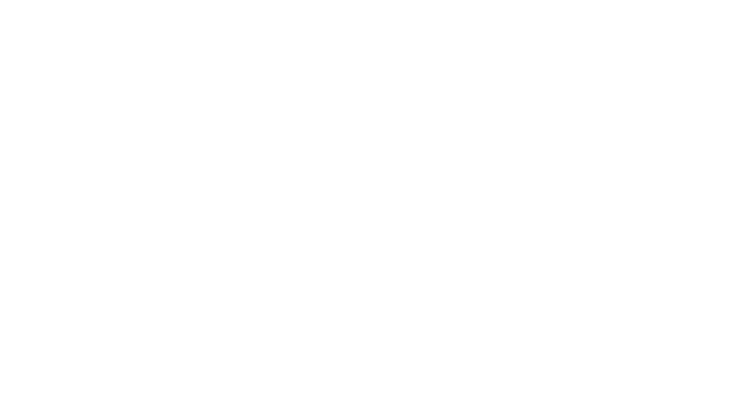

<IPython.core.display.Javascript object>


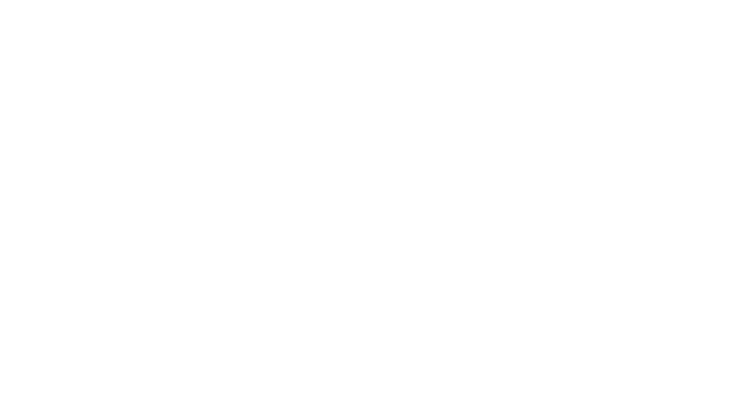

In [22]:
for _,rec in tidal_runs.iterrows():
    fig=fig_waterlevel_timeseries(rec,chain=False) 
    fig.savefig(os.path.join(fig_dir,f"tidal36h-stage-timeseries-2016-{rec['name']}.png"),
                dpi=150)

In [23]:
# Choose an ebb period and a flood period

# For the older runs:
#ebb_period=[np.datetime64('2016-08-04 06:30:00'),
#            np.datetime64('2016-08-04 13:30:00')]
#flood_period=[np.datetime64('2016-08-04 13:30:00'),
#              np.datetime64('2016-08-04 20:00:00')]

# For tidal runs based on 2016long:
ebb_period=[np.datetime64('2016-07-31 03:30:00'), # large ebb.
            np.datetime64('2016-07-31 11:00:00')]
flood_period=[np.datetime64('2016-07-31 11:00:00'),
              np.datetime64('2016-07-31 17:00:00')]


In [24]:
ebb_sels=[]
flood_sels=[]
grid=None

for _,rec in tidal_runs.iterrows():
    ds=rec['model'].map_dataset(grid=grid)
    grid=grid or ds.grid # so everybody matches the same grid
    ebb_sels.append( (ebb_period[0]<=ds.time.values)&(ds.time.values<=ebb_period[1]) )
    flood_sels.append( (flood_period[0]<=ds.time.values)&(ds.time.values<=flood_period[1]) )

tidal_runs['ebb_sel']=ebb_sels
tidal_runs['flood_sel']=flood_sels

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removin

INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

In [25]:
# Bed stress during breach:

# mean and max bed stress for each of the runs, for flood and ebb
class FigBedStress:
    zoom=[552085, 552647.,4124191, 4125112]
    figsize=None

    def __init__(self,mod,period_sel=slice(None),**kws):
        utils.set_keywords(self,kws)
        mds=mod.map_dataset(chain=False)

        tau=mds['mesh2d_taus'].isel(time=period_sel).values
        tau_max=np.nanmax(tau, axis=0)
        tau_mean=np.mean(tau,axis=0)
        self.fig,self.axs=plt.subplots(1,2,figsize=self.figsize)
        for ax,vals,label in zip(self.axs,
                                 [tau_max,tau_mean],
                                 ['Max. bed stress (Pa)','Mean bed stress (Pa)']):
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)

            ccoll=mds.grid.plot_cells(values=vals.clip(0.1),cmap='turbo',ax=ax,norm=colors.LogNorm())
            ccoll.set_clim([0.1,10])

            plt.colorbar(ccoll,ax=ax,label=label,pad=0.07,orientation='horizontal')
            ax.axis(self.zoom)
        self.fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.05,wspace=0.05,hspace=0.05)

# Compare mean bed stress, per tidal phase, between each scenario
# and the base
class FigBedStressChange(FigBedStress):
    map_dataset_kwargs={}
    def __init__(self,model_base,model_alt,period_sel=slice(None),**kws):
        utils.set_keywords(self,kws)
        ds_base=model_base.map_dataset()
        tau_base=ds_base['mesh2d_taus'].isel(time=period_sel).values
        tau_max_base =np.nanmax(tau_base, axis=0)
        tau_mean_base=np.mean(tau_base,axis=0)

        ds_alt=model_alt.map_dataset(grid=ds_base.grid,**self.map_dataset_kwargs)
        
        # Make sure the grid's are the same
        def check_match():
            cc_base=ds_base.grid.cells_center()
            cc_alt =ds_alt.grid.cells_center()
            valid_grid=np.allclose(cc_base,cc_alt)
            valid_time=np.all(ds_base.time.values==ds_alt.time.values)
            return valid_grid and valid_time
        
        if not check_match():
            print("Grids or times don't look the same. Will try reloading map_dataset")
            # Try reloading with forced grid:
            model_alt._mu=None
            ds_alt=model_alt.map_dataset(grid=ds_base.grid,**self.map_dataset_kwargs)
            assert check_match()
        
        tau_alt=ds_alt['mesh2d_taus'].isel(time=period_sel).values
        tau_max_alt=np.nanmax(tau_alt, axis=0)
        tau_mean_alt=np.mean(tau_alt,axis=0)
        self.fig,self.axs=plt.subplots(1,2)
        for ax,vals,label in zip(self.axs,
                                 [tau_max_alt-tau_max_base,
                                  tau_mean_alt-tau_mean_base],
                                 [r'$\Delta$ Max. bed stress (Pa)',
                                  r'$\Delta$ Mean bed stress (Pa)']):
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)

            ccoll=ds_alt.grid.plot_cells(values=vals,cmap='coolwarm',ax=ax,
                                         norm=colors.SymLogNorm(0.1,vmin=-5,vmax=5,base=10),
                                         lw=0.5,edgecolor='face')
            ccoll.set_clim([-2,2])

            plt.colorbar(ccoll,ax=ax,label=label,pad=0.07,orientation='horizontal')
            ax.axis(self.zoom)
        self.fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.05,wspace=0.05,hspace=0.05)

<IPython.core.display.Javascript object>


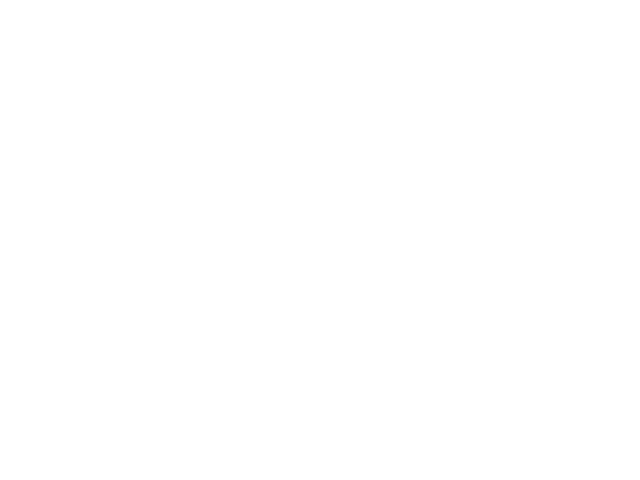

<IPython.core.display.Javascript object>


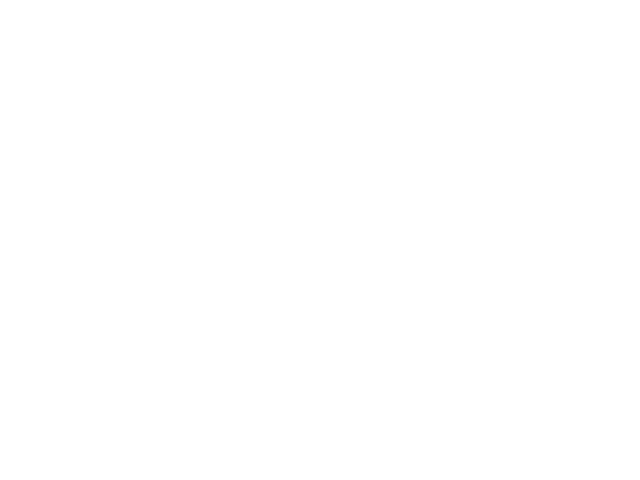

<IPython.core.display.Javascript object>


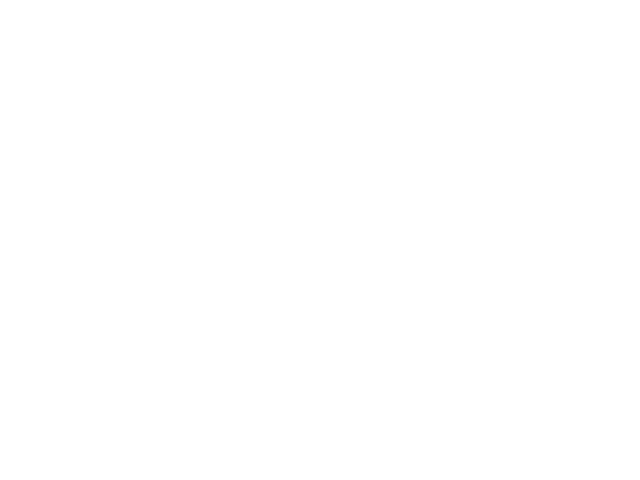

<IPython.core.display.Javascript object>


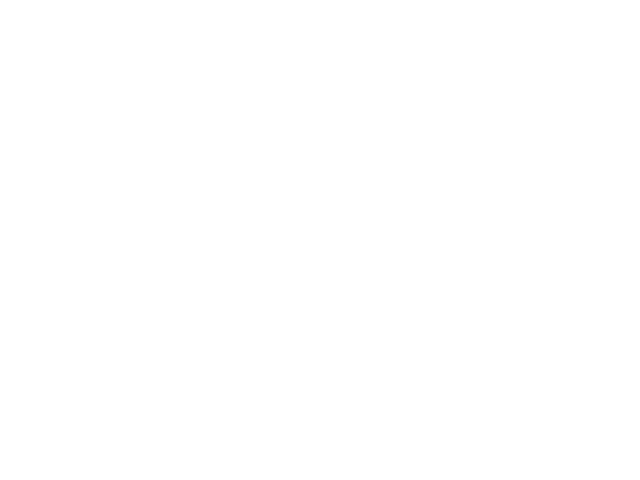

<IPython.core.display.Javascript object>


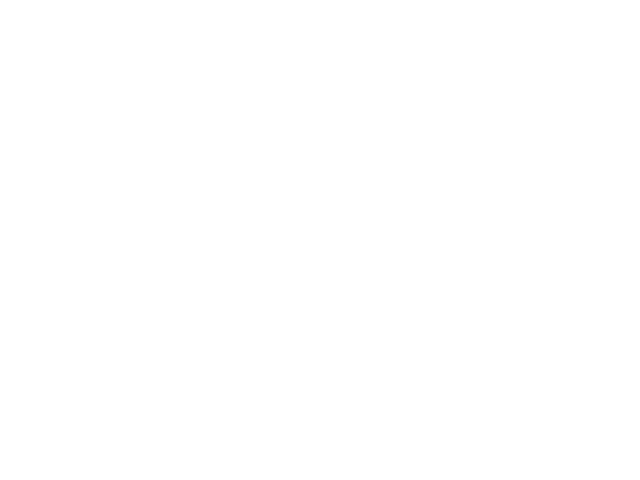

<IPython.core.display.Javascript object>


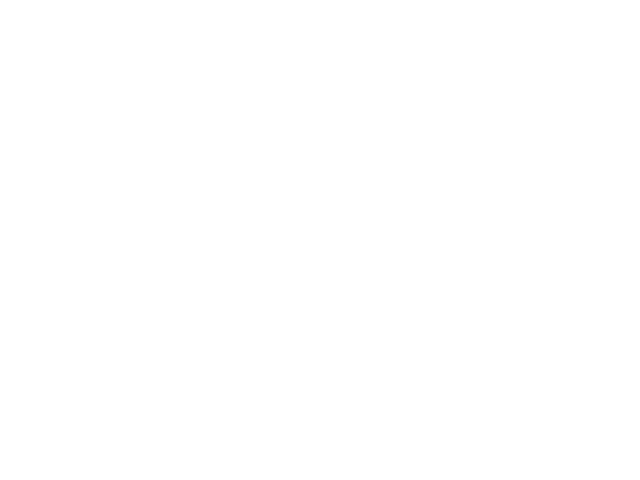

<IPython.core.display.Javascript object>


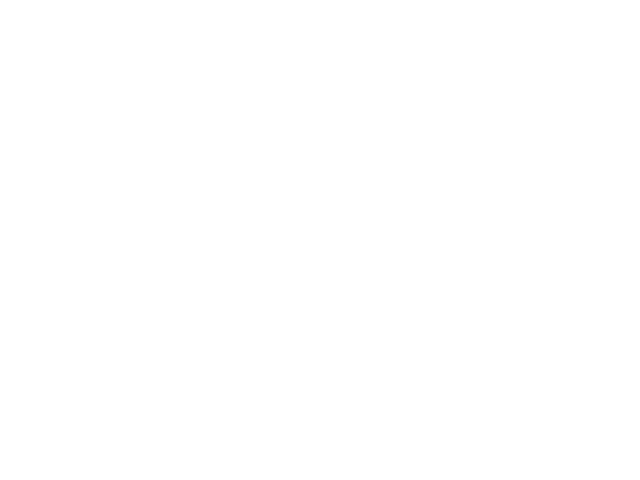

<IPython.core.display.Javascript object>


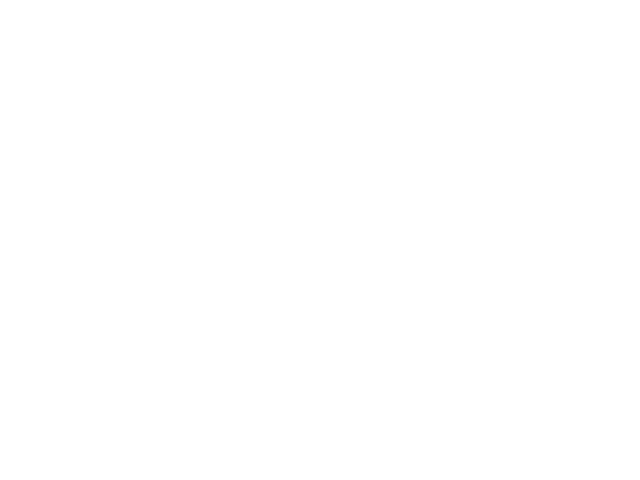

In [26]:
# mean and max bed stress for each of the runs, for flood and ebb
# during dev, Fig code is down in breach section.
for _,rec in tidal_runs.iterrows():
    for sel,period_name in [ (rec['ebb_sel'],'ebb'),
                             (rec['flood_sel'],'flood')]:
        fbs=FigBedStress(rec['model'],sel)
        fig.savefig(os.path.join(fig_dir,f"bed_stress-{rec['name']}-{period_name}.png"),dpi=200)    

<IPython.core.display.Javascript object>


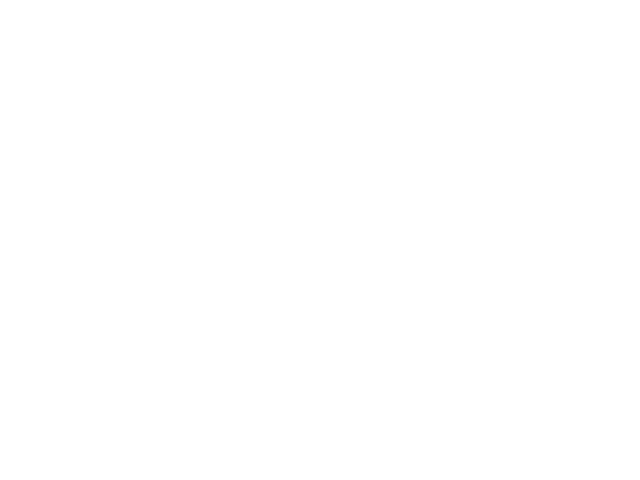

<IPython.core.display.Javascript object>


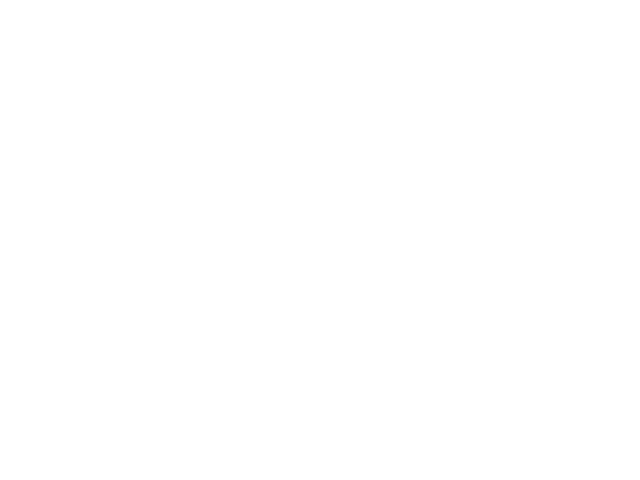

<IPython.core.display.Javascript object>


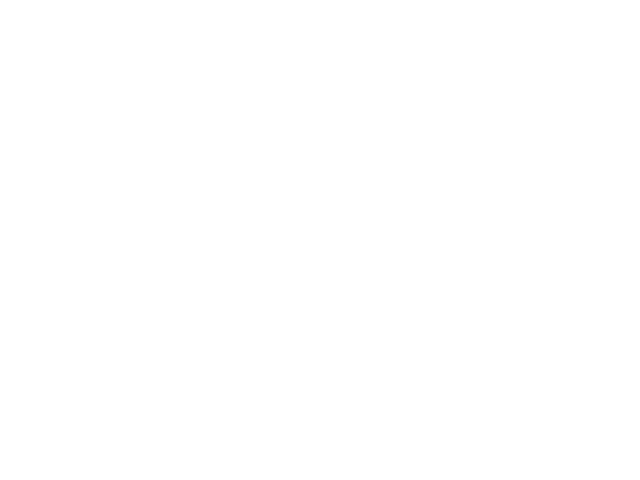

/home/rustyh/miniconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


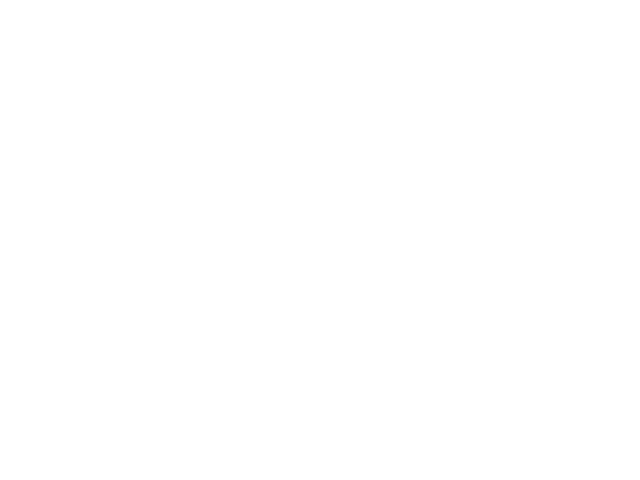

<IPython.core.display.Javascript object>


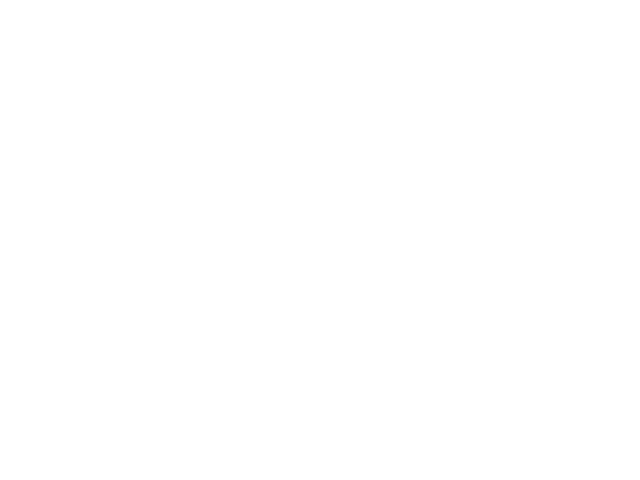

<IPython.core.display.Javascript object>


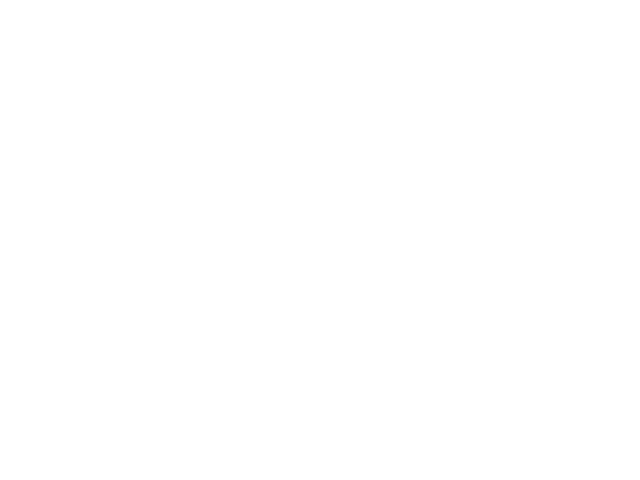

In [27]:
# Compare mean bed stress, per tidal phase, between each scenario
# and the base

rec_base=tidal_runs[ tidal_runs['name']=='Base'].iloc[0,:]

# During dev, FigBedStressChange 
for _,rec in tidal_runs.iterrows():
    if rec['name']=='Base': continue
    for period_sel,period_name in [(rec['ebb_sel'],'ebb'),
                                   (rec['flood_sel'],'flood')]:
        fbs=FigBedStressChange(rec_base['model'],rec['model'],period_sel=period_sel)
        fbs.fig.savefig(os.path.join(fig_dir,f"bed_stress-diff-{rec['name']}-{period_name}.png"),dpi=200)        

In [28]:
plt.close('all')

Tidal Prism Figures
---

NB: N Complex is flipped in the input.

In [29]:
# manually nudge so that lagged sections still recover ebb
ebb_time=ebb_period[0]+(ebb_period[1]-ebb_period[0])/2 + np.timedelta64(1,'h')

In [30]:
# Given a time and a history dataset, extract the prism from each cross-section
his_ds=tidal_runs.model.values[0].his_dataset()

In [31]:
# Updated runs shouldn't need this.
#section_flips=['n_complex_xs'] # who needs to be inverted due to gis feature
section_flips=[]


def phase_slice(his_ds,mid_time,section):
    flow=his_ds['cross_section_discharge'].sel(cross_section=section).values
    # use just the tidally varying portion to define tidal period.
    flow_anom=flow-flow.mean()
    ti_mid=np.searchsorted(his_ds.time.values,mid_time)
    flow_mid=flow_anom[ti_mid]
    ti_start=ti_mid
    while (flow_anom[ti_start-1]*flow_mid>0) and (ti_start>0): ti_start-=1
    ti_stop=ti_mid
    while (flow_anom[ti_stop]*flow_mid>0) and (ti_stop+1<len(flow)): ti_stop+=1
    return ti_start,ti_stop

def extract_volumes(his_ds,mid_time,timekeeper_section='mouth_xs'):
    prism_ds=xr.Dataset()
    prism_ds['cross_section']=his_ds.cross_section

    volumes=[]
    durations=[]
    volumes2=[] # calculated from cumulative discharge
    volumes_tidal=[]
    t_starts=[]
    t_stops=[]
    
    if timekeeper_section:
        ti_start,ti_stop = phase_slice(his_ds,mid_time,timekeeper_section)
        
    for i,section in enumerate(his_ds.cross_section.values):
        #print(section)
        if section in section_flips:
            sgn=-1
        else:
            sgn=1

        if not timekeeper_section:
            ti_start,ti_stop = phase_slice(his_ds,mid_time,section)
           
        flow=sgn*his_ds['cross_section_discharge'].sel(cross_section=section).values
        flow_anom=flow-flow.mean()
        
        t=his_ds.time.values
        dt=(t[2]-t[1])/np.timedelta64(1,'s')
        # print(f"History time step {dt}s")
        volume=flow[ti_start:ti_stop].sum() * dt
        volumes.append(volume)
        
        durations.append((t[ti_stop] - t[ti_start])/np.timedelta64(3600,'s'))
        Qnet=sgn*his_ds['cross_section_cumulative_discharge'].isel(cross_section=i).values
        volumes2.append(Qnet[ti_stop] - Qnet[ti_start])
        volumes_tidal.append( (flow_anom[ti_start:ti_stop]).sum()*dt)
        t_starts.append( t[ti_start])
        t_stops.append(t[ti_stop])

    prism_ds['volume']=('cross_section',),volumes
    prism_ds['volume'].attrs['units']='m3'
    prism_ds['vol_Qnet']=('cross_section',),volumes2
    prism_ds['vol_tidal']=('cross_section',),volumes_tidal
    prism_ds['duration_h']=('cross_section',),durations 
    prism_ds['t_start']=('cross_section',),t_starts
    prism_ds['t_stop'] =('cross_section',),t_stops
    return prism_ds

In [32]:
# Prism table:
prisms=[]
for tk in [None,'mouth_xs']:
    for _,row in tidal_runs.iterrows():
        ds=extract_volumes(row['model'].his_dataset(),ebb_time,timekeeper_section=tk)
        ds['run']=(),row['name']
        ds['timebase']=(),(tk or 'local')
        del ds['cross_section_name']
        del ds['vol_Qnet'] # was for debugging -- matches well.
        prisms.append(ds)
prisms_ds=xr.concat(prisms,dim='run')
prisms=prisms_ds.to_dataframe()
pd.set_option('display.max_rows', 200)
prisms

volume      vol_tidal  duration_h  \
cross_section    run                                                
mouth_xs         Base    161882.880996  150954.368065       11.25   
                 Low     149895.210323  136961.447653       11.25   
                 Medium  149899.328667  137036.808869       11.25   
                 High    150096.041362  137223.383253       11.25   
                 Base    161882.880996  150954.368065       11.25   
                 Low     149895.210323  136961.447653       11.25   
                 Medium  149899.328667  137036.808869       11.25   
                 High    150096.041362  137223.383253       11.25   
n_pond_xs        Base     32154.992024   33605.802386       11.75   
                 Low          1.311005       1.175862        1.00   
                 Medium       1.315760       1.182290        1.00   
                 High         0.003941       0.002875        0.50   
                 Base     22264.394047   23653.467797       11.25   
                 Low         -4.908605      -6.428961       11.25   
                 Medium      -4.971855      -6.473392       11.25   
                 High        -0.053352      -0.077319       11.25   
n_ditch_xs       Base      5164.989755    5205.719054       17.25   
                 Low         -0.251070      -0.194417        1.75   
                 Medium      -0.263028      -0.205927        1.75   
                 High         0.000000       0.000000        0.00   
                 Base      1020.848546    1047.411132       11.25   
                 Low          0.654651       1.018845       11.25   
                 Medium       0.667284       1.034359       11.25   
                 High         0.000000       0.000000       11.25   
n_complex_xs     Base     41328.847659   43353.741964       11.75   
                 Low         -0.002113       1.737467       28.50   
                 Medium      -0.002265       1.768554       28.50   
                 High         0.000000       0.000000        0.00   
                 Base     31846.304788   33785.033378       11.25   
                 Low          0.000000       0.686677       11.25   
                 Medium       0.000000       0.699007       11.25   
                 High         0.000000       0.000000       11.25   
pesca_mid_xs     Base     34681.455889   29339.279336       11.25   
                 Low      40233.584454   34166.714930       11.25   
                 Medium   40239.130856   34116.508947       11.25   
                 High     40205.376506   34128.248086       11.25   
                 Base     34681.455889   29339.279336       11.25   
                 Low      40233.584454   34166.714930       11.25   
                 Medium   40239.130856   34116.508947       11.25   
                 High     40205.376506   34128.248086       11.25   
butano_lower_xs  Base     50239.431499   52998.706370       11.25   
                 Low      51821.198915   48468.625123       11.25   
                 Medium   51841.321105   48466.160643       11.25   
                 High     51831.361471   48454.346114       11.25   
                 Base     50239.431499   52998.706370       11.25   
                 Low      51821.198915   48468.625123       11.25   
                 Medium   51841.321105   48466.160643       11.25   
                 High     51831.361471   48454.346114       11.25   
pesca_lower_xs   Base     76521.800802   65983.947216       11.50   
                 Low      56995.578816   50820.856075       11.25   
                 Medium   57033.120573   50838.064569       11.25   
                 High     56978.304865   50813.870355       11.25   
                 Base     75988.747416   65679.977604       11.25   
                 Low      56995.578816   50820.856075       11.25   
                 Medium   57033.120573   50838.064569       11.25   
                 High     56978.304865   50813.870355       11.25   
pesca_bc_xs      Base      352

In [33]:
# select and label cross sections
section_sel={'mouth_xs':'Mouth',
             'n_complex_xs':'NM Complex',
             'n_ditch_xs':'NM N Ditch',
             'n_pond_xs':'N Pond',
             #'butano_lower_xs':'Butano Ck',
             'butano_wide':'Butano Ck',
             #'pesca_lower_xs':'Pescadero@Jct',
             #'pesca_mid_xs':'Pescadero Ck',
             'pesca_wide':'Pescadero Ck'
            }
# I think just for debugging
sec_station_sel={'butano_lower_xs':'bc1',
                 'mouth_xs':'mid_mouth', # upstream side
                 'n_ditch_xs':'nmc_down', # or nmc_up?
                 'n_complex_xs':'pch_up', # upstream side of culverts
                 'n_pond_xs':'npc',
                 'pesca_mid_xs':'pch_down', # not great
                 'pesca_wide':'pch_down',
                 'butano_wide':'bc1'
                }


In [34]:

for tbase in prisms['timebase'].unique():
    print("Time base",tbase)
    df=prisms[ prisms['timebase']==tbase]
    df=df['volume'].unstack().reset_index()
    df=df[ df.cross_section.isin(section_sel)].copy()

    df['Cross section']=df['cross_section'].map(section_sel)

    df=df.set_index('Cross section')
    del df['cross_section']
    df.to_csv(os.path.join(fig_dir,f"ebb-prisms-timebase_{tbase}.csv"))

    # Just for display:
    for col in df.columns:
        df[col]=df[col].apply(lambda s: "%.0f"%s)
    display(df)

Time base local


run              Base    High     Low  Medium
Cross section                                
Butano Ck       55507   63570   63536   63578
Mouth          161883  150096  149895  149899
NM Complex      41329       0      -0      -0
NM N Ditch       5165       0      -0      -0
N Pond          32155       0       1       1
Pescadero Ck    34544   40043   40069   40079

Time base mouth_xs


run              Base    High     Low  Medium
Cross section                                
Butano Ck       55507   63570   63536   63578
Mouth          161883  150096  149895  149899
NM Complex      31846       0       0       0
NM N Ditch       1021       0       1       1
N Pond          22264      -0      -5      -5
Pescadero Ck    34544   40043   40069   40079

When ebb prisms are calculated with the period of ebb decided locally
then we can't turn around and attempt a mass balance across sections.

When all sections are evaluated with the same time base, from a designated
"timekeeper" section, the mass balance is appropriate.

The second table shows that in the scenarios Butano ebbs 8k more, Pescadero
ebbs 5500 more, and the North Marsh contribution is cut from 32k to zero. Net,
there is 18,500 m$^3$ less flow entering the lagoon. There is also 12k less flow
out of the lagoon. The difference, 6k, is because the tidal range increases
in the scenarios.

In [35]:
plt.close('all')

Tidal Cross Section Map
--

In [36]:
from stompy.plot import plot_wkb
mds=tidal_runs.model.values[0].map_dataset()
# there was a hopefully transient issue with cross sections in run 0,
# so pull from run 1
his=tidal_runs.model.values[1].his_dataset()

<IPython.core.display.Javascript object>


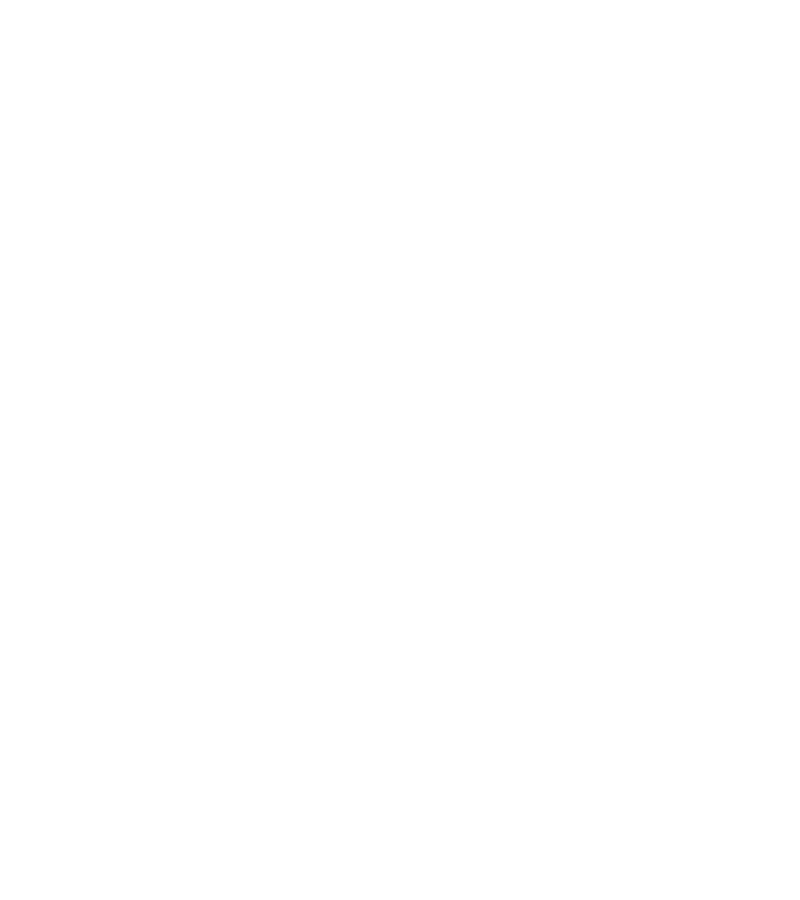

In [37]:
from stompy import filters

fig,ax=plt.subplots(figsize=(8,9))
ax.set_adjustable("datalim")
tidx=20 # start of ebb period
#depth=mds['mesh2d_waterdepth'].isel(time=tidx)
elev=mds['mesh2d_flowelem_bl']
ccoll=mds.grid.plot_cells(values=elev,ax=ax,cmap='terrain')

colors=['k','r','b','orange','magenta','green','brown','purple']
    
for sec in his.cross_section:
    sec=sec.item()
    if sec not in section_sel: continue
    geom=his.cross_section_geom.sel(cross_section=sec).values.item()
    coords=np.array(geom.coords)
    coords[1:-1] = filters.lowpass_fir(coords,3,axis=0)[1:-1]
    color=colors.pop(0)
    #plot_wkb.plot_wkb(geom,color=color,lw=2)
    ax.plot(coords[:,0],coords[:,1],color=color,lw=2)
    mid=np.array(geom.interpolate(0.5,normalized=True).coords)[0]
    ax.text(mid[0],mid[1],' ' +section_sel[sec] )
ccoll.set_clim(0,5.)
ax.xaxis.set_visible(0)
ax.yaxis.set_visible(0)
fig.tight_layout()
ax.axis((552046., 552657., 4124176., 4124890.))
fig.savefig(os.path.join(fig_dir,'cross_section_map.png'),dpi=200)

In [38]:
plt.close('all')

Freshening
----

Time for depth-averaged salinity to reach 5ppt, after closure.

In [39]:
fresh_runs=runs

In [40]:
t_close=np.datetime64("2016-08-11 00:00")

In [41]:
if 0:
    # When did it close?  Hopefully all of the runs will use the same starting
    # time, so we can reuse the closure timing
    # 8-09 might be closer?
    his_ds=fresh_runs.model.values[0].his_dataset()
    nck=his_ds.waterlevel.sel(stations='nck')
    fig,ax=plt.subplots()
    ax.plot(nck.time, nck)
    ax.axvline(t_close,color='tab:red')
    fig.autofmt_xdate()

In [42]:
print("Days after closure of mini-breach",(np.datetime64('2016-11-01') - t_close)/np.timedelta64(1,'D'))
print("Days after closure of large breach",(np.datetime64('2016-12-11') - t_close)/np.timedelta64(1,'D'))

Days after closure of mini-breach 82.0
Days after closure of large breach 122.0


In [43]:
from stompy.grid import ugrid
six.moves.reload_module(ugrid)

def scal_davg(mds,ti,scal):
    snap=mds.isel(time=ti)
    values=snap[scal].values
    
    ug=ugrid.UgridXr(snap,layer_dim='mesh2d_nLayers',face_eta_vname='mesh2d_s1',
                     layer_vname='mesh2d_layer_z')
    weights=ug.vertical_averaging_weights(ztop=0,zbottom=0)
    davg=np.nansum(weights*values,axis=1)
    dry=np.all(np.isnan(weights),axis=1)
    davg[dry]=np.nan
    return davg

def s_davg(mds,ti):
    return scal_davg(mds,ti,'mesh2d_sa1')

def calc_days_to_freshen(mod,t_close,s_thresh=5.0):
    mds=mod.map_dataset(chain=True)
    # Extra layer to roughly cache results, but update if new output is available.
    # Assumes we're going to load the map_dataset() regardless.
    return real_calc_days_to_freshen(mod,t_close,s_thresh,mds.time.values[-1])

@memoize.memoize(cache_dir='cache',key_method='str') # untested.
def real_calc_days_to_freshen(mod,t_close,s_thresh,t_end):    
    mds=mod.map_dataset(chain=True)
    ti_close=np.searchsorted(mds.time.values,t_close)
    t_fresh=np.nan*np.ones(mds.grid.Ncells())
    time_vals=mds.time.values
    t0=time_vals[ti_close]

    # HERE - need chaining logic.
    for ti in range(ti_close,mds.dims['time']):
        #print(f"{ti}/{mds.dims['time']}", end='  ')    
        print(".",end="")
        salt_i=s_davg(mds,ti)
        fresh=(salt_i<s_thresh) & np.isnan(t_fresh)
        t_fresh[fresh]=(time_vals[ti]-t0)/np.timedelta64(86400,'s')
    return t_fresh

In [44]:
# Survey initial, depth-averaged salinity field
def figure_salinity(mod,t=t_close,label=None):
    mds=mod.map_dataset(chain=True)
    ti_close=np.searchsorted(mds.time.values,t)
    if t < mds.time.values[0]:
        # HERE -- add some restart chaining logic
        logging.warning("Output starts after the requested time")
    salt0=s_davg(mds,ti_close)

    fig,ax=plt.subplots(figsize=(7.2,4.75))
    ax.set_adjustable('datalim')
    ccoll=mds.grid.plot_cells(values=salt0,cmap='turbo',clim=[0,34])
    bgcoll=mds.grid.plot_cells(mask=np.isnan(salt0),color='0.85',zorder=-2,lw=0.5,edgecolor='face')

    ax.axis('off')
    #zoom=[551953., 553097.,4124145., 4125066.]
    zoom=[551951., 553291., 4124136., 4125020.]
    ax.axis(zoom)
    cax=fig.add_axes([0.55,0.9,0.40,0.03])
    cbar=plt.colorbar(ccoll,cax=cax,orientation='horizontal',label='psu')
    fig.subplots_adjust(left=0.0,right=1.0,top=1.0,bottom=0.0)
    if label:
        ax.text(0.02,0.9,label,transform=ax.transAxes)
    return fig

Base


INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)


<IPython.core.display.Javascript object>


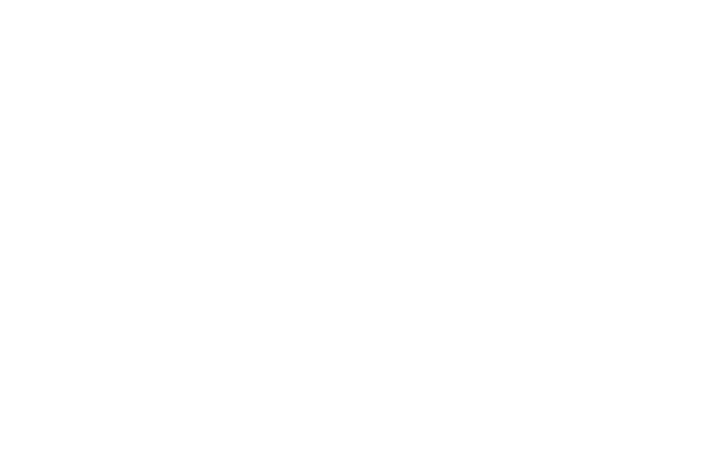

Low


INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)


<IPython.core.display.Javascript object>


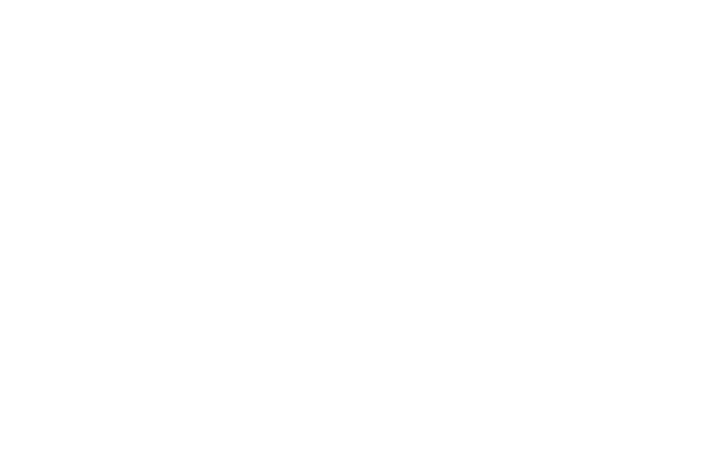

Medium


INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)


<IPython.core.display.Javascript object>


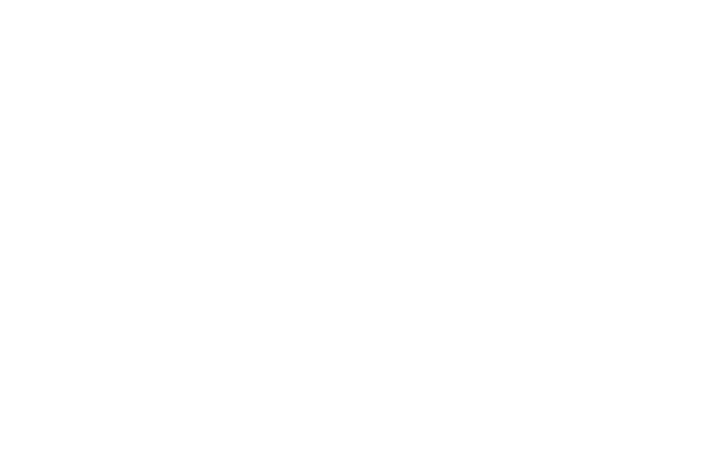

High


INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)


<IPython.core.display.Javascript object>


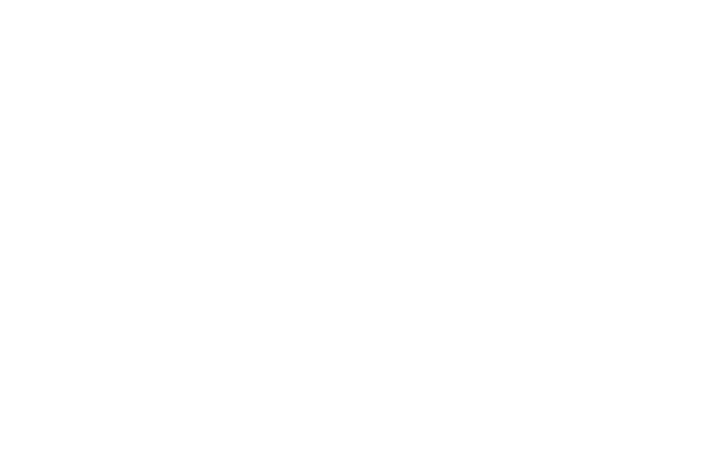

In [45]:
t_initial=np.datetime64('2016-07-01 00:00') # correct for period=2016long 

for _,run in fresh_runs.iterrows():
    print(run['name'])
    mapds=run['model'].map_dataset(chain=True)
    fig=figure_salinity(run['model'],t=t_initial,label=run['name'])
    fig.savefig(os.path.join(fig_dir,f'salinity-davg-initial-{run["name"]}.png'),
               dpi=200)

Base


<IPython.core.display.Javascript object>


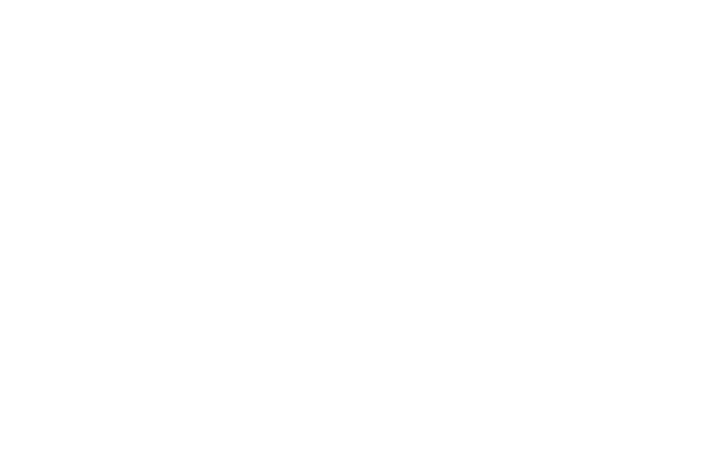

Low


<IPython.core.display.Javascript object>


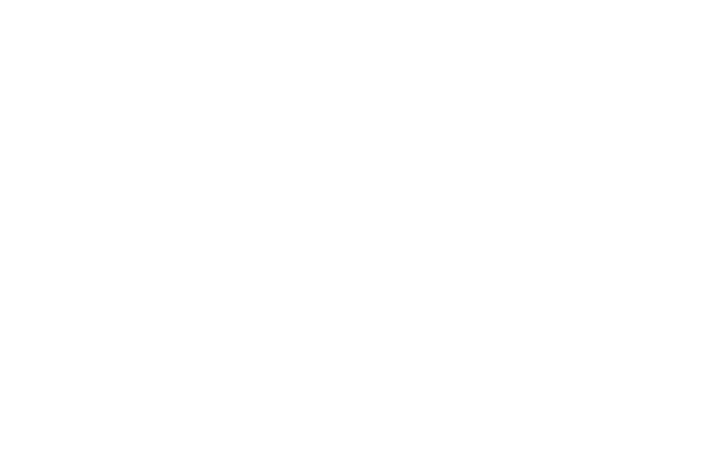

Medium


<IPython.core.display.Javascript object>


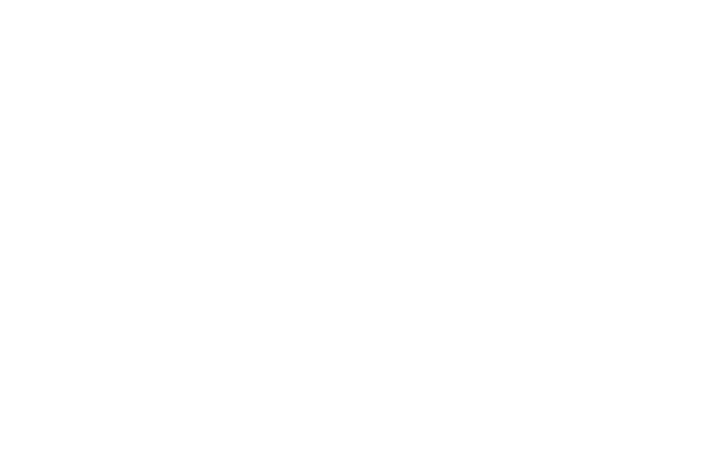

High


<IPython.core.display.Javascript object>


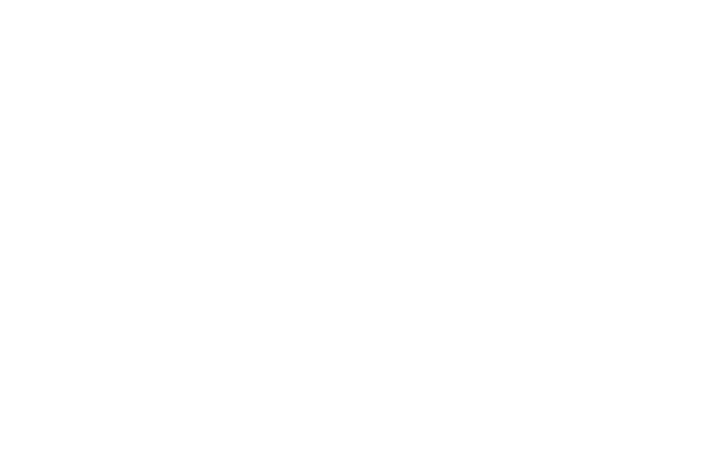

In [46]:
for _,run in fresh_runs.iterrows():
    print(run['name'])
    mapds=run['model'].map_dataset()
    t_stop=mapds.time.values[-1]
    t_stop_label=utils.to_datetime(t_stop).strftime('%Y-%m-%d')
    fig=figure_salinity(run['model'],t=t_stop,label=f"{run['name']} {t_stop_label}")
    fig.savefig(os.path.join(fig_dir,f'salinity-davg-final-{run["name"]}.png'),
               dpi=200)                

Base


<IPython.core.display.Javascript object>


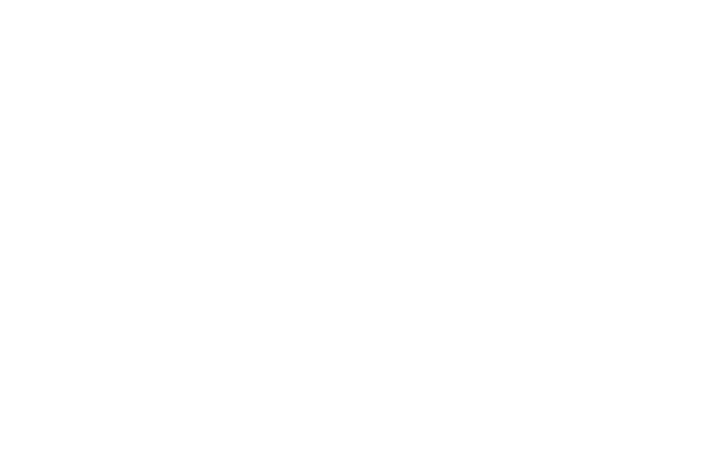

Low


<IPython.core.display.Javascript object>


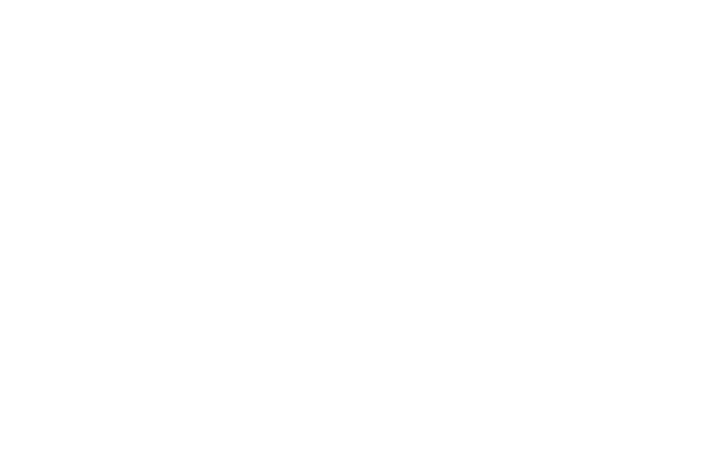

Medium


<IPython.core.display.Javascript object>


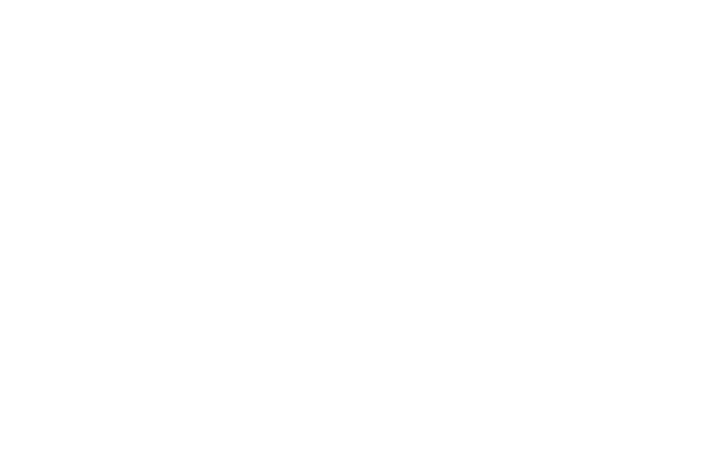

High


<IPython.core.display.Javascript object>


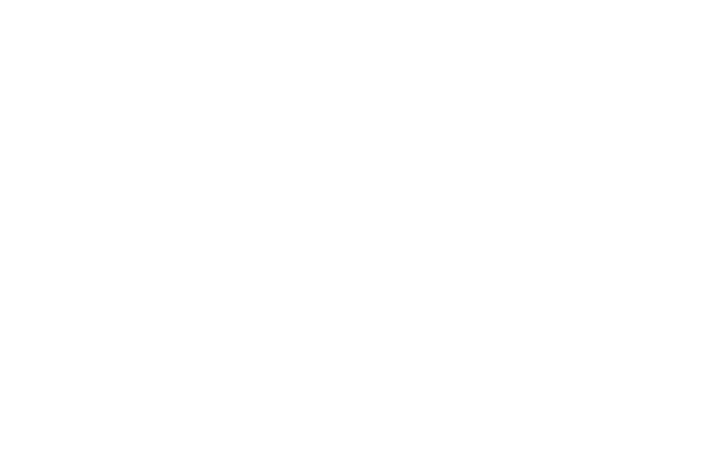

In [47]:
for _,run in fresh_runs.iterrows():
    print(run['name'])
    fig=figure_salinity(run['model'],t=t_close,label=run['name'])
    fig.savefig(os.path.join(fig_dir,f'salinity-davg-at_closure-{run["name"]}.png'),
               dpi=200)
    

In [48]:
def fig_freshen(rec,t_close=t_close,max_days=160):
    mod=rec['model']
    mds=mod.map_dataset(chain=True)
    duration_days=(mds.time.values[-1]-t_close)/np.timedelta64(1,'D')
    print(f"Days to freshen from closure {t_close} to end of run {mds.time.values[-1]} ({duration_days:.1f}d)")

    t_fresh=calc_days_to_freshen(mod,t_close)
    fig,ax=plt.subplots()
    ax.set_adjustable('datalim')
    mds.grid.plot_cells(color='0.65',zorder=-1)
    ccoll=mds.grid.plot_cells(values=t_fresh,mask=np.isfinite(t_fresh),cmap='turbo',zorder=1)
    ax.xaxis.set_visible(0)
    ax.yaxis.set_visible(0)
    fig.subplots_adjust(left=0.03,right=0.97,top=0.98,bottom=0.02)
    cax=fig.add_axes([0.05,0.08,0.03,0.45])
    plt.colorbar(ccoll,cax=cax,label="days")
    ccoll.set_clim([0,max_days])
    zoom=[551894., 553097.,4124145., 4125066.]
    ax.axis(zoom)
    return fig

Base
Days to freshen from closure 2016-08-11T00:00 to end of run 2017-02-28T00:00:00.000000000 (201.0d)
.....................................................................................................

<IPython.core.display.Javascript object>


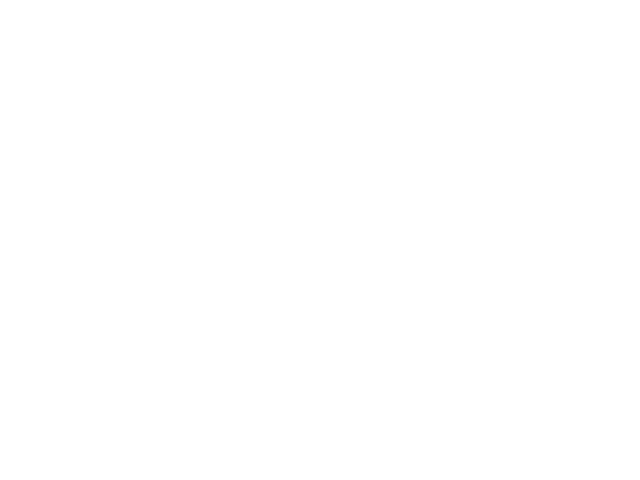

Low
Days to freshen from closure 2016-08-11T00:00 to end of run 2017-02-28T00:00:00.000000000 (201.0d)
.....................................................................................................

<IPython.core.display.Javascript object>


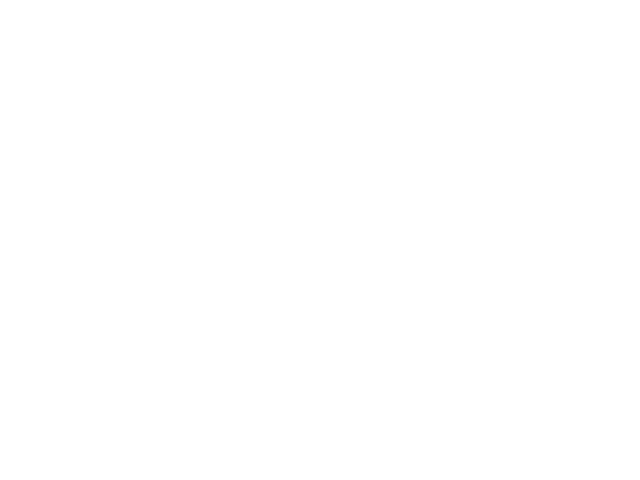

Medium
Days to freshen from closure 2016-08-11T00:00 to end of run 2017-02-28T00:00:00.000000000 (201.0d)
.....................................................................................................

<IPython.core.display.Javascript object>


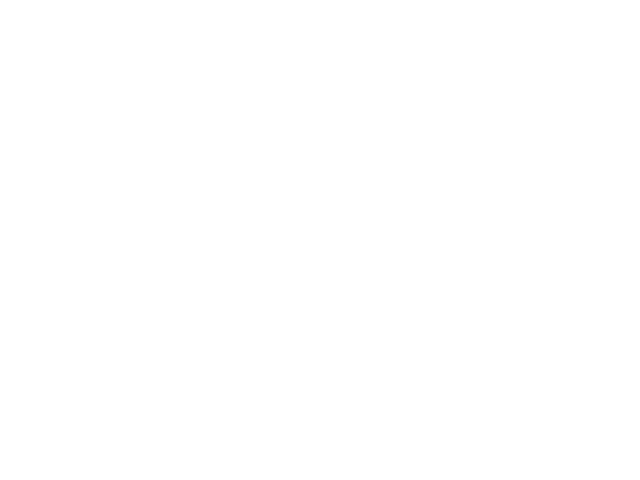

High
Days to freshen from closure 2016-08-11T00:00 to end of run 2017-02-28T00:00:00.000000000 (201.0d)
.....................................................................................................

<IPython.core.display.Javascript object>


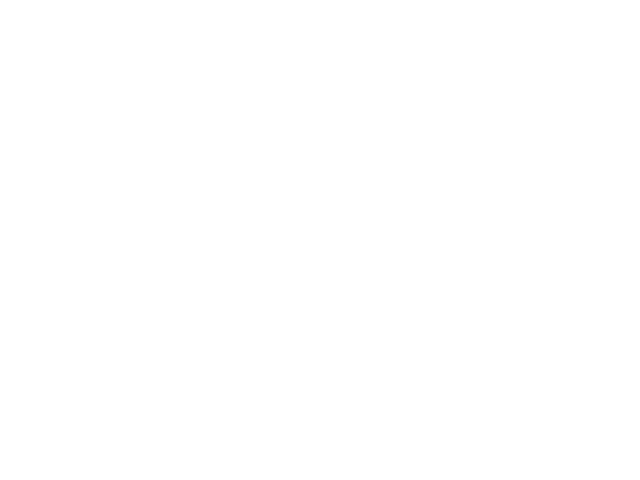

In [49]:
for _,rec in fresh_runs.iterrows():
    print(rec['name'])
    fig=fig_freshen(rec)
    fig.savefig(os.path.join(fig_dir,f"t_fresh-{rec['name']}-{rec['flows']}-{rec['period']}.png"),
                dpi=200)

Do the freshening figures make sense?

* note that not all runs have made it to the same time. Will now print out the period.
* what about the dark blue cells? Maybe fixed with some updates to ugrid.py.

In [50]:
plt.close('all')

In [51]:
# Habitat: time series of area in NM that is wet and <5, <10 ppt depth-max salinity
from stompy import memoize, utils
from stompy.spatial import wkb2shp

@memoize.memoize(key_method='str',cache_dir='cache')
def fresh_wet_area(mod,thresholds,min_depth=0.1,region_names=None,
                   poly_shp="../grids/pesca_butano_v08/polygon_features.shp"):
    #mod=rec['model']
    mds=mod.map_dataset(chain=True)

    features=wkb2shp.shp2geom("../grids/pesca_butano_v08/polygon_features.shp")
    polys=[]
    for name in region_names:
        sel=(features['type']=='dye')&(features['desc']==name)
        poly=features['geom'][sel]
        assert len(poly)==1
        polys.append( poly[0] )
    
    result=xr.Dataset()
    result['time']=mds.time.compute()
    result['min_depth']=(),min_depth
    result['thresholds']=('threshold',),thresholds
    if region_names is None:
        result['region']=('region',),np.arange(len(polys))
    else:
        result['region']=('region',),region_names
        
    result['poly_area']=('region',),[poly.area for poly in polys]

    Ac=mds.grid.cells_area()

    poly_masks=[mds.grid.select_cells_intersecting(poly)
                for poly in polys]
    
    # previously used the polygon, but that's an overestimate
    result['region_area']=('region',),[Ac[mask].sum() for mask in poly_masks]

    areas=np.zeros( (mds.dims['time'],len(thresholds),len(polys)),np.float64)
    for ti,t in enumerate(mds.time.values):
        print(f"{ti}/{mds.dims['time']}")
        salt=mds['mesh2d_sa1'].isel(time=ti).values
        depth=mds['mesh2d_waterdepth'].isel(time=ti).values
        salt_max=np.nanmax(salt,axis=1)
        
        for thresh_i,threshold in enumerate(thresholds):
            for region_i,poly_mask in enumerate(poly_masks):
                valid=poly_mask & np.isfinite(salt_max) & (salt_max<threshold) & (depth>=min_depth)
                area=Ac[valid].sum()
                areas[ti,thresh_i,region_i]=area

    result['habitat']=('time','threshold','region'),areas
    return result

Base


<IPython.core.display.Javascript object>


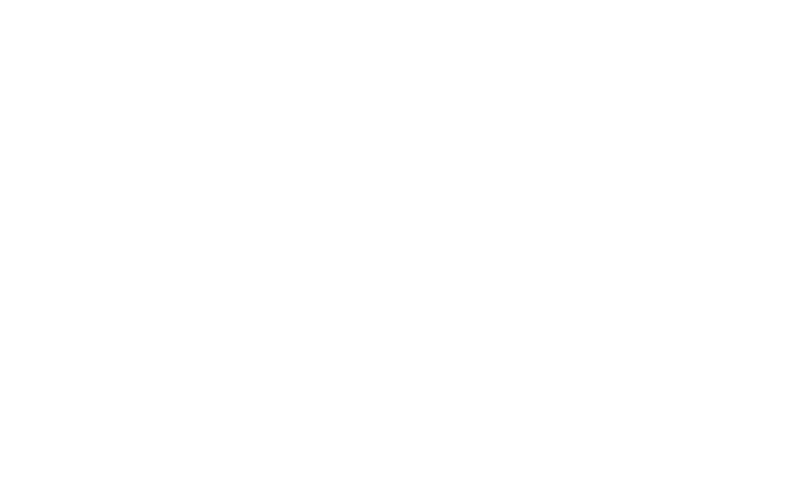

Low


<IPython.core.display.Javascript object>


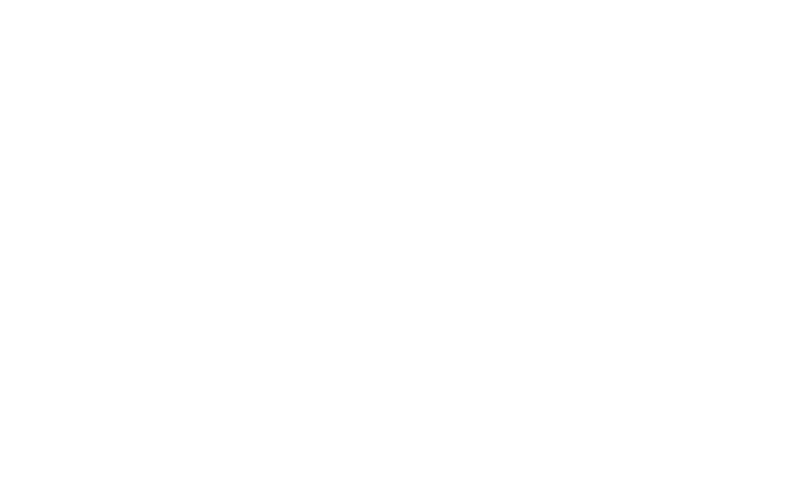

Medium


<IPython.core.display.Javascript object>


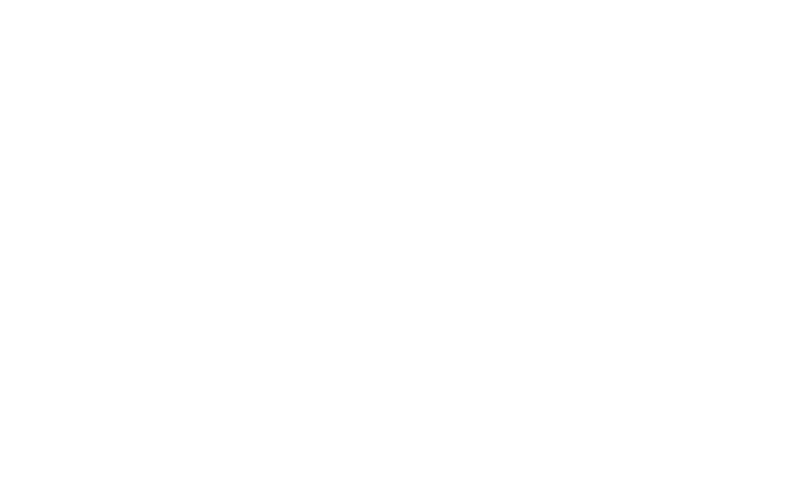

High


<IPython.core.display.Javascript object>


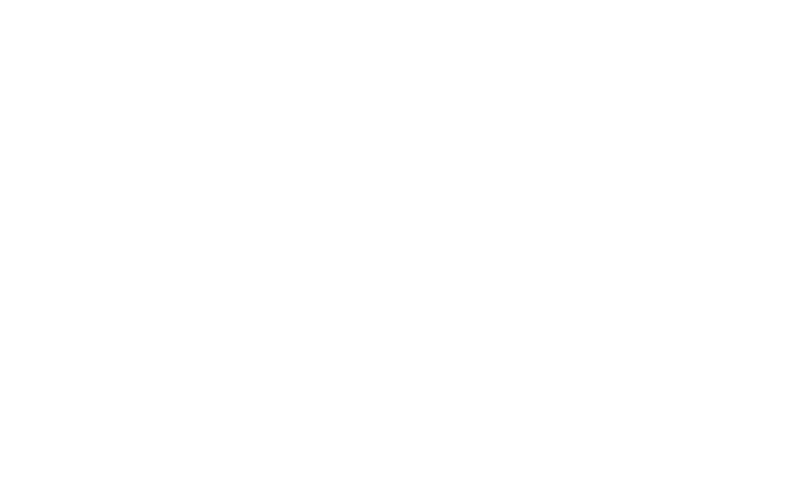

In [52]:
def fig_habitat(result):
    fig,axs=plt.subplots(2,1,sharex=True,figsize=(8,5))

    for region in range(result.dims['region']):
        ax=axs[region]
        ax.text(0.02,0.98,result['region'].values[region],va='top',transform=ax.transAxes)
        for thrsh in range(result.dims['threshold']):
            area=result.habitat.isel(threshold=thrsh,region=region)
            percent=100*area/result.region_area.values[region]
            thresh_val=result.thresholds.values[thrsh]
            if np.isfinite(thresh_val):
                label=f"<{thresh_val} ppt"
            else:
                label='wet'
            ax.plot(result.time, percent, label=label)
    fig.autofmt_xdate()
    for ax in axs:
        ax.set_ylabel('% wet and fresh')
        label_events(ax) # may need tweaking, or hide text on first ax.
    axs[0].legend(loc='upper left',bbox_to_anchor=[1.02,1],frameon=False)
    fig.subplots_adjust(left=0.1,right=0.82,top=0.97,bottom=0.13)
    return fig
    
# Get the polygons for marsh and pond
region_names=['marsh','pond']

for _,rec in fresh_runs.iterrows():
    print(rec['name'])
    result=fresh_wet_area(rec['model'],[5,10,np.inf],region_names=region_names)
    fig=fig_habitat(result)
    fig.savefig(os.path.join(fig_dir,f"habitat-{rec['name']}-{rec['flows']}-{rec['period']}.png"),
                dpi=200)
    
    

In [53]:
plt.close('all')

Breach
--

In [54]:
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
breachruns=all_runs[(all_runs.layers==100) 
                     &(all_runs.slr==0.0) 
                     &(all_runs.period=='2016breach') 
             ].copy()
breachruns['name']=breachruns.scen.map(scen_names)
breachruns

run_dir  scen  layers  slr  \
24  data_2016long_3d_asbuilt_impaired_scen0_l100-v...     0     100  0.0   
25  data_2016long_3d_asbuilt_impaired_scen1_l100-v...     1     100  0.0   
26  data_2016long_3d_asbuilt_impaired_scen2_l100-v...     2     100  0.0   
27  data_2016long_3d_asbuilt_impaired_scen3_l100-v...     3     100  0.0   

        period     status     flows    name  
24  2016breach  completed  impaired    Base  
25  2016breach  completed  impaired     Low  
26  2016breach  completed  impaired  Medium  
27  2016breach  completed  impaired    High

In [55]:
breachruns['model']=breachruns.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))

In [56]:
# First, just see what the tracer looks like
#mod=runs['model'].values[0]
#mds=mod.map_dataset()

In [57]:
# Choose a few key moments in time for snapshots
# these runs go from 2016-12-08 to 2016-12-16
def fig_tracer_snapshots(mod,tracer='marsh',
                            times=[np.datetime64("2016-12-09"),
                                   np.datetime64("2016-12-12"),
                                   np.datetime64("2016-12-14")]):
    his=mod.his_dataset()
    mds=mod.map_dataset()

    fig,axs=plt.subplots(1,len(times),figsize=[8.3,3.4])
    fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.02,wspace=0.03)

    # one time series 
    ax_t=fig.add_axes([0.03,0.06,0.3,0.14])
    ax_t.plot( his.time, his.waterlevel.sel(stations='nck'))
    ax_t.axis(xmin=his.time.values[0],xmax=his.time.values[-1])
    ax_t.xaxis.set_visible(0)
    ax_t.yaxis.set_visible(0)
    zoom=[551951., 553291., 4124136., 4125020.]

    for t,ax,label in zip(times,axs,"abcdefgh"):
        ax.set_adjustable('datalim')
        ax.xaxis.set_visible(0)
        ax.yaxis.set_visible(0)

        tidx=np.searchsorted(mds.time.values,t)
        ax_t.axvline(mds.time.values[tidx],color='0.5',lw=1.5)

        scal=scal_davg(mds,tidx,'mesh2d_'+tracer)
        ccoll=mds.grid.plot_cells(values=scal,cmap='turbo',lw=0.4,edgecolor='face',
                                  ax=ax)
        ccoll.set_clim([0,1])
        ax.axis(zoom)
        ax.text(0.02,0.98,f"({label})",va='top',transform=ax.transAxes)
        ax.axis('off')

    p0=axs[0].get_position()
    p1=axs[1].get_position()
    cax=fig.add_axes([p0.xmax-0.4*p0.width,0.82,p0.width*0.6,0.04])
    plt.colorbar(ccoll,cax=cax,label=f"{tracer} dye tracer",orientation='horizontal')
    return fig

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)


<IPython.core.display.Javascript object>


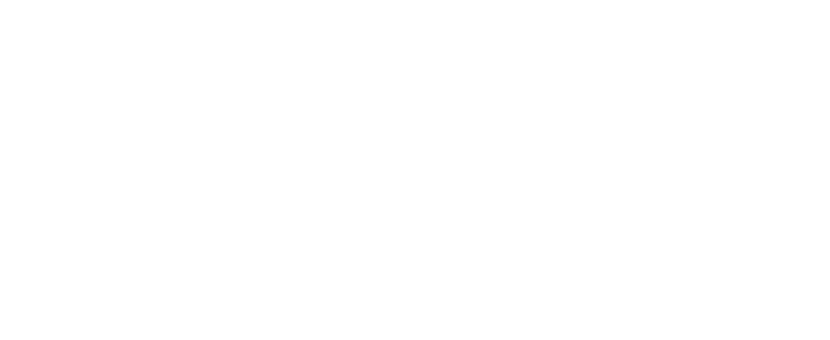

<IPython.core.display.Javascript object>


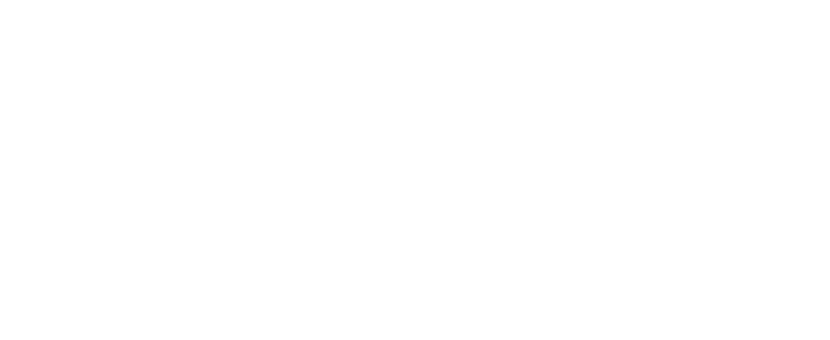

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)


<IPython.core.display.Javascript object>


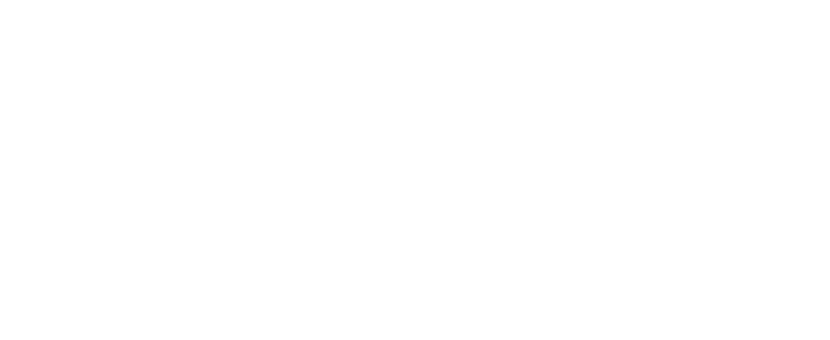

<IPython.core.display.Javascript object>


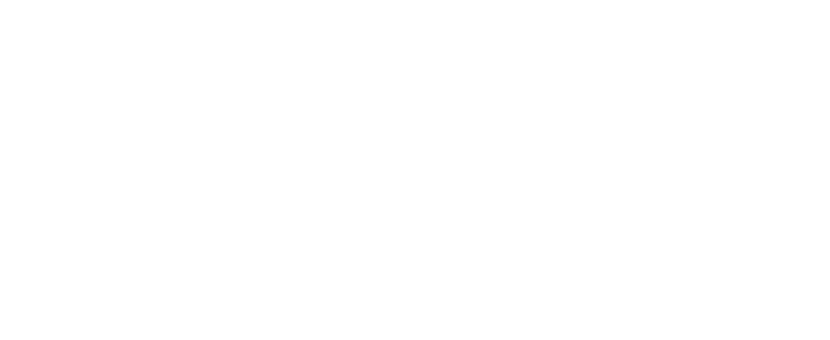

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)


<IPython.core.display.Javascript object>


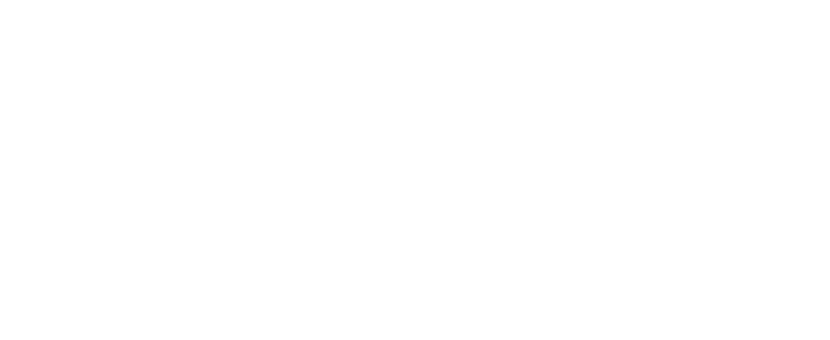

<IPython.core.display.Javascript object>


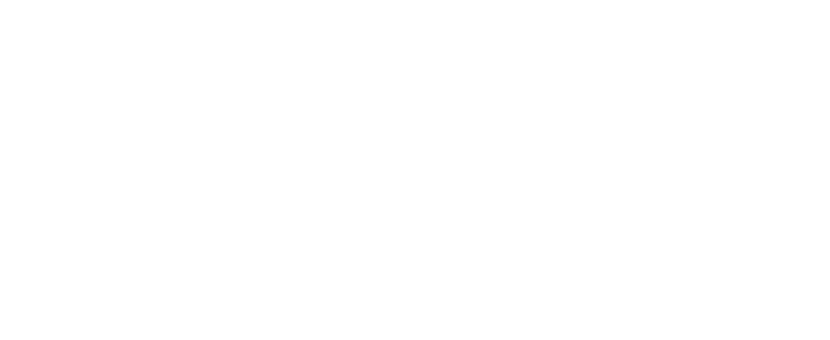

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)


<IPython.core.display.Javascript object>


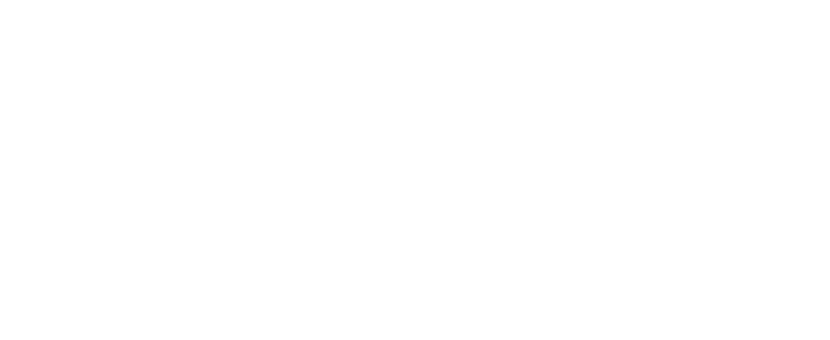

<IPython.core.display.Javascript object>


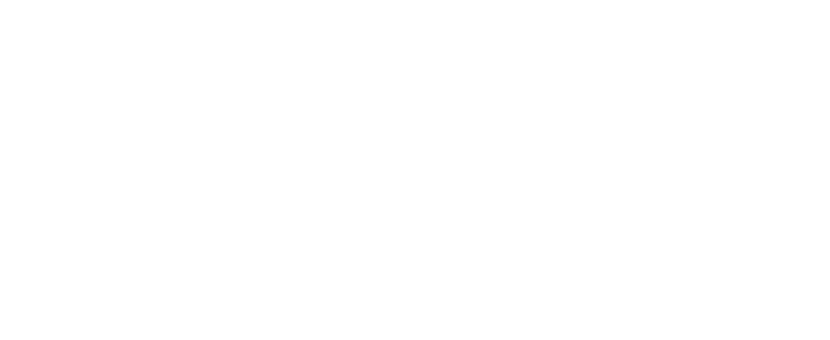

In [58]:
for _,rec in breachruns.iterrows():
    for tracer in ['marsh','pond']:
        fig=fig_tracer_snapshots(rec['model'],tracer=tracer) 
        fig.savefig(os.path.join(fig_dir,f"breach-snapshots-{tracer}-2016-{rec['name']}.png"),
                    dpi=200)

In [59]:
def tracer_exposure(mod,tracer):
    mds=mod.map_dataset(chain=False)
    t_end=mds.time.values[-1]
    return real_tracer_exposure(mod,tracer,t_end)

@memoize.memoize(cache_dir='cache',key_method='str')
def real_tracer_exposure(mod,tracer,t_end):
    mds=mod.map_dataset(chain=False)
    exposure=np.zeros(mds.grid.Ncells(),np.float64)
    dt=(mds.time.values[1]-mds.time.values[0])/np.timedelta64(1,'s')

    for tidx,t in enumerate(utils.progress(mds.time.values)):
        print(mds.time.values[tidx])
        scal=scal_davg(mds,tidx,'mesh2d_'+tracer)
        scal[np.isnan(scal)]=0.0
        exposure+=scal*dt
    return exposure


In [60]:
# Might have to rerun scen0 -- the marsh release region dips over the
# levee and contaminates the results esp. for exposure.
# Is this issue gone in the scen1 output?
# hmm - worse than that. I think the levee might actually be leaky?
# The DEM goes down to 2.65m here.
from matplotlib import colors

def fig_exposure(mod,tracer):
    exposure=tracer_exposure(mod,tracer)
    mds=mod.map_dataset(chain=False)
    fig,ax=plt.subplots()
    ax.axis('off')
    ax.set_adjustable('datalim')
    scal=exposure/3600. # hours.
    ccoll=mds.grid.plot_cells(values=scal.clip(0.1,8*24),
                              norm=colors.LogNorm(vmin=1,vmax=8*24,clip=True),
                              cmap='turbo',lw=0.5,edgecolor='face',
                              ax=ax)
    plt.colorbar(ccoll,label='Exposure (h)')
    zoom=[551951., 553291., 4124136., 4125020.]
    fig.subplots_adjust(left=0.01,right=0.99,top=0.97,bottom=0.03)
    ax.axis(zoom)
    return fig

<IPython.core.display.Javascript object>


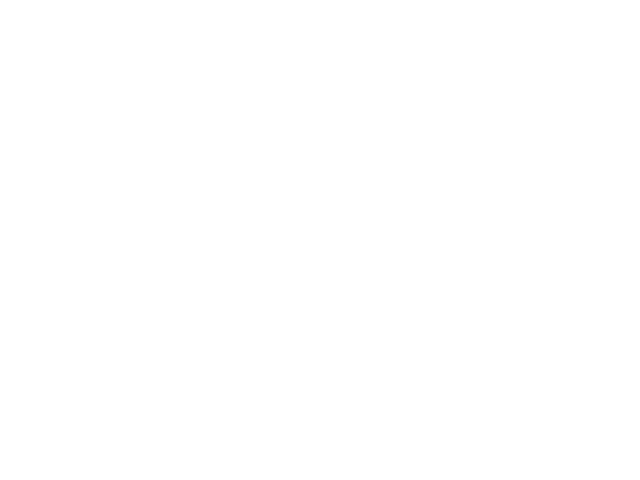

<IPython.core.display.Javascript object>


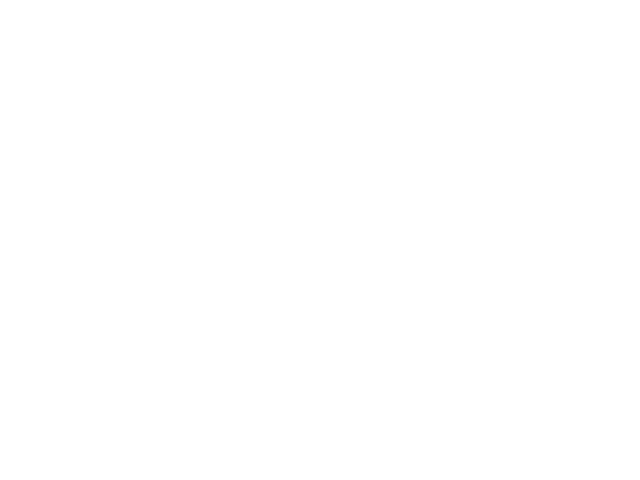

<IPython.core.display.Javascript object>


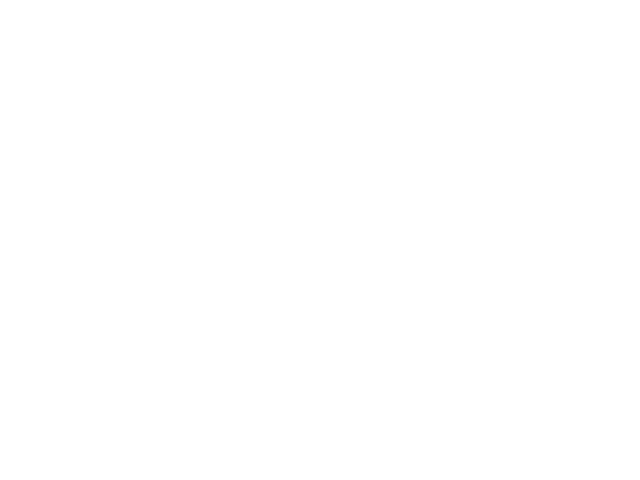

<IPython.core.display.Javascript object>


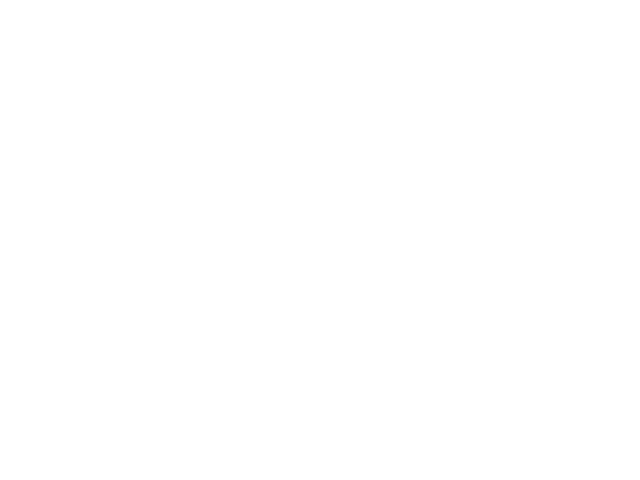

<IPython.core.display.Javascript object>


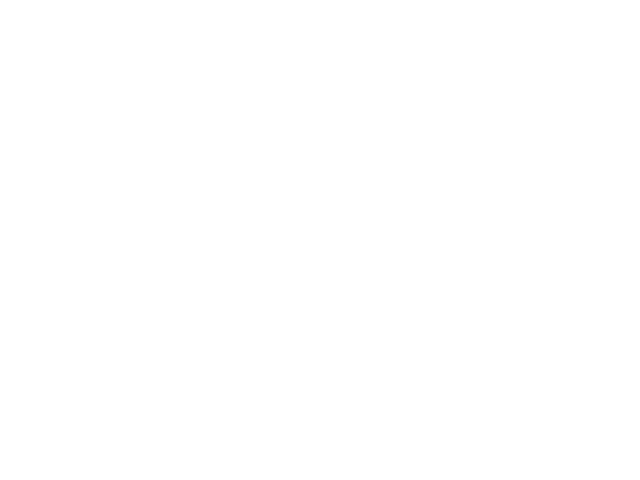

<IPython.core.display.Javascript object>


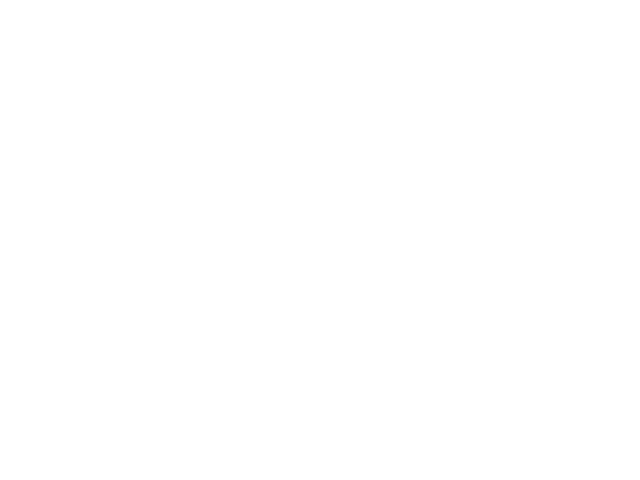

2016-12-08T00:00:00.000000000
2016-12-08T00:30:00.000000000
2016-12-08T01:00:00.000000000


INFO:utils:3/385


2016-12-08T01:30:00.000000000
2016-12-08T02:00:00.000000000
2016-12-08T02:30:00.000000000


INFO:utils:6/385


2016-12-08T03:00:00.000000000
2016-12-08T03:30:00.000000000
2016-12-08T04:00:00.000000000
2016-12-08T04:30:00.000000000


INFO:utils:10/385


2016-12-08T05:00:00.000000000
2016-12-08T05:30:00.000000000
2016-12-08T06:00:00.000000000
2016-12-08T06:30:00.000000000


INFO:utils:14/385


2016-12-08T07:00:00.000000000
2016-12-08T07:30:00.000000000
2016-12-08T08:00:00.000000000


INFO:utils:17/385


2016-12-08T08:30:00.000000000
2016-12-08T09:00:00.000000000
2016-12-08T09:30:00.000000000


INFO:utils:20/385


2016-12-08T10:00:00.000000000
2016-12-08T10:30:00.000000000
2016-12-08T11:00:00.000000000
2016-12-08T11:30:00.000000000


INFO:utils:24/385


2016-12-08T12:00:00.000000000
2016-12-08T12:30:00.000000000
2016-12-08T13:00:00.000000000


INFO:utils:27/385


2016-12-08T13:30:00.000000000
2016-12-08T14:00:00.000000000
2016-12-08T14:30:00.000000000


INFO:utils:30/385


2016-12-08T15:00:00.000000000
2016-12-08T15:30:00.000000000
2016-12-08T16:00:00.000000000


INFO:utils:33/385


2016-12-08T16:30:00.000000000
2016-12-08T17:00:00.000000000
2016-12-08T17:30:00.000000000


INFO:utils:36/385


2016-12-08T18:00:00.000000000
2016-12-08T18:30:00.000000000
2016-12-08T19:00:00.000000000


INFO:utils:39/385


2016-12-08T19:30:00.000000000
2016-12-08T20:00:00.000000000
2016-12-08T20:30:00.000000000


INFO:utils:42/385


2016-12-08T21:00:00.000000000
2016-12-08T21:30:00.000000000
2016-12-08T22:00:00.000000000


INFO:utils:45/385


2016-12-08T22:30:00.000000000
2016-12-08T23:00:00.000000000
2016-12-08T23:30:00.000000000


INFO:utils:48/385


2016-12-09T00:00:00.000000000
2016-12-09T00:30:00.000000000
2016-12-09T01:00:00.000000000
2016-12-09T01:30:00.000000000


INFO:utils:52/385


2016-12-09T02:00:00.000000000
2016-12-09T02:30:00.000000000
2016-12-09T03:00:00.000000000


INFO:utils:55/385


2016-12-09T03:30:00.000000000
2016-12-09T04:00:00.000000000
2016-12-09T04:30:00.000000000


INFO:utils:58/385


2016-12-09T05:00:00.000000000
2016-12-09T05:30:00.000000000
2016-12-09T06:00:00.000000000


INFO:utils:61/385


2016-12-09T06:30:00.000000000
2016-12-09T07:00:00.000000000
2016-12-09T07:30:00.000000000


INFO:utils:64/385


2016-12-09T08:00:00.000000000
2016-12-09T08:30:00.000000000
2016-12-09T09:00:00.000000000
2016-12-09T09:30:00.000000000


INFO:utils:68/385


2016-12-09T10:00:00.000000000
2016-12-09T10:30:00.000000000
2016-12-09T11:00:00.000000000
2016-12-09T11:30:00.000000000


INFO:utils:72/385


2016-12-09T12:00:00.000000000
2016-12-09T12:30:00.000000000
2016-12-09T13:00:00.000000000
2016-12-09T13:30:00.000000000


INFO:utils:76/385


2016-12-09T14:00:00.000000000
2016-12-09T14:30:00.000000000
2016-12-09T15:00:00.000000000
2016-12-09T15:30:00.000000000


INFO:utils:80/385


2016-12-09T16:00:00.000000000
2016-12-09T16:30:00.000000000
2016-12-09T17:00:00.000000000
2016-12-09T17:30:00.000000000


INFO:utils:84/385


2016-12-09T18:00:00.000000000
2016-12-09T18:30:00.000000000
2016-12-09T19:00:00.000000000


INFO:utils:87/385


2016-12-09T19:30:00.000000000
2016-12-09T20:00:00.000000000
2016-12-09T20:30:00.000000000


INFO:utils:90/385


2016-12-09T21:00:00.000000000
2016-12-09T21:30:00.000000000
2016-12-09T22:00:00.000000000


INFO:utils:93/385


2016-12-09T22:30:00.000000000
2016-12-09T23:00:00.000000000
2016-12-09T23:30:00.000000000


INFO:utils:96/385


2016-12-10T00:00:00.000000000
2016-12-10T00:30:00.000000000
2016-12-10T01:00:00.000000000


INFO:utils:99/385


2016-12-10T01:30:00.000000000
2016-12-10T02:00:00.000000000
2016-12-10T02:30:00.000000000


INFO:utils:102/385


2016-12-10T03:00:00.000000000
2016-12-10T03:30:00.000000000
2016-12-10T04:00:00.000000000


INFO:utils:105/385


2016-12-10T04:30:00.000000000
2016-12-10T05:00:00.000000000
2016-12-10T05:30:00.000000000


INFO:utils:108/385


2016-12-10T06:00:00.000000000
2016-12-10T06:30:00.000000000
2016-12-10T07:00:00.000000000


INFO:utils:111/385


2016-12-10T07:30:00.000000000
2016-12-10T08:00:00.000000000
2016-12-10T08:30:00.000000000


INFO:utils:114/385


2016-12-10T09:00:00.000000000
2016-12-10T09:30:00.000000000
2016-12-10T10:00:00.000000000


INFO:utils:117/385


2016-12-10T10:30:00.000000000
2016-12-10T11:00:00.000000000
2016-12-10T11:30:00.000000000


INFO:utils:120/385


2016-12-10T12:00:00.000000000
2016-12-10T12:30:00.000000000
2016-12-10T13:00:00.000000000


INFO:utils:123/385


2016-12-10T13:30:00.000000000
2016-12-10T14:00:00.000000000
2016-12-10T14:30:00.000000000


INFO:utils:126/385


2016-12-10T15:00:00.000000000
2016-12-10T15:30:00.000000000
2016-12-10T16:00:00.000000000


INFO:utils:129/385


2016-12-10T16:30:00.000000000
2016-12-10T17:00:00.000000000
2016-12-10T17:30:00.000000000


INFO:utils:132/385


2016-12-10T18:00:00.000000000
2016-12-10T18:30:00.000000000
2016-12-10T19:00:00.000000000


INFO:utils:135/385


2016-12-10T19:30:00.000000000
2016-12-10T20:00:00.000000000
2016-12-10T20:30:00.000000000


INFO:utils:138/385


2016-12-10T21:00:00.000000000
2016-12-10T21:30:00.000000000
2016-12-10T22:00:00.000000000


INFO:utils:141/385


2016-12-10T22:30:00.000000000
2016-12-10T23:00:00.000000000
2016-12-10T23:30:00.000000000


INFO:utils:144/385


2016-12-11T00:00:00.000000000
2016-12-11T00:30:00.000000000
2016-12-11T01:00:00.000000000


INFO:utils:147/385


2016-12-11T01:30:00.000000000
2016-12-11T02:00:00.000000000
2016-12-11T02:30:00.000000000


INFO:utils:150/385


2016-12-11T03:00:00.000000000
2016-12-11T03:30:00.000000000
2016-12-11T04:00:00.000000000


INFO:utils:153/385


2016-12-11T04:30:00.000000000
2016-12-11T05:00:00.000000000
2016-12-11T05:30:00.000000000


INFO:utils:156/385


2016-12-11T06:00:00.000000000
2016-12-11T06:30:00.000000000
2016-12-11T07:00:00.000000000


INFO:utils:159/385


2016-12-11T07:30:00.000000000
2016-12-11T08:00:00.000000000
2016-12-11T08:30:00.000000000


INFO:utils:162/385


2016-12-11T09:00:00.000000000
2016-12-11T09:30:00.000000000
2016-12-11T10:00:00.000000000


INFO:utils:165/385


2016-12-11T10:30:00.000000000
2016-12-11T11:00:00.000000000
2016-12-11T11:30:00.000000000


INFO:utils:168/385


2016-12-11T12:00:00.000000000
2016-12-11T12:30:00.000000000
2016-12-11T13:00:00.000000000


INFO:utils:171/385


2016-12-11T13:30:00.000000000
2016-12-11T14:00:00.000000000
2016-12-11T14:30:00.000000000


INFO:utils:174/385


2016-12-11T15:00:00.000000000
2016-12-11T15:30:00.000000000
2016-12-11T16:00:00.000000000


INFO:utils:177/385


2016-12-11T16:30:00.000000000
2016-12-11T17:00:00.000000000
2016-12-11T17:30:00.000000000


INFO:utils:180/385


2016-12-11T18:00:00.000000000
2016-12-11T18:30:00.000000000
2016-12-11T19:00:00.000000000


INFO:utils:183/385


2016-12-11T19:30:00.000000000
2016-12-11T20:00:00.000000000
2016-12-11T20:30:00.000000000


INFO:utils:186/385


2016-12-11T21:00:00.000000000
2016-12-11T21:30:00.000000000
2016-12-11T22:00:00.000000000


INFO:utils:189/385


2016-12-11T22:30:00.000000000
2016-12-11T23:00:00.000000000
2016-12-11T23:30:00.000000000


INFO:utils:192/385


2016-12-12T00:00:00.000000000
2016-12-12T00:30:00.000000000
2016-12-12T01:00:00.000000000


INFO:utils:195/385


2016-12-12T01:30:00.000000000
2016-12-12T02:00:00.000000000
2016-12-12T02:30:00.000000000


INFO:utils:198/385


2016-12-12T03:00:00.000000000
2016-12-12T03:30:00.000000000
2016-12-12T04:00:00.000000000


INFO:utils:201/385


2016-12-12T04:30:00.000000000
2016-12-12T05:00:00.000000000
2016-12-12T05:30:00.000000000


INFO:utils:204/385


2016-12-12T06:00:00.000000000
2016-12-12T06:30:00.000000000
2016-12-12T07:00:00.000000000


INFO:utils:207/385


2016-12-12T07:30:00.000000000
2016-12-12T08:00:00.000000000
2016-12-12T08:30:00.000000000


INFO:utils:210/385


2016-12-12T09:00:00.000000000
2016-12-12T09:30:00.000000000
2016-12-12T10:00:00.000000000


INFO:utils:213/385


2016-12-12T10:30:00.000000000
2016-12-12T11:00:00.000000000
2016-12-12T11:30:00.000000000


INFO:utils:216/385


2016-12-12T12:00:00.000000000
2016-12-12T12:30:00.000000000
2016-12-12T13:00:00.000000000


INFO:utils:219/385


2016-12-12T13:30:00.000000000
2016-12-12T14:00:00.000000000
2016-12-12T14:30:00.000000000


INFO:utils:222/385


2016-12-12T15:00:00.000000000
2016-12-12T15:30:00.000000000
2016-12-12T16:00:00.000000000


INFO:utils:225/385


2016-12-12T16:30:00.000000000
2016-12-12T17:00:00.000000000
2016-12-12T17:30:00.000000000


INFO:utils:228/385


2016-12-12T18:00:00.000000000
2016-12-12T18:30:00.000000000
2016-12-12T19:00:00.000000000


INFO:utils:231/385


2016-12-12T19:30:00.000000000
2016-12-12T20:00:00.000000000
2016-12-12T20:30:00.000000000


INFO:utils:234/385


2016-12-12T21:00:00.000000000
2016-12-12T21:30:00.000000000
2016-12-12T22:00:00.000000000


INFO:utils:237/385


2016-12-12T22:30:00.000000000
2016-12-12T23:00:00.000000000
2016-12-12T23:30:00.000000000


INFO:utils:240/385


2016-12-13T00:00:00.000000000
2016-12-13T00:30:00.000000000
2016-12-13T01:00:00.000000000


INFO:utils:243/385


2016-12-13T01:30:00.000000000
2016-12-13T02:00:00.000000000
2016-12-13T02:30:00.000000000


INFO:utils:246/385


2016-12-13T03:00:00.000000000
2016-12-13T03:30:00.000000000


INFO:utils:248/385


2016-12-13T04:00:00.000000000
2016-12-13T04:30:00.000000000


INFO:utils:250/385


2016-12-13T05:00:00.000000000
2016-12-13T05:30:00.000000000
2016-12-13T06:00:00.000000000


INFO:utils:253/385


2016-12-13T06:30:00.000000000
2016-12-13T07:00:00.000000000


INFO:utils:255/385


2016-12-13T07:30:00.000000000
2016-12-13T08:00:00.000000000


INFO:utils:257/385


2016-12-13T08:30:00.000000000
2016-12-13T09:00:00.000000000


INFO:utils:259/385


2016-12-13T09:30:00.000000000
2016-12-13T10:00:00.000000000


INFO:utils:261/385


2016-12-13T10:30:00.000000000
2016-12-13T11:00:00.000000000


INFO:utils:263/385


2016-12-13T11:30:00.000000000
2016-12-13T12:00:00.000000000


INFO:utils:265/385


2016-12-13T12:30:00.000000000
2016-12-13T13:00:00.000000000


INFO:utils:267/385


2016-12-13T13:30:00.000000000
2016-12-13T14:00:00.000000000


INFO:utils:269/385


2016-12-13T14:30:00.000000000
2016-12-13T15:00:00.000000000


INFO:utils:271/385


2016-12-13T15:30:00.000000000
2016-12-13T16:00:00.000000000


INFO:utils:273/385


2016-12-13T16:30:00.000000000
2016-12-13T17:00:00.000000000


INFO:utils:275/385


2016-12-13T17:30:00.000000000
2016-12-13T18:00:00.000000000


INFO:utils:277/385


2016-12-13T18:30:00.000000000
2016-12-13T19:00:00.000000000
2016-12-13T19:30:00.000000000


INFO:utils:280/385


2016-12-13T20:00:00.000000000
2016-12-13T20:30:00.000000000
2016-12-13T21:00:00.000000000


INFO:utils:283/385


2016-12-13T21:30:00.000000000
2016-12-13T22:00:00.000000000
2016-12-13T22:30:00.000000000


INFO:utils:286/385


2016-12-13T23:00:00.000000000
2016-12-13T23:30:00.000000000
2016-12-14T00:00:00.000000000


INFO:utils:289/385


2016-12-14T00:30:00.000000000


INFO:utils:290/385


2016-12-14T01:00:00.000000000


INFO:utils:291/385


2016-12-14T01:30:00.000000000


INFO:utils:292/385


2016-12-14T02:00:00.000000000


INFO:utils:293/385


2016-12-14T02:30:00.000000000


INFO:utils:294/385


2016-12-14T03:00:00.000000000


INFO:utils:295/385


2016-12-14T03:30:00.000000000


INFO:utils:296/385


2016-12-14T04:00:00.000000000
2016-12-14T04:30:00.000000000


INFO:utils:298/385


2016-12-14T05:00:00.000000000


INFO:utils:299/385


2016-12-14T05:30:00.000000000
2016-12-14T06:00:00.000000000


INFO:utils:301/385


2016-12-14T06:30:00.000000000
2016-12-14T07:00:00.000000000


INFO:utils:303/385


2016-12-14T07:30:00.000000000
2016-12-14T08:00:00.000000000


INFO:utils:305/385


2016-12-14T08:30:00.000000000
2016-12-14T09:00:00.000000000


INFO:utils:307/385


2016-12-14T09:30:00.000000000
2016-12-14T10:00:00.000000000


INFO:utils:309/385


2016-12-14T10:30:00.000000000
2016-12-14T11:00:00.000000000


INFO:utils:311/385


2016-12-14T11:30:00.000000000
2016-12-14T12:00:00.000000000


INFO:utils:313/385


2016-12-14T12:30:00.000000000
2016-12-14T13:00:00.000000000


INFO:utils:315/385


2016-12-14T13:30:00.000000000
2016-12-14T14:00:00.000000000


INFO:utils:317/385


2016-12-14T14:30:00.000000000
2016-12-14T15:00:00.000000000


INFO:utils:319/385


2016-12-14T15:30:00.000000000
2016-12-14T16:00:00.000000000


INFO:utils:321/385


2016-12-14T16:30:00.000000000
2016-12-14T17:00:00.000000000


INFO:utils:323/385


2016-12-14T17:30:00.000000000
2016-12-14T18:00:00.000000000


INFO:utils:325/385


2016-12-14T18:30:00.000000000
2016-12-14T19:00:00.000000000


INFO:utils:327/385


2016-12-14T19:30:00.000000000
2016-12-14T20:00:00.000000000


INFO:utils:329/385


2016-12-14T20:30:00.000000000
2016-12-14T21:00:00.000000000


INFO:utils:331/385


2016-12-14T21:30:00.000000000
2016-12-14T22:00:00.000000000


INFO:utils:333/385


2016-12-14T22:30:00.000000000
2016-12-14T23:00:00.000000000


INFO:utils:335/385


2016-12-14T23:30:00.000000000
2016-12-15T00:00:00.000000000


INFO:utils:337/385


2016-12-15T00:30:00.000000000
2016-12-15T01:00:00.000000000
2016-12-15T01:30:00.000000000


INFO:utils:340/385


2016-12-15T02:00:00.000000000
2016-12-15T02:30:00.000000000


INFO:utils:342/385


2016-12-15T03:00:00.000000000
2016-12-15T03:30:00.000000000
2016-12-15T04:00:00.000000000


INFO:utils:345/385


2016-12-15T04:30:00.000000000
2016-12-15T05:00:00.000000000
2016-12-15T05:30:00.000000000


INFO:utils:348/385


2016-12-15T06:00:00.000000000
2016-12-15T06:30:00.000000000
2016-12-15T07:00:00.000000000


INFO:utils:351/385


2016-12-15T07:30:00.000000000
2016-12-15T08:00:00.000000000
2016-12-15T08:30:00.000000000


INFO:utils:354/385


2016-12-15T09:00:00.000000000
2016-12-15T09:30:00.000000000
2016-12-15T10:00:00.000000000


INFO:utils:357/385


2016-12-15T10:30:00.000000000
2016-12-15T11:00:00.000000000
2016-12-15T11:30:00.000000000


INFO:utils:360/385


2016-12-15T12:00:00.000000000
2016-12-15T12:30:00.000000000
2016-12-15T13:00:00.000000000


INFO:utils:363/385


2016-12-15T13:30:00.000000000
2016-12-15T14:00:00.000000000
2016-12-15T14:30:00.000000000


INFO:utils:366/385


2016-12-15T15:00:00.000000000
2016-12-15T15:30:00.000000000
2016-12-15T16:00:00.000000000


INFO:utils:369/385


2016-12-15T16:30:00.000000000
2016-12-15T17:00:00.000000000
2016-12-15T17:30:00.000000000


INFO:utils:372/385


2016-12-15T18:00:00.000000000
2016-12-15T18:30:00.000000000
2016-12-15T19:00:00.000000000


INFO:utils:375/385


2016-12-15T19:30:00.000000000
2016-12-15T20:00:00.000000000
2016-12-15T20:30:00.000000000


INFO:utils:378/385


2016-12-15T21:00:00.000000000
2016-12-15T21:30:00.000000000
2016-12-15T22:00:00.000000000


INFO:utils:381/385


2016-12-15T22:30:00.000000000
2016-12-15T23:00:00.000000000
2016-12-15T23:30:00.000000000


INFO:utils:384/385


2016-12-16T00:00:00.000000000


<IPython.core.display.Javascript object>


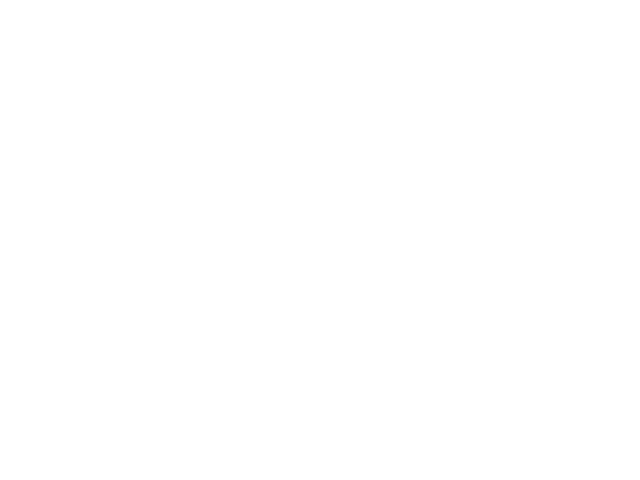

2016-12-08T00:00:00.000000000
2016-12-08T00:30:00.000000000
2016-12-08T01:00:00.000000000
2016-12-08T01:30:00.000000000


INFO:utils:4/385


2016-12-08T02:00:00.000000000
2016-12-08T02:30:00.000000000
2016-12-08T03:00:00.000000000
2016-12-08T03:30:00.000000000


INFO:utils:8/385


2016-12-08T04:00:00.000000000
2016-12-08T04:30:00.000000000
2016-12-08T05:00:00.000000000
2016-12-08T05:30:00.000000000


INFO:utils:12/385


2016-12-08T06:00:00.000000000
2016-12-08T06:30:00.000000000
2016-12-08T07:00:00.000000000
2016-12-08T07:30:00.000000000


INFO:utils:16/385


2016-12-08T08:00:00.000000000
2016-12-08T08:30:00.000000000
2016-12-08T09:00:00.000000000
2016-12-08T09:30:00.000000000


INFO:utils:20/385


2016-12-08T10:00:00.000000000
2016-12-08T10:30:00.000000000
2016-12-08T11:00:00.000000000


INFO:utils:23/385


2016-12-08T11:30:00.000000000
2016-12-08T12:00:00.000000000
2016-12-08T12:30:00.000000000


INFO:utils:26/385


2016-12-08T13:00:00.000000000
2016-12-08T13:30:00.000000000
2016-12-08T14:00:00.000000000
2016-12-08T14:30:00.000000000


INFO:utils:30/385


2016-12-08T15:00:00.000000000
2016-12-08T15:30:00.000000000
2016-12-08T16:00:00.000000000
2016-12-08T16:30:00.000000000


INFO:utils:34/385


2016-12-08T17:00:00.000000000
2016-12-08T17:30:00.000000000
2016-12-08T18:00:00.000000000


INFO:utils:37/385


2016-12-08T18:30:00.000000000
2016-12-08T19:00:00.000000000
2016-12-08T19:30:00.000000000


INFO:utils:40/385


2016-12-08T20:00:00.000000000
2016-12-08T20:30:00.000000000
2016-12-08T21:00:00.000000000


INFO:utils:43/385


2016-12-08T21:30:00.000000000
2016-12-08T22:00:00.000000000
2016-12-08T22:30:00.000000000


INFO:utils:46/385


2016-12-08T23:00:00.000000000
2016-12-08T23:30:00.000000000
2016-12-09T00:00:00.000000000
2016-12-09T00:30:00.000000000


INFO:utils:50/385


2016-12-09T01:00:00.000000000
2016-12-09T01:30:00.000000000
2016-12-09T02:00:00.000000000


INFO:utils:53/385


2016-12-09T02:30:00.000000000
2016-12-09T03:00:00.000000000
2016-12-09T03:30:00.000000000


INFO:utils:56/385


2016-12-09T04:00:00.000000000
2016-12-09T04:30:00.000000000
2016-12-09T05:00:00.000000000


INFO:utils:59/385


2016-12-09T05:30:00.000000000
2016-12-09T06:00:00.000000000
2016-12-09T06:30:00.000000000


INFO:utils:62/385


2016-12-09T07:00:00.000000000
2016-12-09T07:30:00.000000000
2016-12-09T08:00:00.000000000


INFO:utils:65/385


2016-12-09T08:30:00.000000000
2016-12-09T09:00:00.000000000
2016-12-09T09:30:00.000000000


INFO:utils:68/385


2016-12-09T10:00:00.000000000
2016-12-09T10:30:00.000000000
2016-12-09T11:00:00.000000000


INFO:utils:71/385


2016-12-09T11:30:00.000000000
2016-12-09T12:00:00.000000000
2016-12-09T12:30:00.000000000


INFO:utils:74/385


2016-12-09T13:00:00.000000000
2016-12-09T13:30:00.000000000
2016-12-09T14:00:00.000000000


INFO:utils:77/385


2016-12-09T14:30:00.000000000
2016-12-09T15:00:00.000000000
2016-12-09T15:30:00.000000000


INFO:utils:80/385


2016-12-09T16:00:00.000000000
2016-12-09T16:30:00.000000000
2016-12-09T17:00:00.000000000


INFO:utils:83/385


2016-12-09T17:30:00.000000000
2016-12-09T18:00:00.000000000
2016-12-09T18:30:00.000000000


INFO:utils:86/385


2016-12-09T19:00:00.000000000
2016-12-09T19:30:00.000000000
2016-12-09T20:00:00.000000000


INFO:utils:89/385


2016-12-09T20:30:00.000000000
2016-12-09T21:00:00.000000000
2016-12-09T21:30:00.000000000


INFO:utils:92/385


2016-12-09T22:00:00.000000000
2016-12-09T22:30:00.000000000
2016-12-09T23:00:00.000000000


INFO:utils:95/385


2016-12-09T23:30:00.000000000
2016-12-10T00:00:00.000000000
2016-12-10T00:30:00.000000000
2016-12-10T01:00:00.000000000


INFO:utils:99/385


2016-12-10T01:30:00.000000000
2016-12-10T02:00:00.000000000
2016-12-10T02:30:00.000000000
2016-12-10T03:00:00.000000000


INFO:utils:103/385


2016-12-10T03:30:00.000000000
2016-12-10T04:00:00.000000000
2016-12-10T04:30:00.000000000
2016-12-10T05:00:00.000000000


INFO:utils:107/385


2016-12-10T05:30:00.000000000
2016-12-10T06:00:00.000000000
2016-12-10T06:30:00.000000000


INFO:utils:110/385


2016-12-10T07:00:00.000000000
2016-12-10T07:30:00.000000000
2016-12-10T08:00:00.000000000


INFO:utils:113/385


2016-12-10T08:30:00.000000000
2016-12-10T09:00:00.000000000
2016-12-10T09:30:00.000000000


INFO:utils:116/385


2016-12-10T10:00:00.000000000
2016-12-10T10:30:00.000000000
2016-12-10T11:00:00.000000000
2016-12-10T11:30:00.000000000


INFO:utils:120/385


2016-12-10T12:00:00.000000000
2016-12-10T12:30:00.000000000
2016-12-10T13:00:00.000000000


INFO:utils:123/385


2016-12-10T13:30:00.000000000
2016-12-10T14:00:00.000000000
2016-12-10T14:30:00.000000000


INFO:utils:126/385


2016-12-10T15:00:00.000000000
2016-12-10T15:30:00.000000000
2016-12-10T16:00:00.000000000
2016-12-10T16:30:00.000000000


INFO:utils:130/385


2016-12-10T17:00:00.000000000
2016-12-10T17:30:00.000000000
2016-12-10T18:00:00.000000000
2016-12-10T18:30:00.000000000


INFO:utils:134/385


2016-12-10T19:00:00.000000000
2016-12-10T19:30:00.000000000
2016-12-10T20:00:00.000000000
2016-12-10T20:30:00.000000000


INFO:utils:138/385


2016-12-10T21:00:00.000000000
2016-12-10T21:30:00.000000000
2016-12-10T22:00:00.000000000


INFO:utils:141/385


2016-12-10T22:30:00.000000000
2016-12-10T23:00:00.000000000
2016-12-10T23:30:00.000000000


INFO:utils:144/385


2016-12-11T00:00:00.000000000
2016-12-11T00:30:00.000000000
2016-12-11T01:00:00.000000000


INFO:utils:147/385


2016-12-11T01:30:00.000000000
2016-12-11T02:00:00.000000000
2016-12-11T02:30:00.000000000


INFO:utils:150/385


2016-12-11T03:00:00.000000000
2016-12-11T03:30:00.000000000
2016-12-11T04:00:00.000000000


INFO:utils:153/385


2016-12-11T04:30:00.000000000
2016-12-11T05:00:00.000000000
2016-12-11T05:30:00.000000000


INFO:utils:156/385


2016-12-11T06:00:00.000000000
2016-12-11T06:30:00.000000000
2016-12-11T07:00:00.000000000


INFO:utils:159/385


2016-12-11T07:30:00.000000000
2016-12-11T08:00:00.000000000
2016-12-11T08:30:00.000000000


INFO:utils:162/385


2016-12-11T09:00:00.000000000
2016-12-11T09:30:00.000000000
2016-12-11T10:00:00.000000000


INFO:utils:165/385


2016-12-11T10:30:00.000000000
2016-12-11T11:00:00.000000000
2016-12-11T11:30:00.000000000


INFO:utils:168/385


2016-12-11T12:00:00.000000000
2016-12-11T12:30:00.000000000
2016-12-11T13:00:00.000000000
2016-12-11T13:30:00.000000000


INFO:utils:172/385


2016-12-11T14:00:00.000000000
2016-12-11T14:30:00.000000000
2016-12-11T15:00:00.000000000
2016-12-11T15:30:00.000000000


INFO:utils:176/385


2016-12-11T16:00:00.000000000
2016-12-11T16:30:00.000000000
2016-12-11T17:00:00.000000000
2016-12-11T17:30:00.000000000


INFO:utils:180/385


2016-12-11T18:00:00.000000000
2016-12-11T18:30:00.000000000
2016-12-11T19:00:00.000000000
2016-12-11T19:30:00.000000000


INFO:utils:184/385


2016-12-11T20:00:00.000000000
2016-12-11T20:30:00.000000000
2016-12-11T21:00:00.000000000
2016-12-11T21:30:00.000000000


INFO:utils:188/385


2016-12-11T22:00:00.000000000
2016-12-11T22:30:00.000000000
2016-12-11T23:00:00.000000000
2016-12-11T23:30:00.000000000


INFO:utils:192/385


2016-12-12T00:00:00.000000000
2016-12-12T00:30:00.000000000
2016-12-12T01:00:00.000000000
2016-12-12T01:30:00.000000000


INFO:utils:196/385


2016-12-12T02:00:00.000000000
2016-12-12T02:30:00.000000000
2016-12-12T03:00:00.000000000
2016-12-12T03:30:00.000000000


INFO:utils:200/385


2016-12-12T04:00:00.000000000
2016-12-12T04:30:00.000000000
2016-12-12T05:00:00.000000000
2016-12-12T05:30:00.000000000


INFO:utils:204/385


2016-12-12T06:00:00.000000000
2016-12-12T06:30:00.000000000
2016-12-12T07:00:00.000000000
2016-12-12T07:30:00.000000000


INFO:utils:208/385


2016-12-12T08:00:00.000000000
2016-12-12T08:30:00.000000000
2016-12-12T09:00:00.000000000
2016-12-12T09:30:00.000000000


INFO:utils:212/385


2016-12-12T10:00:00.000000000
2016-12-12T10:30:00.000000000
2016-12-12T11:00:00.000000000
2016-12-12T11:30:00.000000000


INFO:utils:216/385


2016-12-12T12:00:00.000000000
2016-12-12T12:30:00.000000000
2016-12-12T13:00:00.000000000


INFO:utils:219/385


2016-12-12T13:30:00.000000000
2016-12-12T14:00:00.000000000
2016-12-12T14:30:00.000000000


INFO:utils:222/385


2016-12-12T15:00:00.000000000
2016-12-12T15:30:00.000000000
2016-12-12T16:00:00.000000000


INFO:utils:225/385


2016-12-12T16:30:00.000000000
2016-12-12T17:00:00.000000000
2016-12-12T17:30:00.000000000


INFO:utils:228/385


2016-12-12T18:00:00.000000000
2016-12-12T18:30:00.000000000
2016-12-12T19:00:00.000000000


INFO:utils:231/385


2016-12-12T19:30:00.000000000
2016-12-12T20:00:00.000000000
2016-12-12T20:30:00.000000000
2016-12-12T21:00:00.000000000


INFO:utils:235/385


2016-12-12T21:30:00.000000000
2016-12-12T22:00:00.000000000
2016-12-12T22:30:00.000000000
2016-12-12T23:00:00.000000000


INFO:utils:239/385


2016-12-12T23:30:00.000000000
2016-12-13T00:00:00.000000000
2016-12-13T00:30:00.000000000
2016-12-13T01:00:00.000000000


INFO:utils:243/385


2016-12-13T01:30:00.000000000
2016-12-13T02:00:00.000000000
2016-12-13T02:30:00.000000000
2016-12-13T03:00:00.000000000


INFO:utils:247/385


2016-12-13T03:30:00.000000000
2016-12-13T04:00:00.000000000
2016-12-13T04:30:00.000000000
2016-12-13T05:00:00.000000000


INFO:utils:251/385


2016-12-13T05:30:00.000000000
2016-12-13T06:00:00.000000000
2016-12-13T06:30:00.000000000
2016-12-13T07:00:00.000000000


INFO:utils:255/385


2016-12-13T07:30:00.000000000
2016-12-13T08:00:00.000000000
2016-12-13T08:30:00.000000000


INFO:utils:258/385


2016-12-13T09:00:00.000000000
2016-12-13T09:30:00.000000000
2016-12-13T10:00:00.000000000


INFO:utils:261/385


2016-12-13T10:30:00.000000000
2016-12-13T11:00:00.000000000
2016-12-13T11:30:00.000000000


INFO:utils:264/385


2016-12-13T12:00:00.000000000
2016-12-13T12:30:00.000000000
2016-12-13T13:00:00.000000000


INFO:utils:267/385


2016-12-13T13:30:00.000000000
2016-12-13T14:00:00.000000000
2016-12-13T14:30:00.000000000


INFO:utils:270/385


2016-12-13T15:00:00.000000000
2016-12-13T15:30:00.000000000
2016-12-13T16:00:00.000000000


INFO:utils:273/385


2016-12-13T16:30:00.000000000
2016-12-13T17:00:00.000000000
2016-12-13T17:30:00.000000000


INFO:utils:276/385


2016-12-13T18:00:00.000000000
2016-12-13T18:30:00.000000000
2016-12-13T19:00:00.000000000


INFO:utils:279/385


2016-12-13T19:30:00.000000000
2016-12-13T20:00:00.000000000
2016-12-13T20:30:00.000000000


INFO:utils:282/385


2016-12-13T21:00:00.000000000
2016-12-13T21:30:00.000000000
2016-12-13T22:00:00.000000000
2016-12-13T22:30:00.000000000


INFO:utils:286/385


2016-12-13T23:00:00.000000000
2016-12-13T23:30:00.000000000
2016-12-14T00:00:00.000000000
2016-12-14T00:30:00.000000000


INFO:utils:290/385


2016-12-14T01:00:00.000000000
2016-12-14T01:30:00.000000000
2016-12-14T02:00:00.000000000


INFO:utils:293/385


2016-12-14T02:30:00.000000000
2016-12-14T03:00:00.000000000
2016-12-14T03:30:00.000000000


INFO:utils:296/385


2016-12-14T04:00:00.000000000
2016-12-14T04:30:00.000000000
2016-12-14T05:00:00.000000000


INFO:utils:299/385


2016-12-14T05:30:00.000000000
2016-12-14T06:00:00.000000000
2016-12-14T06:30:00.000000000


INFO:utils:302/385


2016-12-14T07:00:00.000000000
2016-12-14T07:30:00.000000000
2016-12-14T08:00:00.000000000


INFO:utils:305/385


2016-12-14T08:30:00.000000000
2016-12-14T09:00:00.000000000
2016-12-14T09:30:00.000000000


INFO:utils:308/385


2016-12-14T10:00:00.000000000
2016-12-14T10:30:00.000000000
2016-12-14T11:00:00.000000000


INFO:utils:311/385


2016-12-14T11:30:00.000000000
2016-12-14T12:00:00.000000000
2016-12-14T12:30:00.000000000


INFO:utils:314/385


2016-12-14T13:00:00.000000000
2016-12-14T13:30:00.000000000
2016-12-14T14:00:00.000000000


INFO:utils:317/385


2016-12-14T14:30:00.000000000
2016-12-14T15:00:00.000000000
2016-12-14T15:30:00.000000000


INFO:utils:320/385


2016-12-14T16:00:00.000000000
2016-12-14T16:30:00.000000000
2016-12-14T17:00:00.000000000


INFO:utils:323/385


2016-12-14T17:30:00.000000000
2016-12-14T18:00:00.000000000
2016-12-14T18:30:00.000000000


INFO:utils:326/385


2016-12-14T19:00:00.000000000
2016-12-14T19:30:00.000000000
2016-12-14T20:00:00.000000000


INFO:utils:329/385


2016-12-14T20:30:00.000000000
2016-12-14T21:00:00.000000000
2016-12-14T21:30:00.000000000


INFO:utils:332/385


2016-12-14T22:00:00.000000000
2016-12-14T22:30:00.000000000
2016-12-14T23:00:00.000000000


INFO:utils:335/385


2016-12-14T23:30:00.000000000
2016-12-15T00:00:00.000000000
2016-12-15T00:30:00.000000000


INFO:utils:338/385


2016-12-15T01:00:00.000000000
2016-12-15T01:30:00.000000000
2016-12-15T02:00:00.000000000


INFO:utils:341/385


2016-12-15T02:30:00.000000000
2016-12-15T03:00:00.000000000
2016-12-15T03:30:00.000000000


INFO:utils:344/385


2016-12-15T04:00:00.000000000
2016-12-15T04:30:00.000000000
2016-12-15T05:00:00.000000000


INFO:utils:347/385


2016-12-15T05:30:00.000000000
2016-12-15T06:00:00.000000000
2016-12-15T06:30:00.000000000


INFO:utils:350/385


2016-12-15T07:00:00.000000000
2016-12-15T07:30:00.000000000
2016-12-15T08:00:00.000000000


INFO:utils:353/385


2016-12-15T08:30:00.000000000
2016-12-15T09:00:00.000000000
2016-12-15T09:30:00.000000000


INFO:utils:356/385


2016-12-15T10:00:00.000000000
2016-12-15T10:30:00.000000000
2016-12-15T11:00:00.000000000


INFO:utils:359/385


2016-12-15T11:30:00.000000000
2016-12-15T12:00:00.000000000
2016-12-15T12:30:00.000000000


INFO:utils:362/385


2016-12-15T13:00:00.000000000
2016-12-15T13:30:00.000000000
2016-12-15T14:00:00.000000000


INFO:utils:365/385


2016-12-15T14:30:00.000000000
2016-12-15T15:00:00.000000000
2016-12-15T15:30:00.000000000


INFO:utils:368/385


2016-12-15T16:00:00.000000000
2016-12-15T16:30:00.000000000
2016-12-15T17:00:00.000000000


INFO:utils:371/385


2016-12-15T17:30:00.000000000
2016-12-15T18:00:00.000000000
2016-12-15T18:30:00.000000000


INFO:utils:374/385


2016-12-15T19:00:00.000000000
2016-12-15T19:30:00.000000000
2016-12-15T20:00:00.000000000


INFO:utils:377/385


2016-12-15T20:30:00.000000000
2016-12-15T21:00:00.000000000
2016-12-15T21:30:00.000000000


INFO:utils:380/385


2016-12-15T22:00:00.000000000
2016-12-15T22:30:00.000000000
2016-12-15T23:00:00.000000000


INFO:utils:383/385


2016-12-15T23:30:00.000000000
2016-12-16T00:00:00.000000000


<IPython.core.display.Javascript object>


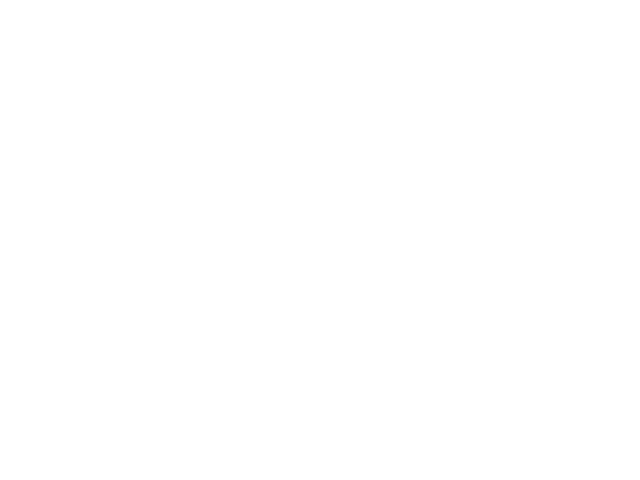

In [61]:
# Integrate exposure to marsh water
for _,rec in breachruns.iterrows():
    for tracer in ['marsh','pond']:
        mod=rec['model']
        fig=fig_exposure(mod,tracer)
        fig.savefig(os.path.join(fig_dir,f"breach-exposure-{tracer}-2016-{rec['name']}.png"),
                    dpi=200)

In [62]:
plt.close('all')

Bed stress during breach
--

<IPython.core.display.Javascript object>


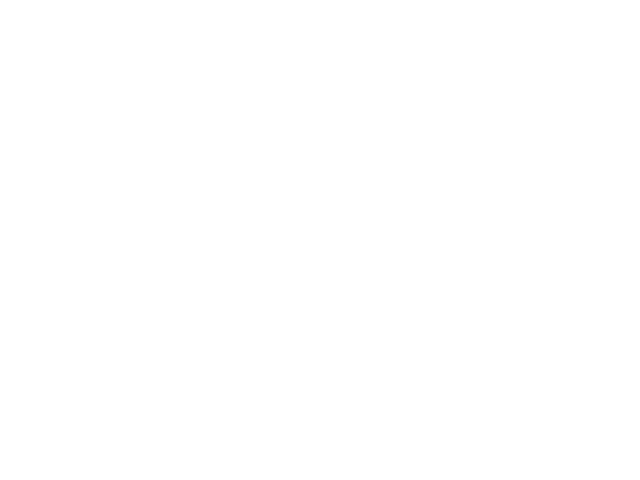

<IPython.core.display.Javascript object>


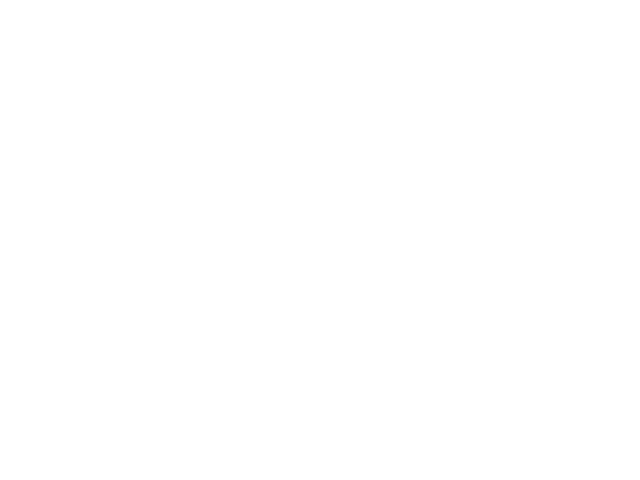

<IPython.core.display.Javascript object>


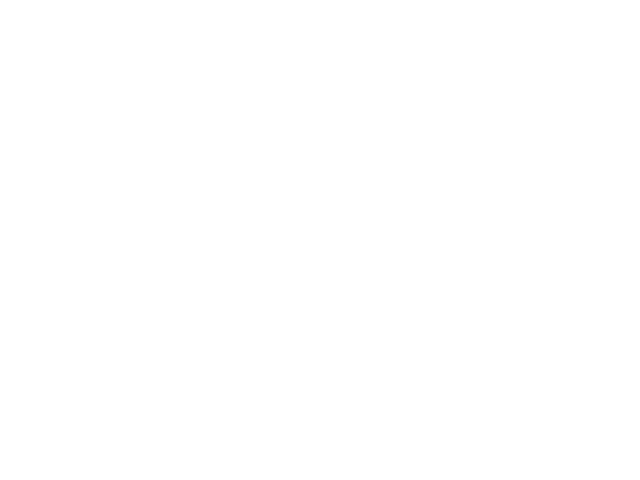

<IPython.core.display.Javascript object>


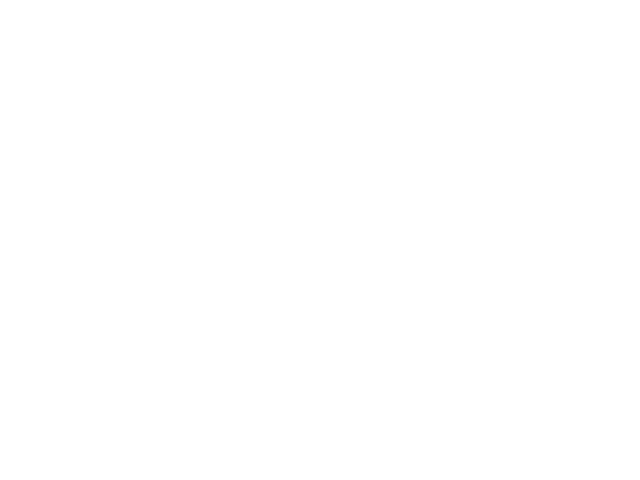

In [63]:
for _,rec in breachruns.iterrows():
    fbs=FigBedStress(rec['model'])
    fbs.fig.savefig(os.path.join(fig_dir,f"bed_stress-{rec['name']}-breach.png"),dpi=200)

<IPython.core.display.Javascript object>


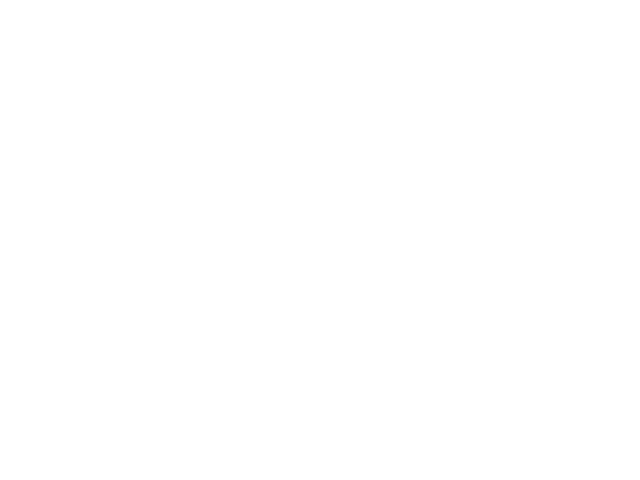

<IPython.core.display.Javascript object>


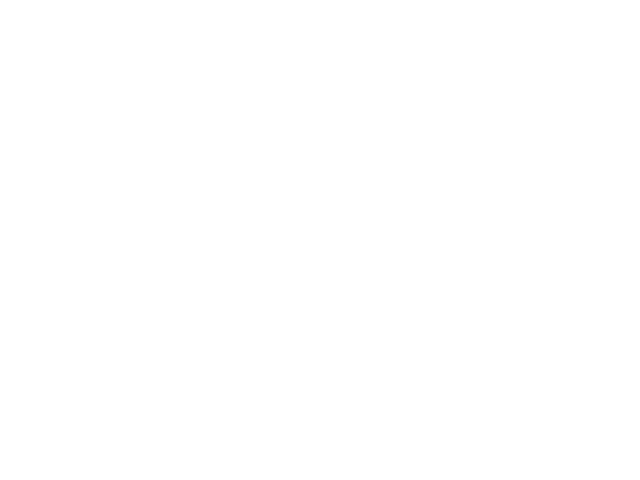

Grids or times don't look the same. Will try reloading map_dataset


INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

<IPython.core.display.Javascript object>


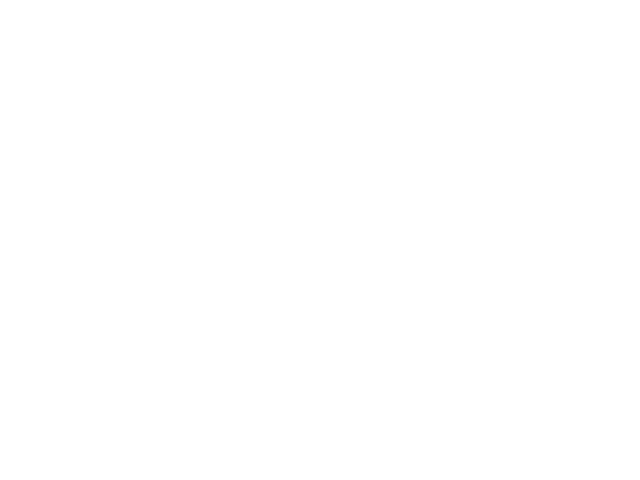

In [64]:
         
rec_base=breachruns[ breachruns['name']=='Base'].iloc[0,:]

for _,rec in breachruns.iterrows():
    if rec['name']=='Base': continue
    img_fn=os.path.join(fig_dir,f"bed_stress-diff-{rec['name']}-breach.png")
    if os.path.exists(img_fn): continue
                        
    fbs=FigBedStressChange(rec_base['model'],rec['model'])
    fbs.fig.savefig(img_fn,dpi=200)

In [65]:
breachruns.model.values[0].run_start

numpy.datetime64('2016-12-08T00:00:00.000000')

In [66]:
breachruns.model.values[0].run_stop

numpy.datetime64('2016-12-16T00:00:00.000000')

In [67]:
plt.close('all')

High Flow Bed Stress
--

In [71]:
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
runs=all_runs[ 
    (all_runs.layers==100) 
    & (all_runs.period=='2016long')
    & (all_runs.flows=='impaired')
    & (all_runs.slr==0.0)
].copy()
runs['name']=runs.scen.map(scen_names)
six.moves.reload_module(dfm)
runs['model']=runs.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))

runs

run_dir  scen  layers  slr  \
0  data_2016long_3d_asbuilt_impaired_scen0_l100-v...     0     100  0.0   
1  data_2016long_3d_asbuilt_impaired_scen1_l100-v...     1     100  0.0   
2  data_2016long_3d_asbuilt_impaired_scen2_l100-v...     2     100  0.0   
3  data_2016long_3d_asbuilt_impaired_scen3_l100-v...     3     100  0.0   

     period    status     flows    name  \
0  2016long  complete  impaired    Base   
1  2016long  complete  impaired     Low   
2  2016long  complete  impaired  Medium   
3  2016long  complete  impaired    High   

                                               model  
0  <DFlowModel: data_2016long_3d_asbuilt_impaired...  
1  <DFlowModel: data_2016long_3d_asbuilt_impaired...  
2  <DFlowModel: data_2016long_3d_asbuilt_impaired...  
3  <DFlowModel: data_2016long_3d_asbuilt_impaired...

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)


Will look at high flow stress from 2017-01-05T00:00:00.000000000 to 2017-02-26T00:00:00.000000000


<IPython.core.display.Javascript object>


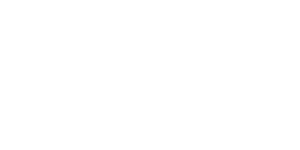

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)


Will look at high flow stress from 2017-01-05T00:00:00.000000000 to 2017-02-26T00:00:00.000000000


<IPython.core.display.Javascript object>


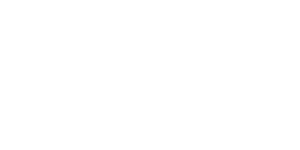

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)


Will look at high flow stress from 2017-01-05T00:00:00.000000000 to 2017-02-26T00:00:00.000000000


<IPython.core.display.Javascript object>


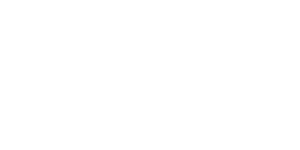

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)


Will look at high flow stress from 2017-01-05T00:00:00.000000000 to 2017-02-26T00:00:00.000000000


<IPython.core.display.Javascript object>


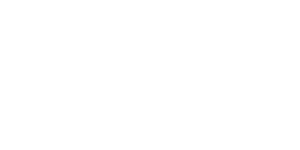

In [72]:
period_dates=[np.datetime64('2017-01-04'), np.datetime64('2017-02-27') ]

kws=dict(zoom=(551904., 553317., 4123944., 4125157.),
         figsize=(9.1,5))

for _,rec in runs.iterrows():
    mds=rec['model'].map_dataset(chain=True)
    map_times=mds.time.values
    period_sel=(map_times>=period_dates[0]) & (map_times<period_dates[1])
    idxs=np.nonzero(period_sel)[0]
    print(f"Will look at high flow stress from {map_times[idxs[0]]} to {map_times[idxs[-1]]}")
    fbs=FigBedStress(rec['model'],period_sel=period_sel,**kws)
    fbs.fig.savefig(os.path.join(fig_dir,f"bed_stress-{rec['name']}-highflow.png"),dpi=200)


Will look at high flow stress from 2017-01-05T00:00:00.000000000 to 2017-02-26T00:00:00.000000000
Checking for image fig-scenarios-20220907/bed_stress-diff-Low-highflow.png


<IPython.core.display.Javascript object>


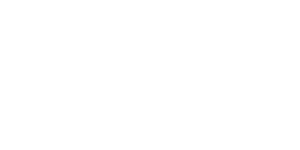

Checking for image fig-scenarios-20220907/bed_stress-diff-Medium-highflow.png


<IPython.core.display.Javascript object>


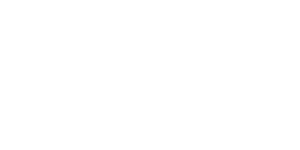

Checking for image fig-scenarios-20220907/bed_stress-diff-High-highflow.png
Grids or times don't look the same. Will try reloading map_dataset


INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

<IPython.core.display.Javascript object>


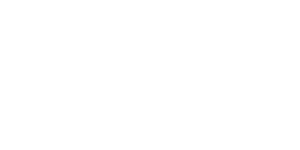

In [73]:
# Some annoying gymnastics to make sure the runs are on the same grid,
# and same chaining.
rec_base=runs[runs['name']=='Base'].iloc[0,:]
kws=dict(zoom=(551904., 553317., 4123944., 4125157.),
         figsize=(9.1,5))

mds=rec_base['model'].map_dataset(chain=True)
map_times=mds.time.values
period_sel=(map_times>=period_dates[0]) & (map_times<period_dates[1])
idxs=np.nonzero(period_sel)[0]
print(f"Will look at high flow stress from {map_times[idxs[0]]} to {map_times[idxs[-1]]}")
kws['period_sel']=period_sel
kws['map_dataset_kwargs']=dict(chain=True)

for _,rec in runs.iterrows():
    if rec['name']=='Base': continue
    mds=rec['model'].map_dataset(chain=True) 
    
    img_fn=os.path.join(fig_dir,f"bed_stress-diff-{rec['name']}-highflow.png")
    print(f"Checking for image {img_fn}")
    if os.path.exists(img_fn): continue
    fbs=FigBedStressChange(rec_base['model'],rec['model'],**kws)
    fbs.fig.savefig(img_fn,dpi=200)

Salinity time series
--

In [74]:
# time series of top/bottom salinity at some key locations across
# different scenarios.
# Not yet sure how to present this, so stuff it into a netcdf


In [75]:
salt_stations=[ ['thalweg_pesc_0000','Ocean'],
                 ['nck','Lagoon'],
                 ['pch_up','Culverts (N)'],
                 ['npc','Ped. Bridge'],
                 ['nmp','North Marsh Panne'],
               ]

from stompy import filters

def fig_salinity_bystation_timeseries(runs,station,label,min_depth=0.0):
    fig,ax=plt.subplots(1,1,figsize=(7.5,4))
    
    colors=['tab:Blue','tab:Orange','tab:Green','tab:Red']
    #colors=list(Colors)
    alpha=0.12
    t_starts=[]
    t_stops =[]
    
    for color,(_,rec) in zip(colors,runs.iterrows()):
        salt=his_cache(rec['model'],stations=station,variable='salinity')        
        zorder=2
        salt_min=np.nanmin(salt,axis=1)
        salt_max=np.nanmax(salt,axis=1)
        
        if min_depth>0.0:
            eta=his_cache(rec['model'],stations=station,variable='waterlevel')
            z_bed=his_cache(rec['model'],stations=station,variable='bedlevel')
            depth=eta-z_bed
            valid=depth>=min_depth
            salt_min[~valid]=np.nan
            salt_max[~valid]=np.nan
            
        # Data dt is 15 min.
        win=60*4
        salt_min=filters.lowpass_fir(salt_min,win)
        salt_max=filters.lowpass_fir(salt_max,win)
        
        #color=colors.pop(0)
        ax.fill_between(salt.time,
                        salt_min,salt_max,
                        label=rec['name'],color=color,
                        lw=1.2,alpha=alpha,zorder=zorder)
        ax.plot(salt.time,salt_min,lw=0.75,color=color,zorder=3)
        ax.plot(salt.time,salt_max,lw=0.75,color=color,zorder=3)
        t_starts.append(salt.time.values[0])
        t_stops.append(salt.time.values[-1])
        
    ax.legend(loc='upper center',bbox_to_anchor=[0.45,1.12],ncol=len(runs),
              frameon=0)
    label_events(ax)
    # in case some runs are truncated.
    ax.axis(xmin=np.min(t_starts),xmax=np.max(t_stops))
    
    for color,t_stop in zip(colors,t_stops):
        if t_stop<np.max(t_stops):
            ax.axvline(t_stop,color=color,ls=':',lw=0.75)
    
    ax.set_ylabel('Salinity (ppt)')
    ax.text(0.03,0.97,label,transform=ax.transAxes,ha='left',va='top')
    fig.autofmt_xdate()
    fig.subplots_adjust(right=0.98,left=0.1,top=0.92, bottom=0.14)
    return fig

<IPython.core.display.Javascript object>


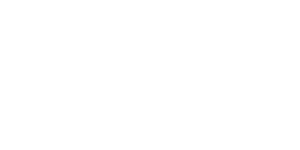

<IPython.core.display.Javascript object>


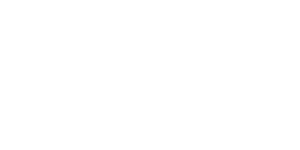

<IPython.core.display.Javascript object>


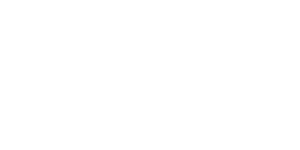

<IPython.core.display.Javascript object>


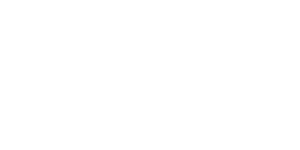

<IPython.core.display.Javascript object>


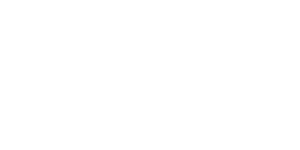

In [76]:
for station,label in salt_stations:
    fig=fig_salinity_bystation_timeseries(runs,station,label,min_depth=0.025)
    fig.savefig(os.path.join(fig_dir,f'salinity-timeseries-2016-stn_{station}.png'),
                dpi=150)

In [77]:
plt.close('all')

Sea Level Rise
---

Show how the inlet depth is adjusted

In [78]:
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
sel=( (all_runs.scen==0)
     &(all_runs.layers==100) 
     &(all_runs.period=='2016long')
     &(all_runs.flows=='impaired'))
run_slr =all_runs[ sel&(all_runs.slr==0.61)]['run_dir'].values[0]
run_base=all_runs[ sel&(all_runs.slr==0.00)]['run_dir'].values[0]
base_slr_runs=all_runs[sel] # for pre/post Base plots
print(run_slr)
print(run_base)

data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01
data_2016long_3d_asbuilt_impaired_scen0_l100-v027_r01


In [79]:
model_slr=dfm.DFlowModel.load(run_slr)
model_base=dfm.DFlowModel.load(run_base)

In [80]:
# This will fail if the grids are ever out of sync
mds_slr=model_slr.map_dataset()
mds_base=model_base.map_dataset(grid=mds_slr.grid)

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removin

<IPython.core.display.Javascript object>


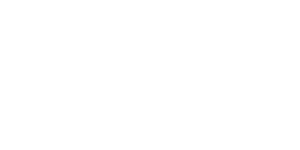

In [81]:
# Figure showing how the mouth if adjusted.

zoom_mouth=[551963., 552311., 4124425., 4124912.]
fig,axs=plt.subplots(1,3,figsize=[8.5,3.5])

plt.setp(axs,adjustable='datalim')

z_base=mds_base['mesh2d_flowelem_bl'].values
z_slr = mds_slr['mesh2d_flowelem_bl'].values
delta=z_slr-z_base

coll0=mds_base.grid.plot_cells(values=z_base,ax=axs[0],cmap='turbo')
coll1=mds_slr.grid.plot_cells(values=z_slr,ax=axs[1],cmap='turbo')
coll2=mds_slr.grid.plot_cells(values=delta,cmap='coolwarm',clim=[-0.75,0.75])

for coll in [coll0,coll1]:
    coll.set_clim([0,3.5])
    
for ax in axs:
    ax.axis(zoom_mouth)
    ax.xaxis.set_visible(0)
    ax.yaxis.set_visible(0)
    
fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.02)

cax0=fig.add_axes([0.23,0.52,0.02,0.40])
cax2=fig.add_axes([0.885,0.52,0.02,0.40])
plt.colorbar(coll0,cax=cax0,label='m')
plt.colorbar(coll2,cax=cax2,label='m')

for label,ax in zip('abc',axs):
    ax.text(0.05,0.98,f"({label})",transform=ax.transAxes,va='top')
fig.savefig(os.path.join(fig_dir,'slr_mouth_adjustment.png'),dpi=200)

SLR Salinity
--

In [82]:
base_slr_runs=base_slr_runs.copy()

base_slr_runs['name']=base_slr_runs.slr.map({0.00:'Base',0.61:'Base+SLR'})
base_slr_runs['model']=base_slr_runs.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))
base_slr_runs

run_dir  scen  layers   slr  \
0  data_2016long_3d_asbuilt_impaired_scen0_l100-v...     0     100  0.00   
4  data_2016long_3d_asbuilt_impaired_scen0_slr0.6...     0     100  0.61   

     period    status     flows      name  \
0  2016long  complete  impaired      Base   
4  2016long  complete  impaired  Base+SLR   

                                               model  
0  <DFlowModel: data_2016long_3d_asbuilt_impaired...  
4  <DFlowModel: data_2016long_3d_asbuilt_impaired...

<IPython.core.display.Javascript object>


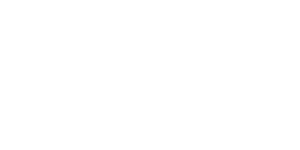

data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01/DFM_OUTPUT_flowfm/cache/v00-stations_thalweg_pesc_0000-var_salinity.nc cache miss
3 chained datasets
Geometries match?
Geometries match?


<IPython.core.display.Javascript object>


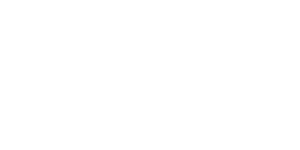

data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01/DFM_OUTPUT_flowfm/cache/v00-stations_nck-var_salinity.nc cache miss


<IPython.core.display.Javascript object>


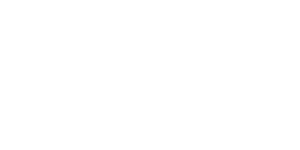

data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01/DFM_OUTPUT_flowfm/cache/v00-stations_pch_up-var_salinity.nc cache miss


<IPython.core.display.Javascript object>


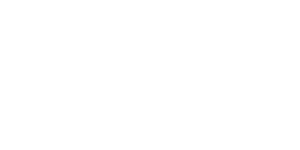

data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01/DFM_OUTPUT_flowfm/cache/v00-stations_npc-var_salinity.nc cache miss


<IPython.core.display.Javascript object>


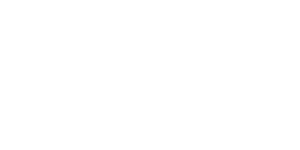

data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01/DFM_OUTPUT_flowfm/cache/v00-stations_nmp-var_salinity.nc cache miss


In [83]:
for station,label in salt_stations:
    fig=fig_salinity_bystation_timeseries(base_slr_runs,station,label,min_depth=0.025)
    fig.savefig(os.path.join(fig_dir,f'salinity-timeseries-base_slr-2016-stn_{station}.png'),
                dpi=150)

In [84]:
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
slr_runs=all_runs[ (all_runs.layers==100) 
                  &(all_runs.slr==0.61) # risky...
                  &(all_runs.period=='2016long')
                  &(all_runs.flows=='impaired')
                 ].copy()
slr_runs['name']=slr_runs.scen.map(lambda s: scen_names[s]+"+SLR")
slr_runs['model']=slr_runs.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))
slr_runs

run_dir  scen  layers   slr  \
4   data_2016long_3d_asbuilt_impaired_scen0_slr0.6...     0     100  0.61   
6   data_2016long_3d_asbuilt_impaired_scen1_slr0.6...     1     100  0.61   
8   datacws_2016long_3d_asbuilt_impaired_scen2_slr...     2     100  0.61   
10  data_2016long_3d_asbuilt_impaired_scen3_slr0.6...     3     100  0.61   

      period    status     flows        name  \
4   2016long  complete  impaired    Base+SLR   
6   2016long  complete  impaired     Low+SLR   
8   2016long   running  impaired  Medium+SLR   
10  2016long   running  impaired    High+SLR   

                                                model  
4   <DFlowModel: data_2016long_3d_asbuilt_impaired...  
6   <DFlowModel: data_2016long_3d_asbuilt_impaired...  
8   <DFlowModel: datacws_2016long_3d_asbuilt_impai...  
10  <DFlowModel: data_2016long_3d_asbuilt_impaired...

<IPython.core.display.Javascript object>


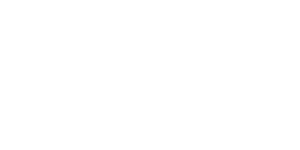

datacws_2016long_3d_asbuilt_impaired_scen2_slr0.61m_l100-v000/DFM_OUTPUT_flowfm/cache/v00-stations_thalweg_pesc_0000-var_salinity.nc cache miss
1 chained datasets
datacws_2016long_3d_asbuilt_impaired_scen2_slr0.61m_l100-v000/DFM_OUTPUT_flowfm/cache/v00-stations_thalweg_pesc_0000-var_waterlevel.nc cache miss
datacws_2016long_3d_asbuilt_impaired_scen2_slr0.61m_l100-v000/DFM_OUTPUT_flowfm/cache/v00-stations_thalweg_pesc_0000-var_bedlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_thalweg_pesc_0000-var_salinity.nc cache miss
1 chained datasets
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_thalweg_pesc_0000-var_waterlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_thalweg_pesc_0000-var_bedlevel.nc cache miss


<IPython.core.display.Javascript object>


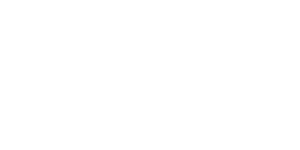

datacws_2016long_3d_asbuilt_impaired_scen2_slr0.61m_l100-v000/DFM_OUTPUT_flowfm/cache/v00-stations_nck-var_salinity.nc cache miss
datacws_2016long_3d_asbuilt_impaired_scen2_slr0.61m_l100-v000/DFM_OUTPUT_flowfm/cache/v00-stations_nck-var_waterlevel.nc cache miss
datacws_2016long_3d_asbuilt_impaired_scen2_slr0.61m_l100-v000/DFM_OUTPUT_flowfm/cache/v00-stations_nck-var_bedlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_nck-var_salinity.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_nck-var_waterlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_nck-var_bedlevel.nc cache miss


<IPython.core.display.Javascript object>


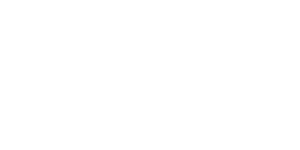

datacws_2016long_3d_asbuilt_impaired_scen2_slr0.61m_l100-v000/DFM_OUTPUT_flowfm/cache/v00-stations_pch_up-var_salinity.nc cache miss
datacws_2016long_3d_asbuilt_impaired_scen2_slr0.61m_l100-v000/DFM_OUTPUT_flowfm/cache/v00-stations_pch_up-var_waterlevel.nc cache miss
datacws_2016long_3d_asbuilt_impaired_scen2_slr0.61m_l100-v000/DFM_OUTPUT_flowfm/cache/v00-stations_pch_up-var_bedlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_pch_up-var_salinity.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_pch_up-var_waterlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_pch_up-var_bedlevel.nc cache miss


<IPython.core.display.Javascript object>


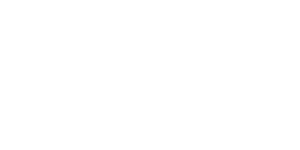

datacws_2016long_3d_asbuilt_impaired_scen2_slr0.61m_l100-v000/DFM_OUTPUT_flowfm/cache/v00-stations_npc-var_salinity.nc cache miss
datacws_2016long_3d_asbuilt_impaired_scen2_slr0.61m_l100-v000/DFM_OUTPUT_flowfm/cache/v00-stations_npc-var_waterlevel.nc cache miss
datacws_2016long_3d_asbuilt_impaired_scen2_slr0.61m_l100-v000/DFM_OUTPUT_flowfm/cache/v00-stations_npc-var_bedlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_npc-var_salinity.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_npc-var_waterlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_npc-var_bedlevel.nc cache miss


<IPython.core.display.Javascript object>


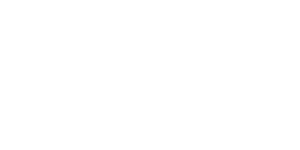

datacws_2016long_3d_asbuilt_impaired_scen2_slr0.61m_l100-v000/DFM_OUTPUT_flowfm/cache/v00-stations_nmp-var_salinity.nc cache miss
datacws_2016long_3d_asbuilt_impaired_scen2_slr0.61m_l100-v000/DFM_OUTPUT_flowfm/cache/v00-stations_nmp-var_waterlevel.nc cache miss
datacws_2016long_3d_asbuilt_impaired_scen2_slr0.61m_l100-v000/DFM_OUTPUT_flowfm/cache/v00-stations_nmp-var_bedlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_nmp-var_salinity.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_nmp-var_waterlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_nmp-var_bedlevel.nc cache miss


In [85]:
for station,label in salt_stations:
    fig=fig_salinity_bystation_timeseries(slr_runs,station,label,min_depth=0.025)
    fig.savefig(os.path.join(fig_dir,f'salinity-timeseries-slr-2016-stn_{station}.png'),
                dpi=150)

In [86]:
plt.close('all')

<IPython.core.display.Javascript object>


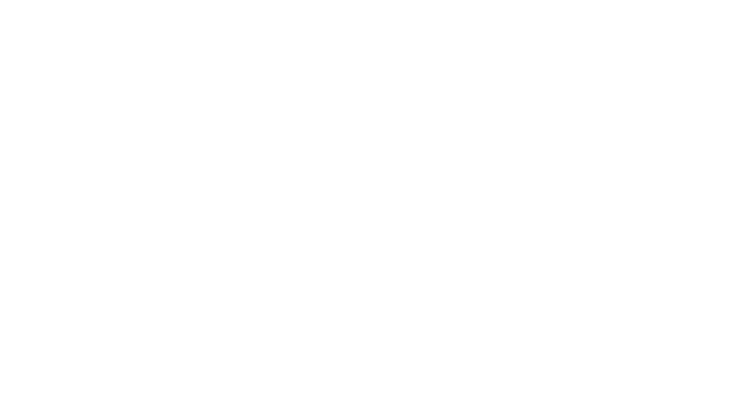

<IPython.core.display.Javascript object>


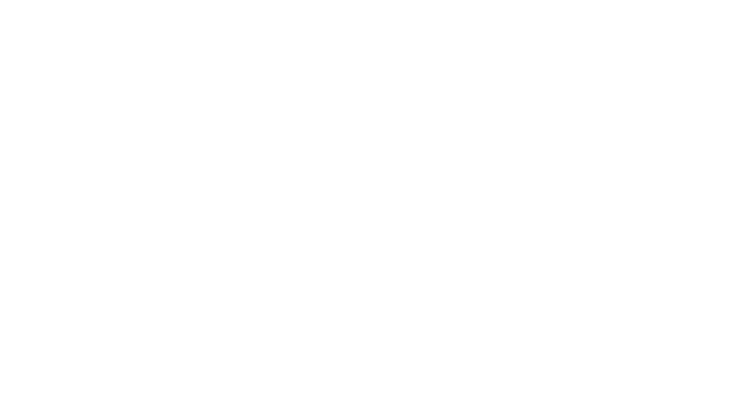

<IPython.core.display.Javascript object>


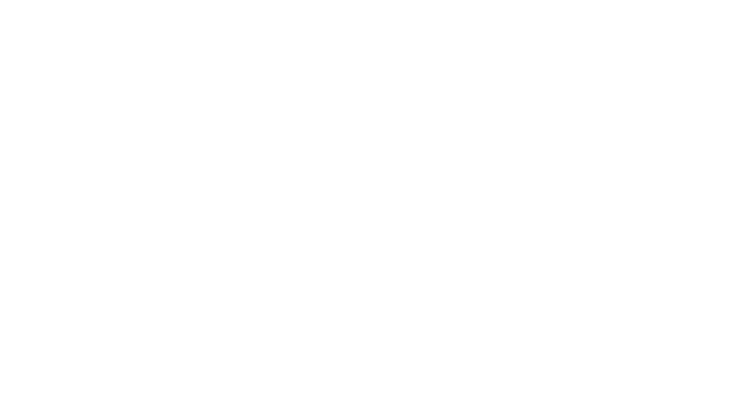

<IPython.core.display.Javascript object>


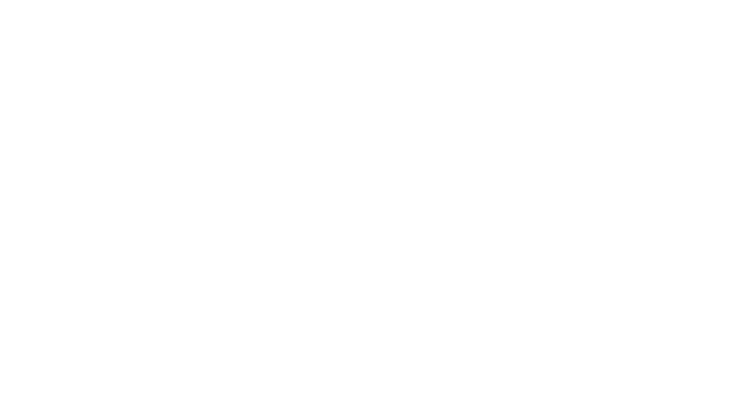

<IPython.core.display.Javascript object>


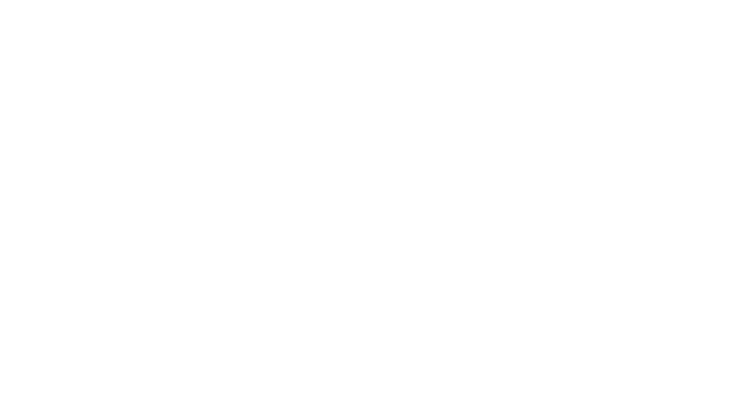

<IPython.core.display.Javascript object>


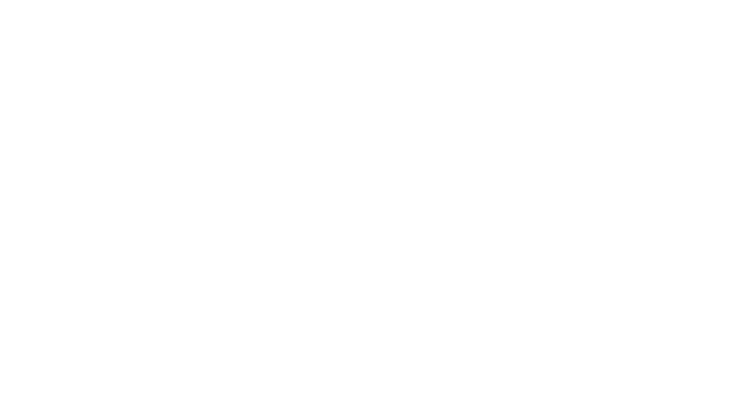

<IPython.core.display.Javascript object>


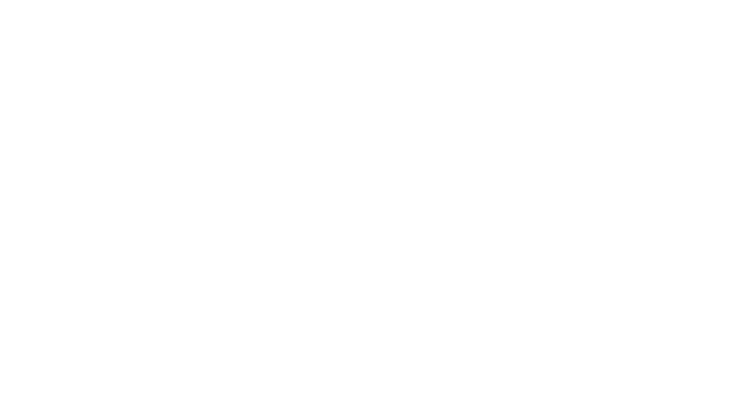

<IPython.core.display.Javascript object>


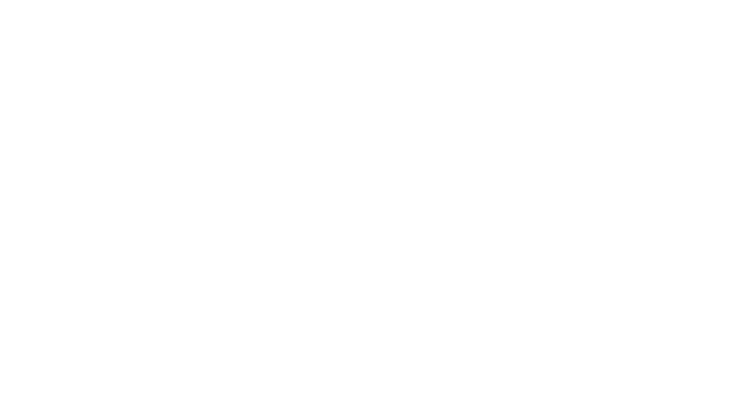

<IPython.core.display.Javascript object>


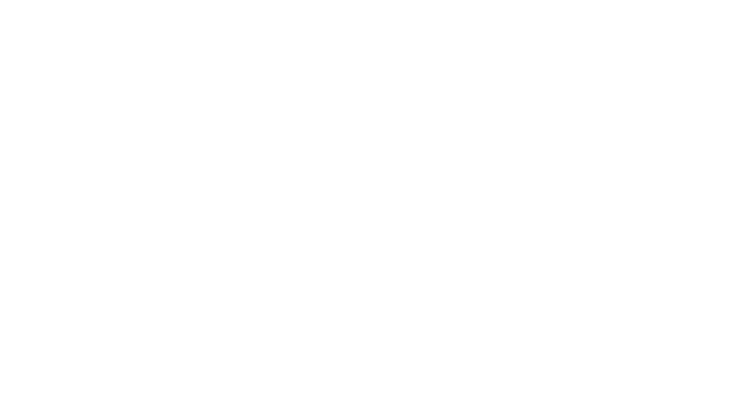

<IPython.core.display.Javascript object>


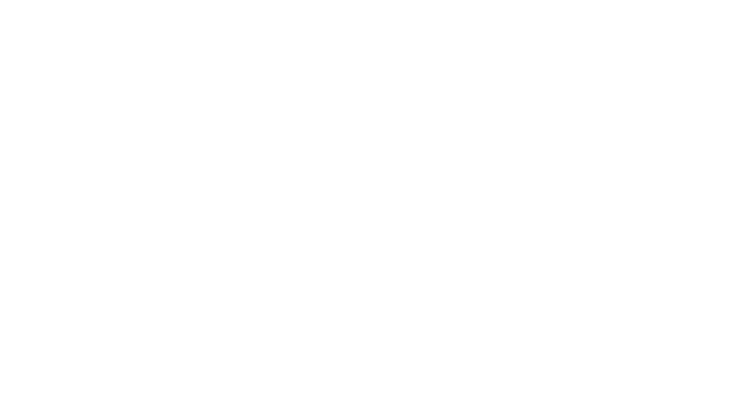

In [87]:
for station,label in stage_stations:
    fig=fig_waterlevel_bystation_timeseries(slr_runs,station,label,min_depth=0.025)
    fig.savefig(os.path.join(fig_dir,f'stage-timeseries-slr-2016-stn_{station}.png'),
                dpi=150)
    fig2=fig_waterlevel_bystation_timeseries(slr_runs,station,label,as_depth=True,min_depth=0.025)
    fig2.savefig(os.path.join(fig_dir,f'depth-timeseries-slr-2016-stn_{station}.png'),
                 dpi=150)
    

<IPython.core.display.Javascript object>


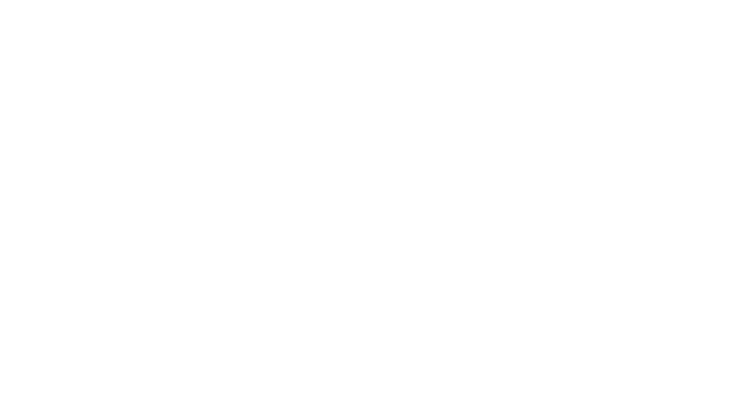

<IPython.core.display.Javascript object>


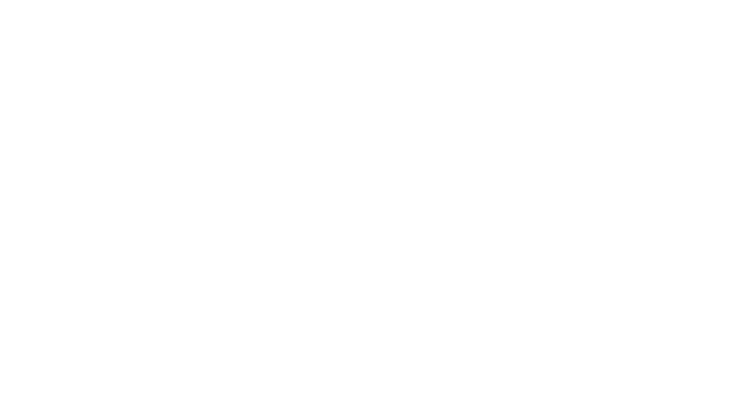

<IPython.core.display.Javascript object>


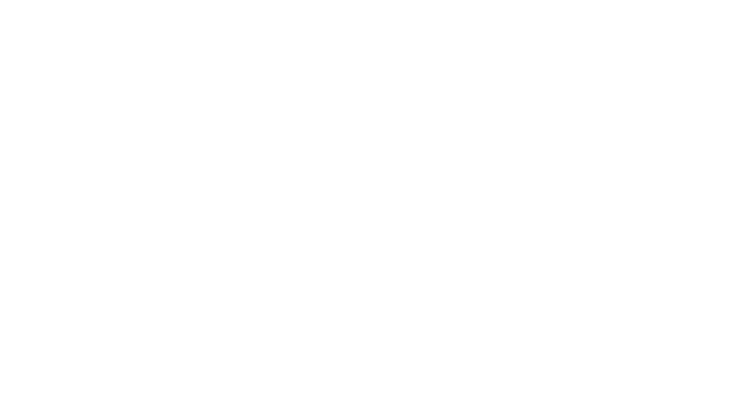

<IPython.core.display.Javascript object>


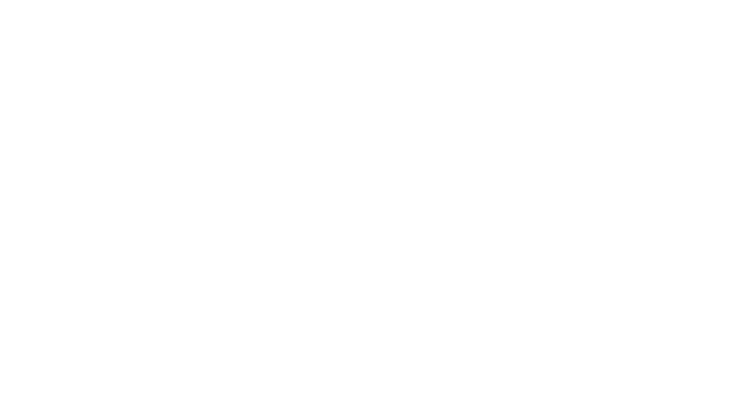

<IPython.core.display.Javascript object>


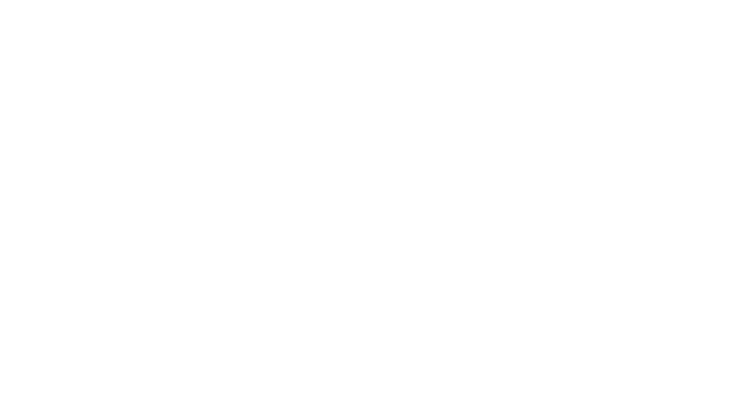

<IPython.core.display.Javascript object>


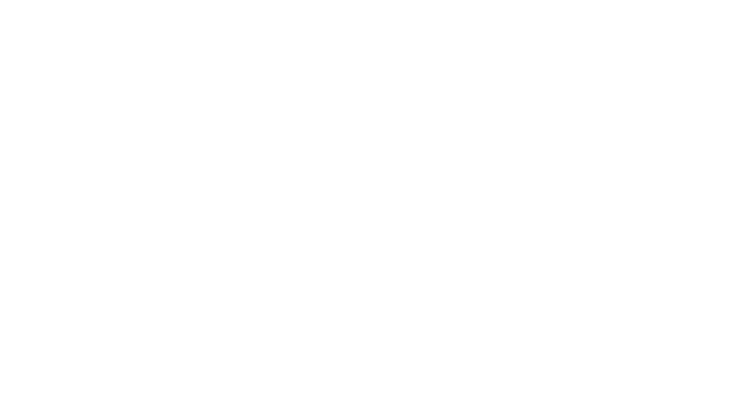

<IPython.core.display.Javascript object>


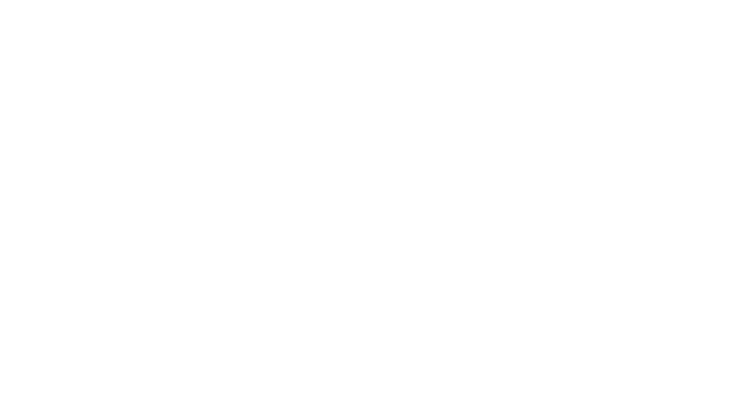

<IPython.core.display.Javascript object>


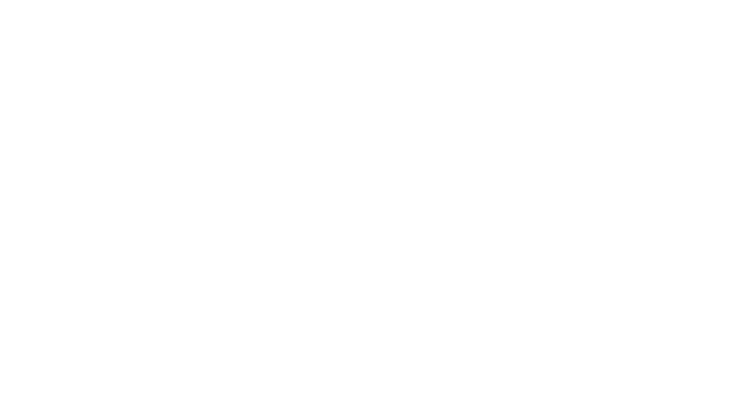

In [88]:
for _,rec in slr_runs.iterrows():
    fig=fig_waterlevel_timeseries(rec) 
    fig.savefig(os.path.join(fig_dir,f"stage-timeseries-slr-2016-{rec['name']}.png"),
                dpi=150)
    fig2=fig_waterlevel_timeseries(rec,as_depth=True) 
    fig2.savefig(os.path.join(fig_dir,f"depth-timeseries-slr-2016-{rec['name']}.png"),
                 dpi=150)

SLR Tidal Prism
==

In [89]:
# currently just have Base+SLR tidal
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
sel=( (all_runs.scen==0)
     &(all_runs.layers==100) 
     &(all_runs.period=='2016tidal')
     &(all_runs.flows=='impaired'))
base_tidal_slr_runs=all_runs[sel] # for pre/post Base plots

base_tidal_slr_runs=base_tidal_slr_runs.copy()

base_tidal_slr_runs['name']=base_tidal_slr_runs.slr.map({0.00:'Base',0.61:'Base+SLR'})
base_tidal_slr_runs['model']=base_tidal_slr_runs.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))
base_tidal_slr_runs

run_dir  scen  layers   slr  \
5   data_2016long_3d_asbuilt_impaired_scen0_slr0.6...     0     100  0.61   
20  data_2016long_3d_asbuilt_impaired_scen0_l100-v...     0     100  0.00   

       period     status     flows      name  \
5   2016tidal   complete  impaired  Base+SLR   
20  2016tidal  completed  impaired      Base   

                                                model  
5   <DFlowModel: data_2016long_3d_asbuilt_impaired...  
20  <DFlowModel: data_2016long_3d_asbuilt_impaired...

In [90]:
# Prism table:
prisms=[]
for tk in [None,'mouth_xs']:
    for _,row in base_tidal_slr_runs.iterrows():
        ds=extract_volumes(row['model'].his_dataset(),ebb_time,timekeeper_section=tk)
        ds['run']=(),row['name']
        ds['timebase']=(),(tk or 'local')
        del ds['cross_section_name']
        del ds['vol_Qnet'] # was for debugging -- matches well.
        prisms.append(ds)
prisms_ds=xr.concat(prisms,dim='run')
prisms=prisms_ds.to_dataframe()
pd.set_option('display.max_rows', 200)
prisms

volume      vol_tidal  duration_h  \
cross_section    run                                                  
mouth_xs         Base+SLR  336803.535789  301069.035059       19.25   
                 Base      161882.880996  150954.368065       11.25   
                 Base+SLR  336803.535789  301069.035059       19.25   
                 Base      161882.880996  150954.368065       11.25   
n_pond_xs        Base+SLR   29716.933580   27667.035544       19.25   
                 Base       32154.992024   33605.802386       11.75   
                 Base+SLR   29474.061955   27424.163918       19.25   
                 Base       22264.394047   23653.467797       11.25   
n_ditch_xs       Base+SLR  -12464.917067  -10581.478343       16.50   
                 Base        5164.989755    5205.719054       17.25   
                 Base+SLR  -12244.859291  -10047.514113       19.25   
                 Base        1020.848546    1047.411132       11.25   
n_complex_xs     Base+SLR  110009.908237  102673.370018       19.25   
                 Base       41328.847659   43353.741964       11.75   
                 Base+SLR  109258.128550  101921.590331       19.25   
                 Base       31846.304788   33785.033378       11.25   
pesca_mid_xs     Base+SLR   20247.355203   15334.436559       17.50   
                 Base       34681.455889   29339.279336       11.25   
                 Base+SLR   20799.251763   15395.041254       19.25   
                 Base       34681.455889   29339.279336       11.25   
butano_lower_xs  Base+SLR  121726.714754  118225.177537       19.25   
                 Base       50239.431499   52998.706370       11.25   
                 Base+SLR  121726.714754  118225.177537       19.25   
                 Base       50239.431499   52998.706370       11.25   
pesca_lower_xs   Base+SLR  180283.404916  143861.410756       19.25   
                 Base       76521.800802   65983.947216       11.50   
                 Base+SLR  180283.404916  143861.410756       19.25   
                 Base       75988.747416   65679.977604       11.25   
pesca_bc_xs      Base+SLR    3527.726959    -145.275031       13.50   
                 Base        3527.725744    -145.263108       13.50   
                 Base+SLR    5270.828875      33.400111       19.25   
                 Base        3030.422573     -30.401470       11.25   
butano_bc_xs     Base+SLR    2443.724515     135.739927       19.75   
                 Base        1621.766652     263.868191       11.50   
                 Base+SLR    2381.807741     132.253142       19.25   
                 Base        1591.008986     262.630057       11.25   
butano_mid_xs    Base+SLR   51797.828088   56396.234324       17.25   
                 Base       38772.353101   34842.023475       11.25   
                 Base+SLR   48501.681542   53633.236327       19.25   
                 Base       38772.353101   34842.023475       11.25   
pesca_rndhill    Base+SLR   12197.790075    6165.168171       18.75   
                 Base       16042.397018   12026.603020       11.50   
                 Base+SLR   12467.644657    6274.152836       19.25   
                 Base       15940.594872   12012.100744       11.25   
pesca_upper_xs   Base+SLR   10104.307619    4297.663688       18.75   
                 Base       12075.670272    8294.457066       11.50   
                 Base+SLR   10359.986344    4398.498575       19.25   
                 Base       11976.111693    8277.098775       11.25   
pesca_top_xs     Base+SLR    4128.816536     621.205828       12.50   
                 Base        4145.196748     751.611005       12.50   
                 Base+SLR    6238.873458     837.152968       19.25   
                 Base        3802.218648     747.991479       11.25   
ocean_xs         Base+SLR  339171.616051  294900.301608       18.75   
                 Base      180382.304812  162306.801700       11.00   
                 Base+SLR  339670.833764  294218.950935   

In [91]:
for tbase in prisms['timebase'].unique():
    print("Time base",tbase)
    df=prisms[ prisms['timebase']==tbase]
    df=df['volume'].unstack().reset_index()
    df=df[ df.cross_section.isin(section_sel)].copy()

    df['Cross section']=df['cross_section'].map(section_sel)

    df=df.set_index('Cross section')
    del df['cross_section']
    df.to_csv(os.path.join(fig_dir,f"ebb-prisms-slr-timebase_{tbase}.csv"))

    # Just for display:
    for col in df.columns:
        df[col]=df[col].apply(lambda s: "%.0f"%s)
    display(df)

Time base local


run              Base Base+SLR
Cross section                 
Butano Ck       55507   185196
Mouth          161883   336804
NM Complex      41329   110010
NM N Ditch       5165   -12465
N Pond          32155    29717
Pescadero Ck    34544    21359

Time base mouth_xs


run              Base Base+SLR
Cross section                 
Butano Ck       55507   185196
Mouth          161883   336804
NM Complex      31846   109258
NM N Ditch       1021   -12245
N Pond          22264    29474
Pescadero Ck    34544    21865

Impaired, Unimpaired Flows
==

In [92]:
def period_completed(model):
    ds=xr.open_dataset(model.his_output(),decode_cf=True, decode_times=True, decode_coords=False)
    return ds.time.values[0], ds.time.values[-1]
def status(model):
    print(f"{model.run_start} -- {model.run_stop}")
    completed=period_completed(model)
    t_remaining=(model.run_stop - completed[1])/np.timedelta64(1,'D')
    print(f"{t_remaining:.2f} days remaining")
def calc_remaining(model):
    return (model.run_stop - period_completed(model)[1])/np.timedelta64(1,'D')
    
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
flow_runs=all_runs[ (all_runs.layers==100) 
                  &(all_runs.slr.isin([0,0.61]))
                  &(all_runs.period.isin(['2016long','2013']))
                  &(all_runs.scen==0)
                 ].copy()

flow_runs['model']=flow_runs.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))    
flow_runs['remaining']=flow_runs['model'].apply(calc_remaining)

flow_runs

run_dir  scen  layers   slr  \
0   data_2016long_3d_asbuilt_impaired_scen0_l100-v...     0     100  0.00   
4   data_2016long_3d_asbuilt_impaired_scen0_slr0.6...     0     100  0.61   
28  data_2016long_3d_asbuilt_unimpaired_scen0_l100...     0     100  0.00   
29  data_2016long_3d_asbuilt_unimpaired_scen0_slr0...     0     100  0.61   
30      data_2013_3d_asbuilt_impaired_scen0_l100-v000     0     100  0.00   
31    data_2013_3d_asbuilt_unimpaired_scen0_l100-v000     0     100  0.00   
32  data_2013_3d_asbuilt_impaired_scen0_slr0.61m_l...     0     100  0.61   

      period    status       flows  \
0   2016long  complete    impaired   
4   2016long  complete    impaired   
28  2016long   running  unimpaired   
29  2016long   running  unimpaired   
30      2013   running    impaired   
31      2013   running  unimpaired   
32      2013   running    impaired   

                                                model   remaining  
0   <DFlowModel: data_2016long_3d_asbuilt_impaired...    0.000000  
4   <DFlowModel: data_2016long_3d_asbuilt_impaired...    0.000000  
28  <DFlowModel: data_2016long_3d_asbuilt_unimpair...  119.958333  
29  <DFlowModel: data_2016long_3d_asbuilt_unimpair...  177.479167  
30  <DFlowModel: data_2013_3d_asbuilt_impaired_sce...   71.406250  
31  <DFlowModel: data_2013_3d_asbuilt_unimpaired_s...  174.187500  
32  <DFlowModel: data_2013_3d_asbuilt_impaired_sce...  272.156250